In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 276)
(4629816, 8)
validation
(621056, 276)
(621056, 8)
test
(624904, 276)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 973704 (3.71 MB)


Trainable params: 973704 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 11:52 - loss: 2.2190 - STD: 0.0572 - MAE: 0.2199

  5/463 [..............................] - ETA: 6s - loss: 2.1037 - STD: 0.0511 - MAE: 0.2167   

  9/463 [..............................] - ETA: 6s - loss: 2.0934 - STD: 0.0479 - MAE: 0.2167

 13/463 [..............................] - ETA: 6s - loss: 2.0822 - STD: 0.0429 - MAE: 0.2167

 17/463 [>.............................] - ETA: 6s - loss: 2.0766 - STD: 0.0409 - MAE: 0.2167

 21/463 [>.............................] - ETA: 5s - loss: 2.0728 - STD: 0.0391 - MAE: 0.2168

 25/463 [>.............................] - ETA: 5s - loss: 2.0690 - STD: 0.0378 - MAE: 0.2168

 29/463 [>.............................] - ETA: 5s - loss: 2.0666 - STD: 0.0375 - MAE: 0.2167

 33/463 [=>............................] - ETA: 5s - loss: 2.0650 - STD: 0.0372 - MAE: 0.2167

 37/463 [=>............................] - ETA: 5s - loss: 2.0634 - STD: 0.0367 - MAE: 0.2167

 41/463 [=>............................] - ETA: 5s - loss: 2.0621 - STD: 0.0362 - MAE: 0.2167

 45/463 [=>............................] - ETA: 5s - loss: 2.0609 - STD: 0.0356 - MAE: 0.2167

 49/463 [==>...........................] - ETA: 5s - loss: 2.0598 - STD: 0.0354 - MAE: 0.2167

 53/463 [==>...........................] - ETA: 5s - loss: 2.0586 - STD: 0.0352 - MAE: 0.2167

 57/463 [==>...........................] - ETA: 5s - loss: 2.0569 - STD: 0.0349 - MAE: 0.2166

 61/463 [==>...........................] - ETA: 5s - loss: 2.0546 - STD: 0.0349 - MAE: 0.2166

 65/463 [===>..........................] - ETA: 5s - loss: 2.0514 - STD: 0.0351 - MAE: 0.2165

 69/463 [===>..........................] - ETA: 5s - loss: 2.0471 - STD: 0.0356 - MAE: 0.2163

 73/463 [===>..........................] - ETA: 5s - loss: 2.0423 - STD: 0.0367 - MAE: 0.2161

 77/463 [===>..........................] - ETA: 5s - loss: 2.0375 - STD: 0.0380 - MAE: 0.2158

 81/463 [====>.........................] - ETA: 5s - loss: 2.0329 - STD: 0.0394 - MAE: 0.2156

 85/463 [====>.........................] - ETA: 5s - loss: 2.0283 - STD: 0.0407 - MAE: 0.2153

 89/463 [====>.........................] - ETA: 5s - loss: 2.0241 - STD: 0.0418 - MAE: 0.2151

 93/463 [=====>........................] - ETA: 4s - loss: 2.0199 - STD: 0.0428 - MAE: 0.2149

 97/463 [=====>........................] - ETA: 4s - loss: 2.0161 - STD: 0.0437 - MAE: 0.2147

101/463 [=====>........................] - ETA: 4s - loss: 2.0122 - STD: 0.0446 - MAE: 0.2145

105/463 [=====>........................] - ETA: 4s - loss: 2.0086 - STD: 0.0454 - MAE: 0.2143

109/463 [======>.......................] - ETA: 4s - loss: 2.0052 - STD: 0.0462 - MAE: 0.2141

113/463 [======>.......................] - ETA: 4s - loss: 2.0020 - STD: 0.0470 - MAE: 0.2140

117/463 [======>.......................] - ETA: 4s - loss: 1.9989 - STD: 0.0477 - MAE: 0.2138

121/463 [======>.......................] - ETA: 4s - loss: 1.9958 - STD: 0.0483 - MAE: 0.2136

125/463 [=======>......................] - ETA: 4s - loss: 1.9928 - STD: 0.0490 - MAE: 0.2135

129/463 [=======>......................] - ETA: 4s - loss: 1.9899 - STD: 0.0497 - MAE: 0.2133

133/463 [=======>......................] - ETA: 4s - loss: 1.9872 - STD: 0.0503 - MAE: 0.2132

137/463 [=======>......................] - ETA: 4s - loss: 1.9843 - STD: 0.0509 - MAE: 0.2130

141/463 [========>.....................] - ETA: 4s - loss: 1.9815 - STD: 0.0515 - MAE: 0.2129

145/463 [========>.....................] - ETA: 4s - loss: 1.9789 - STD: 0.0522 - MAE: 0.2127

149/463 [========>.....................] - ETA: 4s - loss: 1.9762 - STD: 0.0528 - MAE: 0.2126

153/463 [========>.....................] - ETA: 4s - loss: 1.9737 - STD: 0.0534 - MAE: 0.2124

157/463 [=========>....................] - ETA: 4s - loss: 1.9711 - STD: 0.0540 - MAE: 0.2123

161/463 [=========>....................] - ETA: 4s - loss: 1.9685 - STD: 0.0546 - MAE: 0.2121

165/463 [=========>....................] - ETA: 3s - loss: 1.9659 - STD: 0.0552 - MAE: 0.2119

169/463 [=========>....................] - ETA: 3s - loss: 1.9636 - STD: 0.0558 - MAE: 0.2118

173/463 [==========>...................] - ETA: 3s - loss: 1.9611 - STD: 0.0563 - MAE: 0.2117

177/463 [==========>...................] - ETA: 3s - loss: 1.9589 - STD: 0.0569 - MAE: 0.2115

181/463 [==========>...................] - ETA: 3s - loss: 1.9566 - STD: 0.0574 - MAE: 0.2114

185/463 [==========>...................] - ETA: 3s - loss: 1.9544 - STD: 0.0579 - MAE: 0.2112

189/463 [===========>..................] - ETA: 3s - loss: 1.9522 - STD: 0.0584 - MAE: 0.2111

193/463 [===========>..................] - ETA: 3s - loss: 1.9501 - STD: 0.0590 - MAE: 0.2110

197/463 [===========>..................] - ETA: 3s - loss: 1.9479 - STD: 0.0594 - MAE: 0.2108

201/463 [============>.................] - ETA: 3s - loss: 1.9457 - STD: 0.0599 - MAE: 0.2107

205/463 [============>.................] - ETA: 3s - loss: 1.9435 - STD: 0.0604 - MAE: 0.2106

209/463 [============>.................] - ETA: 3s - loss: 1.9414 - STD: 0.0609 - MAE: 0.2105

213/463 [============>.................] - ETA: 3s - loss: 1.9392 - STD: 0.0613 - MAE: 0.2103

217/463 [=============>................] - ETA: 3s - loss: 1.9370 - STD: 0.0618 - MAE: 0.2102

221/463 [=============>................] - ETA: 3s - loss: 1.9348 - STD: 0.0622 - MAE: 0.2101

225/463 [=============>................] - ETA: 3s - loss: 1.9326 - STD: 0.0627 - MAE: 0.2099

229/463 [=============>................] - ETA: 3s - loss: 1.9303 - STD: 0.0631 - MAE: 0.2098

233/463 [==============>...............] - ETA: 3s - loss: 1.9280 - STD: 0.0636 - MAE: 0.2096

237/463 [==============>...............] - ETA: 3s - loss: 1.9256 - STD: 0.0641 - MAE: 0.2095

241/463 [==============>...............] - ETA: 2s - loss: 1.9232 - STD: 0.0645 - MAE: 0.2093

245/463 [==============>...............] - ETA: 2s - loss: 1.9208 - STD: 0.0650 - MAE: 0.2092

249/463 [===============>..............] - ETA: 2s - loss: 1.9185 - STD: 0.0655 - MAE: 0.2090

253/463 [===============>..............] - ETA: 2s - loss: 1.9160 - STD: 0.0660 - MAE: 0.2089

257/463 [===============>..............] - ETA: 2s - loss: 1.9136 - STD: 0.0665 - MAE: 0.2087

261/463 [===============>..............] - ETA: 3s - loss: 1.9111 - STD: 0.0670 - MAE: 0.2086

265/463 [================>.............] - ETA: 3s - loss: 1.9087 - STD: 0.0674 - MAE: 0.2084

269/463 [================>.............] - ETA: 3s - loss: 1.9065 - STD: 0.0679 - MAE: 0.2083

273/463 [================>.............] - ETA: 3s - loss: 1.9042 - STD: 0.0684 - MAE: 0.2081

277/463 [================>.............] - ETA: 3s - loss: 1.9019 - STD: 0.0689 - MAE: 0.2080

281/463 [=================>............] - ETA: 3s - loss: 1.8996 - STD: 0.0694 - MAE: 0.2078

285/463 [=================>............] - ETA: 3s - loss: 1.8975 - STD: 0.0698 - MAE: 0.2077

289/463 [=================>............] - ETA: 2s - loss: 1.8953 - STD: 0.0703 - MAE: 0.2075

293/463 [=================>............] - ETA: 2s - loss: 1.8934 - STD: 0.0707 - MAE: 0.2074

297/463 [==================>...........] - ETA: 2s - loss: 1.8913 - STD: 0.0712 - MAE: 0.2072

301/463 [==================>...........] - ETA: 2s - loss: 1.8892 - STD: 0.0716 - MAE: 0.2071

305/463 [==================>...........] - ETA: 2s - loss: 1.8872 - STD: 0.0720 - MAE: 0.2070

309/463 [===================>..........] - ETA: 2s - loss: 1.8852 - STD: 0.0724 - MAE: 0.2068

313/463 [===================>..........] - ETA: 2s - loss: 1.8832 - STD: 0.0728 - MAE: 0.2067

317/463 [===================>..........] - ETA: 2s - loss: 1.8811 - STD: 0.0732 - MAE: 0.2065

321/463 [===================>..........] - ETA: 2s - loss: 1.8793 - STD: 0.0736 - MAE: 0.2064

325/463 [====================>.........] - ETA: 2s - loss: 1.8774 - STD: 0.0740 - MAE: 0.2063

329/463 [====================>.........] - ETA: 2s - loss: 1.8756 - STD: 0.0744 - MAE: 0.2062

333/463 [====================>.........] - ETA: 2s - loss: 1.8737 - STD: 0.0747 - MAE: 0.2060

337/463 [====================>.........] - ETA: 2s - loss: 1.8719 - STD: 0.0751 - MAE: 0.2059

341/463 [=====================>........] - ETA: 1s - loss: 1.8700 - STD: 0.0755 - MAE: 0.2058

345/463 [=====================>........] - ETA: 1s - loss: 1.8682 - STD: 0.0758 - MAE: 0.2057

349/463 [=====================>........] - ETA: 1s - loss: 1.8664 - STD: 0.0762 - MAE: 0.2055

353/463 [=====================>........] - ETA: 1s - loss: 1.8646 - STD: 0.0766 - MAE: 0.2054

357/463 [======================>.......] - ETA: 1s - loss: 1.8629 - STD: 0.0769 - MAE: 0.2053

361/463 [======================>.......] - ETA: 1s - loss: 1.8612 - STD: 0.0773 - MAE: 0.2052

365/463 [======================>.......] - ETA: 1s - loss: 1.8595 - STD: 0.0776 - MAE: 0.2051

369/463 [======================>.......] - ETA: 1s - loss: 1.8579 - STD: 0.0780 - MAE: 0.2049

373/463 [=======================>......] - ETA: 1s - loss: 1.8562 - STD: 0.0783 - MAE: 0.2048

377/463 [=======================>......] - ETA: 1s - loss: 1.8547 - STD: 0.0786 - MAE: 0.2047

381/463 [=======================>......] - ETA: 1s - loss: 1.8531 - STD: 0.0790 - MAE: 0.2046

385/463 [=======================>......] - ETA: 1s - loss: 1.8516 - STD: 0.0793 - MAE: 0.2045

389/463 [========================>.....] - ETA: 1s - loss: 1.8500 - STD: 0.0796 - MAE: 0.2044

393/463 [========================>.....] - ETA: 1s - loss: 1.8484 - STD: 0.0799 - MAE: 0.2043

397/463 [========================>.....] - ETA: 1s - loss: 1.8468 - STD: 0.0802 - MAE: 0.2042

401/463 [========================>.....] - ETA: 0s - loss: 1.8452 - STD: 0.0805 - MAE: 0.2041

405/463 [=========================>....] - ETA: 0s - loss: 1.8436 - STD: 0.0808 - MAE: 0.2040

409/463 [=========================>....] - ETA: 0s - loss: 1.8422 - STD: 0.0812 - MAE: 0.2039

413/463 [=========================>....] - ETA: 0s - loss: 1.8408 - STD: 0.0815 - MAE: 0.2037

417/463 [==========================>...] - ETA: 0s - loss: 1.8395 - STD: 0.0818 - MAE: 0.2037

421/463 [==========================>...] - ETA: 0s - loss: 1.8382 - STD: 0.0821 - MAE: 0.2036

425/463 [==========================>...] - ETA: 0s - loss: 1.8369 - STD: 0.0823 - MAE: 0.2035

429/463 [==========================>...] - ETA: 0s - loss: 1.8356 - STD: 0.0826 - MAE: 0.2034

433/463 [===========================>..] - ETA: 0s - loss: 1.8342 - STD: 0.0829 - MAE: 0.2033

437/463 [===========================>..] - ETA: 0s - loss: 1.8328 - STD: 0.0832 - MAE: 0.2032

441/463 [===========================>..] - ETA: 0s - loss: 1.8315 - STD: 0.0834 - MAE: 0.2031

445/463 [===========================>..] - ETA: 0s - loss: 1.8301 - STD: 0.0837 - MAE: 0.2030

449/463 [============================>.] - ETA: 0s - loss: 1.8287 - STD: 0.0840 - MAE: 0.2029

453/463 [============================>.] - ETA: 0s - loss: 1.8274 - STD: 0.0842 - MAE: 0.2028

457/463 [============================>.] - ETA: 0s - loss: 1.8260 - STD: 0.0845 - MAE: 0.2027

461/463 [============================>.] - ETA: 0s - loss: 1.8247 - STD: 0.0847 - MAE: 0.2026

463/463 [==============================] - 10s 18ms/step - loss: 1.8240 - STD: 0.0849 - MAE: 0.2026 - val_loss: 1.6862 - val_STD: 0.1086 - val_MAE: 0.1935


Epoch 2/10000


  1/463 [..............................] - ETA: 14s - loss: 1.6733 - STD: 0.1146 - MAE: 0.1918

  5/463 [..............................] - ETA: 6s - loss: 1.6720 - STD: 0.1137 - MAE: 0.1922 

  9/463 [..............................] - ETA: 6s - loss: 1.6688 - STD: 0.1138 - MAE: 0.1921

 13/463 [..............................] - ETA: 5s - loss: 1.6671 - STD: 0.1145 - MAE: 0.1918

 17/463 [>.............................] - ETA: 5s - loss: 1.6682 - STD: 0.1149 - MAE: 0.1918

 21/463 [>.............................] - ETA: 5s - loss: 1.6673 - STD: 0.1150 - MAE: 0.1917

 25/463 [>.............................] - ETA: 5s - loss: 1.6670 - STD: 0.1151 - MAE: 0.1917

 29/463 [>.............................] - ETA: 5s - loss: 1.6665 - STD: 0.1151 - MAE: 0.1917

 33/463 [=>............................] - ETA: 5s - loss: 1.6652 - STD: 0.1154 - MAE: 0.1915

 37/463 [=>............................] - ETA: 5s - loss: 1.6649 - STD: 0.1156 - MAE: 0.1915

 41/463 [=>............................] - ETA: 5s - loss: 1.6642 - STD: 0.1157 - MAE: 0.1914

 45/463 [=>............................] - ETA: 5s - loss: 1.6643 - STD: 0.1157 - MAE: 0.1914

 49/463 [==>...........................] - ETA: 5s - loss: 1.6641 - STD: 0.1159 - MAE: 0.1913

 53/463 [==>...........................] - ETA: 5s - loss: 1.6641 - STD: 0.1159 - MAE: 0.1913

 57/463 [==>...........................] - ETA: 5s - loss: 1.6637 - STD: 0.1159 - MAE: 0.1913

 61/463 [==>...........................] - ETA: 5s - loss: 1.6633 - STD: 0.1161 - MAE: 0.1913

 65/463 [===>..........................] - ETA: 5s - loss: 1.6627 - STD: 0.1161 - MAE: 0.1912

 69/463 [===>..........................] - ETA: 5s - loss: 1.6624 - STD: 0.1162 - MAE: 0.1912

 73/463 [===>..........................] - ETA: 5s - loss: 1.6623 - STD: 0.1163 - MAE: 0.1912

 77/463 [===>..........................] - ETA: 5s - loss: 1.6621 - STD: 0.1164 - MAE: 0.1911

 81/463 [====>.........................] - ETA: 5s - loss: 1.6617 - STD: 0.1164 - MAE: 0.1911

 85/463 [====>.........................] - ETA: 5s - loss: 1.6616 - STD: 0.1166 - MAE: 0.1911

 89/463 [====>.........................] - ETA: 4s - loss: 1.6614 - STD: 0.1166 - MAE: 0.1911

 93/463 [=====>........................] - ETA: 4s - loss: 1.6613 - STD: 0.1167 - MAE: 0.1910

 97/463 [=====>........................] - ETA: 4s - loss: 1.6613 - STD: 0.1168 - MAE: 0.1910

101/463 [=====>........................] - ETA: 4s - loss: 1.6616 - STD: 0.1168 - MAE: 0.1910

105/463 [=====>........................] - ETA: 4s - loss: 1.6615 - STD: 0.1168 - MAE: 0.1910

109/463 [======>.......................] - ETA: 4s - loss: 1.6612 - STD: 0.1168 - MAE: 0.1910

113/463 [======>.......................] - ETA: 4s - loss: 1.6606 - STD: 0.1169 - MAE: 0.1910

117/463 [======>.......................] - ETA: 4s - loss: 1.6601 - STD: 0.1169 - MAE: 0.1909

121/463 [======>.......................] - ETA: 4s - loss: 1.6595 - STD: 0.1170 - MAE: 0.1909

125/463 [=======>......................] - ETA: 4s - loss: 1.6590 - STD: 0.1171 - MAE: 0.1909

129/463 [=======>......................] - ETA: 4s - loss: 1.6587 - STD: 0.1171 - MAE: 0.1908

133/463 [=======>......................] - ETA: 4s - loss: 1.6584 - STD: 0.1172 - MAE: 0.1908

137/463 [=======>......................] - ETA: 4s - loss: 1.6582 - STD: 0.1172 - MAE: 0.1908

141/463 [========>.....................] - ETA: 4s - loss: 1.6580 - STD: 0.1173 - MAE: 0.1908

145/463 [========>.....................] - ETA: 4s - loss: 1.6576 - STD: 0.1173 - MAE: 0.1908

149/463 [========>.....................] - ETA: 4s - loss: 1.6572 - STD: 0.1174 - MAE: 0.1907

153/463 [========>.....................] - ETA: 4s - loss: 1.6568 - STD: 0.1174 - MAE: 0.1907

157/463 [=========>....................] - ETA: 4s - loss: 1.6566 - STD: 0.1175 - MAE: 0.1907

161/463 [=========>....................] - ETA: 4s - loss: 1.6563 - STD: 0.1176 - MAE: 0.1906

165/463 [=========>....................] - ETA: 3s - loss: 1.6559 - STD: 0.1176 - MAE: 0.1906

169/463 [=========>....................] - ETA: 3s - loss: 1.6556 - STD: 0.1177 - MAE: 0.1906

173/463 [==========>...................] - ETA: 3s - loss: 1.6554 - STD: 0.1177 - MAE: 0.1906

177/463 [==========>...................] - ETA: 3s - loss: 1.6550 - STD: 0.1177 - MAE: 0.1906

181/463 [==========>...................] - ETA: 3s - loss: 1.6549 - STD: 0.1178 - MAE: 0.1905

185/463 [==========>...................] - ETA: 3s - loss: 1.6547 - STD: 0.1178 - MAE: 0.1905

189/463 [===========>..................] - ETA: 3s - loss: 1.6543 - STD: 0.1179 - MAE: 0.1905

193/463 [===========>..................] - ETA: 3s - loss: 1.6538 - STD: 0.1179 - MAE: 0.1905

197/463 [===========>..................] - ETA: 3s - loss: 1.6535 - STD: 0.1180 - MAE: 0.1904

201/463 [============>.................] - ETA: 3s - loss: 1.6532 - STD: 0.1180 - MAE: 0.1904

205/463 [============>.................] - ETA: 3s - loss: 1.6528 - STD: 0.1181 - MAE: 0.1904

209/463 [============>.................] - ETA: 3s - loss: 1.6527 - STD: 0.1181 - MAE: 0.1904

213/463 [============>.................] - ETA: 3s - loss: 1.6524 - STD: 0.1182 - MAE: 0.1904

217/463 [=============>................] - ETA: 3s - loss: 1.6521 - STD: 0.1182 - MAE: 0.1903

221/463 [=============>................] - ETA: 3s - loss: 1.6517 - STD: 0.1183 - MAE: 0.1903

225/463 [=============>................] - ETA: 3s - loss: 1.6515 - STD: 0.1184 - MAE: 0.1903

229/463 [=============>................] - ETA: 3s - loss: 1.6511 - STD: 0.1184 - MAE: 0.1902

233/463 [==============>...............] - ETA: 3s - loss: 1.6509 - STD: 0.1185 - MAE: 0.1902

237/463 [==============>...............] - ETA: 3s - loss: 1.6507 - STD: 0.1185 - MAE: 0.1902

241/463 [==============>...............] - ETA: 2s - loss: 1.6504 - STD: 0.1185 - MAE: 0.1902

245/463 [==============>...............] - ETA: 2s - loss: 1.6501 - STD: 0.1186 - MAE: 0.1902

249/463 [===============>..............] - ETA: 2s - loss: 1.6497 - STD: 0.1186 - MAE: 0.1901

253/463 [===============>..............] - ETA: 2s - loss: 1.6495 - STD: 0.1187 - MAE: 0.1901

257/463 [===============>..............] - ETA: 2s - loss: 1.6492 - STD: 0.1187 - MAE: 0.1901

261/463 [===============>..............] - ETA: 2s - loss: 1.6490 - STD: 0.1188 - MAE: 0.1901

265/463 [================>.............] - ETA: 2s - loss: 1.6487 - STD: 0.1188 - MAE: 0.1901

269/463 [================>.............] - ETA: 2s - loss: 1.6483 - STD: 0.1188 - MAE: 0.1900

273/463 [================>.............] - ETA: 2s - loss: 1.6481 - STD: 0.1189 - MAE: 0.1900

277/463 [================>.............] - ETA: 2s - loss: 1.6477 - STD: 0.1189 - MAE: 0.1900

281/463 [=================>............] - ETA: 2s - loss: 1.6475 - STD: 0.1190 - MAE: 0.1900

285/463 [=================>............] - ETA: 2s - loss: 1.6472 - STD: 0.1190 - MAE: 0.1899

289/463 [=================>............] - ETA: 2s - loss: 1.6469 - STD: 0.1191 - MAE: 0.1899

293/463 [=================>............] - ETA: 2s - loss: 1.6466 - STD: 0.1191 - MAE: 0.1899

297/463 [==================>...........] - ETA: 2s - loss: 1.6464 - STD: 0.1192 - MAE: 0.1899

301/463 [==================>...........] - ETA: 2s - loss: 1.6460 - STD: 0.1192 - MAE: 0.1899

305/463 [==================>...........] - ETA: 2s - loss: 1.6457 - STD: 0.1192 - MAE: 0.1898

309/463 [===================>..........] - ETA: 2s - loss: 1.6456 - STD: 0.1193 - MAE: 0.1898

313/463 [===================>..........] - ETA: 2s - loss: 1.6454 - STD: 0.1193 - MAE: 0.1898

317/463 [===================>..........] - ETA: 1s - loss: 1.6452 - STD: 0.1194 - MAE: 0.1898

321/463 [===================>..........] - ETA: 1s - loss: 1.6449 - STD: 0.1194 - MAE: 0.1898

325/463 [====================>.........] - ETA: 1s - loss: 1.6446 - STD: 0.1194 - MAE: 0.1898

329/463 [====================>.........] - ETA: 1s - loss: 1.6444 - STD: 0.1194 - MAE: 0.1897

333/463 [====================>.........] - ETA: 1s - loss: 1.6442 - STD: 0.1195 - MAE: 0.1897

337/463 [====================>.........] - ETA: 1s - loss: 1.6440 - STD: 0.1195 - MAE: 0.1897

341/463 [=====================>........] - ETA: 1s - loss: 1.6439 - STD: 0.1196 - MAE: 0.1897

345/463 [=====================>........] - ETA: 1s - loss: 1.6437 - STD: 0.1196 - MAE: 0.1897

349/463 [=====================>........] - ETA: 1s - loss: 1.6435 - STD: 0.1196 - MAE: 0.1897

353/463 [=====================>........] - ETA: 1s - loss: 1.6433 - STD: 0.1196 - MAE: 0.1897

357/463 [======================>.......] - ETA: 1s - loss: 1.6431 - STD: 0.1197 - MAE: 0.1896

361/463 [======================>.......] - ETA: 1s - loss: 1.6429 - STD: 0.1197 - MAE: 0.1896

365/463 [======================>.......] - ETA: 1s - loss: 1.6427 - STD: 0.1198 - MAE: 0.1896

369/463 [======================>.......] - ETA: 1s - loss: 1.6426 - STD: 0.1198 - MAE: 0.1896

373/463 [=======================>......] - ETA: 1s - loss: 1.6424 - STD: 0.1198 - MAE: 0.1896

377/463 [=======================>......] - ETA: 1s - loss: 1.6423 - STD: 0.1198 - MAE: 0.1896

381/463 [=======================>......] - ETA: 1s - loss: 1.6420 - STD: 0.1199 - MAE: 0.1895

385/463 [=======================>......] - ETA: 1s - loss: 1.6418 - STD: 0.1199 - MAE: 0.1895

389/463 [========================>.....] - ETA: 0s - loss: 1.6415 - STD: 0.1199 - MAE: 0.1895

393/463 [========================>.....] - ETA: 0s - loss: 1.6413 - STD: 0.1200 - MAE: 0.1895

397/463 [========================>.....] - ETA: 0s - loss: 1.6411 - STD: 0.1200 - MAE: 0.1895

401/463 [========================>.....] - ETA: 0s - loss: 1.6408 - STD: 0.1200 - MAE: 0.1895

405/463 [=========================>....] - ETA: 0s - loss: 1.6406 - STD: 0.1201 - MAE: 0.1894

409/463 [=========================>....] - ETA: 0s - loss: 1.6403 - STD: 0.1201 - MAE: 0.1894

413/463 [=========================>....] - ETA: 0s - loss: 1.6401 - STD: 0.1202 - MAE: 0.1894

417/463 [==========================>...] - ETA: 0s - loss: 1.6399 - STD: 0.1202 - MAE: 0.1894

421/463 [==========================>...] - ETA: 0s - loss: 1.6396 - STD: 0.1202 - MAE: 0.1894

425/463 [==========================>...] - ETA: 0s - loss: 1.6394 - STD: 0.1203 - MAE: 0.1893

429/463 [==========================>...] - ETA: 0s - loss: 1.6391 - STD: 0.1203 - MAE: 0.1893

433/463 [===========================>..] - ETA: 0s - loss: 1.6390 - STD: 0.1204 - MAE: 0.1893

437/463 [===========================>..] - ETA: 0s - loss: 1.6388 - STD: 0.1204 - MAE: 0.1893

441/463 [===========================>..] - ETA: 0s - loss: 1.6387 - STD: 0.1204 - MAE: 0.1893

445/463 [===========================>..] - ETA: 0s - loss: 1.6386 - STD: 0.1205 - MAE: 0.1893

449/463 [============================>.] - ETA: 0s - loss: 1.6384 - STD: 0.1205 - MAE: 0.1893

453/463 [============================>.] - ETA: 0s - loss: 1.6383 - STD: 0.1205 - MAE: 0.1892

457/463 [============================>.] - ETA: 0s - loss: 1.6380 - STD: 0.1205 - MAE: 0.1892

461/463 [============================>.] - ETA: 0s - loss: 1.6378 - STD: 0.1205 - MAE: 0.1892

463/463 [==============================] - 7s 14ms/step - loss: 1.6377 - STD: 0.1206 - MAE: 0.1892 - val_loss: 1.6519 - val_STD: 0.1216 - val_MAE: 0.1894


Epoch 3/10000


  1/463 [..............................] - ETA: 15s - loss: 1.6212 - STD: 0.1252 - MAE: 0.1873

  5/463 [..............................] - ETA: 6s - loss: 1.6112 - STD: 0.1240 - MAE: 0.1874 

  9/463 [..............................] - ETA: 6s - loss: 1.6095 - STD: 0.1236 - MAE: 0.1873

 13/463 [..............................] - ETA: 5s - loss: 1.6110 - STD: 0.1243 - MAE: 0.1872

 17/463 [>.............................] - ETA: 5s - loss: 1.6100 - STD: 0.1243 - MAE: 0.1872

 21/463 [>.............................] - ETA: 5s - loss: 1.6104 - STD: 0.1245 - MAE: 0.1872

 25/463 [>.............................] - ETA: 5s - loss: 1.6095 - STD: 0.1245 - MAE: 0.1871

 29/463 [>.............................] - ETA: 5s - loss: 1.6094 - STD: 0.1244 - MAE: 0.1871

 33/463 [=>............................] - ETA: 5s - loss: 1.6096 - STD: 0.1246 - MAE: 0.1871

 37/463 [=>............................] - ETA: 5s - loss: 1.6095 - STD: 0.1245 - MAE: 0.1871

 41/463 [=>............................] - ETA: 5s - loss: 1.6103 - STD: 0.1246 - MAE: 0.1872

 45/463 [=>............................] - ETA: 5s - loss: 1.6108 - STD: 0.1247 - MAE: 0.1872

 49/463 [==>...........................] - ETA: 5s - loss: 1.6102 - STD: 0.1248 - MAE: 0.1871

 53/463 [==>...........................] - ETA: 5s - loss: 1.6104 - STD: 0.1247 - MAE: 0.1871

 57/463 [==>...........................] - ETA: 5s - loss: 1.6102 - STD: 0.1247 - MAE: 0.1871

 61/463 [==>...........................] - ETA: 5s - loss: 1.6104 - STD: 0.1247 - MAE: 0.1871

 65/463 [===>..........................] - ETA: 5s - loss: 1.6102 - STD: 0.1247 - MAE: 0.1871

 69/463 [===>..........................] - ETA: 5s - loss: 1.6100 - STD: 0.1247 - MAE: 0.1871

 73/463 [===>..........................] - ETA: 5s - loss: 1.6100 - STD: 0.1247 - MAE: 0.1871

 77/463 [===>..........................] - ETA: 5s - loss: 1.6100 - STD: 0.1247 - MAE: 0.1871

 81/463 [====>.........................] - ETA: 5s - loss: 1.6100 - STD: 0.1246 - MAE: 0.1872

 85/463 [====>.........................] - ETA: 5s - loss: 1.6107 - STD: 0.1246 - MAE: 0.1872

 89/463 [====>.........................] - ETA: 4s - loss: 1.6105 - STD: 0.1246 - MAE: 0.1872

 93/463 [=====>........................] - ETA: 4s - loss: 1.6104 - STD: 0.1246 - MAE: 0.1872

 97/463 [=====>........................] - ETA: 4s - loss: 1.6105 - STD: 0.1246 - MAE: 0.1872

101/463 [=====>........................] - ETA: 4s - loss: 1.6102 - STD: 0.1246 - MAE: 0.1872

105/463 [=====>........................] - ETA: 4s - loss: 1.6101 - STD: 0.1246 - MAE: 0.1872

109/463 [======>.......................] - ETA: 4s - loss: 1.6098 - STD: 0.1247 - MAE: 0.1871

113/463 [======>.......................] - ETA: 4s - loss: 1.6094 - STD: 0.1246 - MAE: 0.1871

117/463 [======>.......................] - ETA: 4s - loss: 1.6090 - STD: 0.1247 - MAE: 0.1871

121/463 [======>.......................] - ETA: 4s - loss: 1.6086 - STD: 0.1247 - MAE: 0.1871

125/463 [=======>......................] - ETA: 4s - loss: 1.6084 - STD: 0.1248 - MAE: 0.1871

129/463 [=======>......................] - ETA: 4s - loss: 1.6084 - STD: 0.1248 - MAE: 0.1871

133/463 [=======>......................] - ETA: 4s - loss: 1.6080 - STD: 0.1248 - MAE: 0.1870

137/463 [=======>......................] - ETA: 4s - loss: 1.6078 - STD: 0.1249 - MAE: 0.1870

141/463 [========>.....................] - ETA: 4s - loss: 1.6074 - STD: 0.1249 - MAE: 0.1870

145/463 [========>.....................] - ETA: 4s - loss: 1.6073 - STD: 0.1250 - MAE: 0.1870

149/463 [========>.....................] - ETA: 4s - loss: 1.6073 - STD: 0.1250 - MAE: 0.1870

153/463 [========>.....................] - ETA: 4s - loss: 1.6073 - STD: 0.1250 - MAE: 0.1870

157/463 [=========>....................] - ETA: 4s - loss: 1.6072 - STD: 0.1250 - MAE: 0.1870

161/463 [=========>....................] - ETA: 4s - loss: 1.6070 - STD: 0.1250 - MAE: 0.1870

165/463 [=========>....................] - ETA: 3s - loss: 1.6068 - STD: 0.1251 - MAE: 0.1869

169/463 [=========>....................] - ETA: 3s - loss: 1.6071 - STD: 0.1251 - MAE: 0.1869

173/463 [==========>...................] - ETA: 3s - loss: 1.6069 - STD: 0.1251 - MAE: 0.1869

177/463 [==========>...................] - ETA: 3s - loss: 1.6069 - STD: 0.1251 - MAE: 0.1869

181/463 [==========>...................] - ETA: 3s - loss: 1.6068 - STD: 0.1251 - MAE: 0.1869

185/463 [==========>...................] - ETA: 3s - loss: 1.6066 - STD: 0.1251 - MAE: 0.1869

189/463 [===========>..................] - ETA: 3s - loss: 1.6063 - STD: 0.1251 - MAE: 0.1869

193/463 [===========>..................] - ETA: 3s - loss: 1.6062 - STD: 0.1252 - MAE: 0.1869

197/463 [===========>..................] - ETA: 3s - loss: 1.6062 - STD: 0.1252 - MAE: 0.1869

201/463 [============>.................] - ETA: 3s - loss: 1.6059 - STD: 0.1253 - MAE: 0.1868

205/463 [============>.................] - ETA: 3s - loss: 1.6058 - STD: 0.1253 - MAE: 0.1868

209/463 [============>.................] - ETA: 3s - loss: 1.6057 - STD: 0.1253 - MAE: 0.1868

213/463 [============>.................] - ETA: 3s - loss: 1.6055 - STD: 0.1253 - MAE: 0.1868

217/463 [=============>................] - ETA: 3s - loss: 1.6053 - STD: 0.1253 - MAE: 0.1868

221/463 [=============>................] - ETA: 3s - loss: 1.6053 - STD: 0.1253 - MAE: 0.1868

225/463 [=============>................] - ETA: 3s - loss: 1.6053 - STD: 0.1253 - MAE: 0.1868

229/463 [=============>................] - ETA: 3s - loss: 1.6052 - STD: 0.1254 - MAE: 0.1868

233/463 [==============>...............] - ETA: 3s - loss: 1.6050 - STD: 0.1254 - MAE: 0.1868

237/463 [==============>...............] - ETA: 3s - loss: 1.6048 - STD: 0.1254 - MAE: 0.1868

241/463 [==============>...............] - ETA: 2s - loss: 1.6046 - STD: 0.1254 - MAE: 0.1867

245/463 [==============>...............] - ETA: 2s - loss: 1.6044 - STD: 0.1255 - MAE: 0.1867

249/463 [===============>..............] - ETA: 2s - loss: 1.6042 - STD: 0.1255 - MAE: 0.1867

253/463 [===============>..............] - ETA: 2s - loss: 1.6040 - STD: 0.1255 - MAE: 0.1867

257/463 [===============>..............] - ETA: 2s - loss: 1.6038 - STD: 0.1255 - MAE: 0.1867

261/463 [===============>..............] - ETA: 2s - loss: 1.6036 - STD: 0.1256 - MAE: 0.1867

265/463 [================>.............] - ETA: 2s - loss: 1.6034 - STD: 0.1256 - MAE: 0.1867

269/463 [================>.............] - ETA: 2s - loss: 1.6032 - STD: 0.1256 - MAE: 0.1867

273/463 [================>.............] - ETA: 2s - loss: 1.6030 - STD: 0.1256 - MAE: 0.1866

277/463 [================>.............] - ETA: 2s - loss: 1.6028 - STD: 0.1257 - MAE: 0.1866

281/463 [=================>............] - ETA: 2s - loss: 1.6026 - STD: 0.1257 - MAE: 0.1866

285/463 [=================>............] - ETA: 2s - loss: 1.6023 - STD: 0.1257 - MAE: 0.1866

289/463 [=================>............] - ETA: 2s - loss: 1.6020 - STD: 0.1258 - MAE: 0.1866

293/463 [=================>............] - ETA: 2s - loss: 1.6019 - STD: 0.1258 - MAE: 0.1866

297/463 [==================>...........] - ETA: 2s - loss: 1.6017 - STD: 0.1258 - MAE: 0.1865

301/463 [==================>...........] - ETA: 2s - loss: 1.6016 - STD: 0.1258 - MAE: 0.1865

305/463 [==================>...........] - ETA: 2s - loss: 1.6014 - STD: 0.1259 - MAE: 0.1865

309/463 [===================>..........] - ETA: 2s - loss: 1.6012 - STD: 0.1259 - MAE: 0.1865

313/463 [===================>..........] - ETA: 2s - loss: 1.6011 - STD: 0.1259 - MAE: 0.1865

317/463 [===================>..........] - ETA: 1s - loss: 1.6010 - STD: 0.1259 - MAE: 0.1865

321/463 [===================>..........] - ETA: 1s - loss: 1.6008 - STD: 0.1259 - MAE: 0.1865

325/463 [====================>.........] - ETA: 1s - loss: 1.6007 - STD: 0.1260 - MAE: 0.1865

329/463 [====================>.........] - ETA: 1s - loss: 1.6006 - STD: 0.1260 - MAE: 0.1865

333/463 [====================>.........] - ETA: 1s - loss: 1.6006 - STD: 0.1260 - MAE: 0.1865

337/463 [====================>.........] - ETA: 1s - loss: 1.6005 - STD: 0.1260 - MAE: 0.1864

341/463 [=====================>........] - ETA: 1s - loss: 1.6004 - STD: 0.1261 - MAE: 0.1864

345/463 [=====================>........] - ETA: 1s - loss: 1.6003 - STD: 0.1261 - MAE: 0.1864

349/463 [=====================>........] - ETA: 1s - loss: 1.6001 - STD: 0.1261 - MAE: 0.1864

353/463 [=====================>........] - ETA: 1s - loss: 1.5999 - STD: 0.1261 - MAE: 0.1864

357/463 [======================>.......] - ETA: 1s - loss: 1.5997 - STD: 0.1261 - MAE: 0.1864

361/463 [======================>.......] - ETA: 1s - loss: 1.5995 - STD: 0.1261 - MAE: 0.1864

365/463 [======================>.......] - ETA: 1s - loss: 1.5993 - STD: 0.1262 - MAE: 0.1864

369/463 [======================>.......] - ETA: 1s - loss: 1.5993 - STD: 0.1262 - MAE: 0.1864

373/463 [=======================>......] - ETA: 1s - loss: 1.5991 - STD: 0.1262 - MAE: 0.1863

377/463 [=======================>......] - ETA: 1s - loss: 1.5990 - STD: 0.1262 - MAE: 0.1863

381/463 [=======================>......] - ETA: 1s - loss: 1.5988 - STD: 0.1263 - MAE: 0.1863

385/463 [=======================>......] - ETA: 1s - loss: 1.5987 - STD: 0.1263 - MAE: 0.1863

389/463 [========================>.....] - ETA: 0s - loss: 1.5985 - STD: 0.1263 - MAE: 0.1863

393/463 [========================>.....] - ETA: 0s - loss: 1.5983 - STD: 0.1263 - MAE: 0.1863

397/463 [========================>.....] - ETA: 0s - loss: 1.5982 - STD: 0.1263 - MAE: 0.1863

401/463 [========================>.....] - ETA: 0s - loss: 1.5981 - STD: 0.1263 - MAE: 0.1863

405/463 [=========================>....] - ETA: 0s - loss: 1.5980 - STD: 0.1264 - MAE: 0.1863

409/463 [=========================>....] - ETA: 0s - loss: 1.5979 - STD: 0.1264 - MAE: 0.1863

413/463 [=========================>....] - ETA: 0s - loss: 1.5978 - STD: 0.1264 - MAE: 0.1862

417/463 [==========================>...] - ETA: 0s - loss: 1.5977 - STD: 0.1264 - MAE: 0.1862

421/463 [==========================>...] - ETA: 0s - loss: 1.5975 - STD: 0.1264 - MAE: 0.1862

425/463 [==========================>...] - ETA: 0s - loss: 1.5974 - STD: 0.1264 - MAE: 0.1862

429/463 [==========================>...] - ETA: 0s - loss: 1.5972 - STD: 0.1265 - MAE: 0.1862

433/463 [===========================>..] - ETA: 0s - loss: 1.5970 - STD: 0.1265 - MAE: 0.1862

437/463 [===========================>..] - ETA: 0s - loss: 1.5969 - STD: 0.1265 - MAE: 0.1862

441/463 [===========================>..] - ETA: 0s - loss: 1.5968 - STD: 0.1265 - MAE: 0.1862

445/463 [===========================>..] - ETA: 0s - loss: 1.5966 - STD: 0.1266 - MAE: 0.1862

449/463 [============================>.] - ETA: 0s - loss: 1.5965 - STD: 0.1266 - MAE: 0.1862

453/463 [============================>.] - ETA: 0s - loss: 1.5963 - STD: 0.1266 - MAE: 0.1861

457/463 [============================>.] - ETA: 0s - loss: 1.5962 - STD: 0.1266 - MAE: 0.1861

461/463 [============================>.] - ETA: 0s - loss: 1.5960 - STD: 0.1266 - MAE: 0.1861

463/463 [==============================] - 7s 14ms/step - loss: 1.5960 - STD: 0.1266 - MAE: 0.1861 - val_loss: 1.6512 - val_STD: 0.1282 - val_MAE: 0.1879


Epoch 4/10000


  1/463 [..............................] - ETA: 13s - loss: 1.5845 - STD: 0.1330 - MAE: 0.1840

  5/463 [..............................] - ETA: 6s - loss: 1.5815 - STD: 0.1300 - MAE: 0.1848 

  9/463 [..............................] - ETA: 6s - loss: 1.5805 - STD: 0.1292 - MAE: 0.1849

 13/463 [..............................] - ETA: 6s - loss: 1.5803 - STD: 0.1292 - MAE: 0.1849

 17/463 [>.............................] - ETA: 6s - loss: 1.5777 - STD: 0.1290 - MAE: 0.1848

 21/463 [>.............................] - ETA: 6s - loss: 1.5771 - STD: 0.1292 - MAE: 0.1847

 25/463 [>.............................] - ETA: 5s - loss: 1.5771 - STD: 0.1294 - MAE: 0.1847

 29/463 [>.............................] - ETA: 5s - loss: 1.5776 - STD: 0.1295 - MAE: 0.1846

 33/463 [=>............................] - ETA: 5s - loss: 1.5779 - STD: 0.1295 - MAE: 0.1847

 37/463 [=>............................] - ETA: 5s - loss: 1.5779 - STD: 0.1293 - MAE: 0.1847

 41/463 [=>............................] - ETA: 5s - loss: 1.5768 - STD: 0.1292 - MAE: 0.1847

 45/463 [=>............................] - ETA: 5s - loss: 1.5766 - STD: 0.1293 - MAE: 0.1847

 49/463 [==>...........................] - ETA: 5s - loss: 1.5768 - STD: 0.1292 - MAE: 0.1847

 53/463 [==>...........................] - ETA: 5s - loss: 1.5769 - STD: 0.1293 - MAE: 0.1847

 57/463 [==>...........................] - ETA: 5s - loss: 1.5771 - STD: 0.1294 - MAE: 0.1847

 61/463 [==>...........................] - ETA: 5s - loss: 1.5776 - STD: 0.1294 - MAE: 0.1847

 65/463 [===>..........................] - ETA: 5s - loss: 1.5774 - STD: 0.1294 - MAE: 0.1847

 69/463 [===>..........................] - ETA: 5s - loss: 1.5771 - STD: 0.1294 - MAE: 0.1847

 73/463 [===>..........................] - ETA: 5s - loss: 1.5770 - STD: 0.1294 - MAE: 0.1847

 77/463 [===>..........................] - ETA: 5s - loss: 1.5770 - STD: 0.1294 - MAE: 0.1847

 81/463 [====>.........................] - ETA: 5s - loss: 1.5767 - STD: 0.1294 - MAE: 0.1847

 85/463 [====>.........................] - ETA: 5s - loss: 1.5764 - STD: 0.1294 - MAE: 0.1847

 89/463 [====>.........................] - ETA: 5s - loss: 1.5761 - STD: 0.1295 - MAE: 0.1846

 93/463 [=====>........................] - ETA: 5s - loss: 1.5759 - STD: 0.1294 - MAE: 0.1846

 97/463 [=====>........................] - ETA: 5s - loss: 1.5756 - STD: 0.1295 - MAE: 0.1846

101/463 [=====>........................] - ETA: 4s - loss: 1.5753 - STD: 0.1295 - MAE: 0.1846

105/463 [=====>........................] - ETA: 4s - loss: 1.5751 - STD: 0.1295 - MAE: 0.1846

109/463 [======>.......................] - ETA: 4s - loss: 1.5748 - STD: 0.1295 - MAE: 0.1846

113/463 [======>.......................] - ETA: 4s - loss: 1.5747 - STD: 0.1296 - MAE: 0.1846

117/463 [======>.......................] - ETA: 4s - loss: 1.5748 - STD: 0.1296 - MAE: 0.1846

121/463 [======>.......................] - ETA: 4s - loss: 1.5745 - STD: 0.1296 - MAE: 0.1846

125/463 [=======>......................] - ETA: 4s - loss: 1.5742 - STD: 0.1297 - MAE: 0.1845

129/463 [=======>......................] - ETA: 4s - loss: 1.5741 - STD: 0.1297 - MAE: 0.1845

133/463 [=======>......................] - ETA: 4s - loss: 1.5738 - STD: 0.1297 - MAE: 0.1845

137/463 [=======>......................] - ETA: 4s - loss: 1.5738 - STD: 0.1298 - MAE: 0.1845

141/463 [========>.....................] - ETA: 4s - loss: 1.5734 - STD: 0.1298 - MAE: 0.1845

145/463 [========>.....................] - ETA: 4s - loss: 1.5733 - STD: 0.1298 - MAE: 0.1845

149/463 [========>.....................] - ETA: 4s - loss: 1.5732 - STD: 0.1298 - MAE: 0.1844

153/463 [========>.....................] - ETA: 4s - loss: 1.5732 - STD: 0.1299 - MAE: 0.1844

157/463 [=========>....................] - ETA: 4s - loss: 1.5730 - STD: 0.1298 - MAE: 0.1844

161/463 [=========>....................] - ETA: 4s - loss: 1.5728 - STD: 0.1299 - MAE: 0.1844

165/463 [=========>....................] - ETA: 4s - loss: 1.5725 - STD: 0.1299 - MAE: 0.1844

169/463 [=========>....................] - ETA: 3s - loss: 1.5722 - STD: 0.1299 - MAE: 0.1844

173/463 [==========>...................] - ETA: 3s - loss: 1.5721 - STD: 0.1300 - MAE: 0.1844

177/463 [==========>...................] - ETA: 3s - loss: 1.5720 - STD: 0.1300 - MAE: 0.1844

181/463 [==========>...................] - ETA: 3s - loss: 1.5720 - STD: 0.1300 - MAE: 0.1843

185/463 [==========>...................] - ETA: 3s - loss: 1.5719 - STD: 0.1300 - MAE: 0.1843

189/463 [===========>..................] - ETA: 3s - loss: 1.5716 - STD: 0.1300 - MAE: 0.1843

193/463 [===========>..................] - ETA: 3s - loss: 1.5714 - STD: 0.1301 - MAE: 0.1843

197/463 [===========>..................] - ETA: 3s - loss: 1.5711 - STD: 0.1301 - MAE: 0.1843

201/463 [============>.................] - ETA: 3s - loss: 1.5710 - STD: 0.1301 - MAE: 0.1843

205/463 [============>.................] - ETA: 3s - loss: 1.5709 - STD: 0.1301 - MAE: 0.1843

209/463 [============>.................] - ETA: 3s - loss: 1.5708 - STD: 0.1301 - MAE: 0.1843

213/463 [============>.................] - ETA: 3s - loss: 1.5709 - STD: 0.1301 - MAE: 0.1843

217/463 [=============>................] - ETA: 3s - loss: 1.5706 - STD: 0.1301 - MAE: 0.1843

221/463 [=============>................] - ETA: 3s - loss: 1.5706 - STD: 0.1302 - MAE: 0.1843

225/463 [=============>................] - ETA: 3s - loss: 1.5706 - STD: 0.1302 - MAE: 0.1843

229/463 [=============>................] - ETA: 3s - loss: 1.5704 - STD: 0.1302 - MAE: 0.1842

233/463 [==============>...............] - ETA: 3s - loss: 1.5702 - STD: 0.1302 - MAE: 0.1842

237/463 [==============>...............] - ETA: 3s - loss: 1.5699 - STD: 0.1302 - MAE: 0.1842

241/463 [==============>...............] - ETA: 2s - loss: 1.5699 - STD: 0.1302 - MAE: 0.1842

245/463 [==============>...............] - ETA: 2s - loss: 1.5698 - STD: 0.1303 - MAE: 0.1842

249/463 [===============>..............] - ETA: 2s - loss: 1.5698 - STD: 0.1303 - MAE: 0.1842

253/463 [===============>..............] - ETA: 2s - loss: 1.5696 - STD: 0.1303 - MAE: 0.1842

257/463 [===============>..............] - ETA: 2s - loss: 1.5696 - STD: 0.1303 - MAE: 0.1842

261/463 [===============>..............] - ETA: 2s - loss: 1.5693 - STD: 0.1303 - MAE: 0.1842

265/463 [================>.............] - ETA: 2s - loss: 1.5691 - STD: 0.1303 - MAE: 0.1841

269/463 [================>.............] - ETA: 2s - loss: 1.5690 - STD: 0.1304 - MAE: 0.1841

273/463 [================>.............] - ETA: 2s - loss: 1.5689 - STD: 0.1304 - MAE: 0.1841

277/463 [================>.............] - ETA: 2s - loss: 1.5687 - STD: 0.1304 - MAE: 0.1841

281/463 [=================>............] - ETA: 2s - loss: 1.5686 - STD: 0.1304 - MAE: 0.1841

285/463 [=================>............] - ETA: 2s - loss: 1.5684 - STD: 0.1305 - MAE: 0.1841

289/463 [=================>............] - ETA: 2s - loss: 1.5682 - STD: 0.1305 - MAE: 0.1841

293/463 [=================>............] - ETA: 2s - loss: 1.5680 - STD: 0.1305 - MAE: 0.1841

297/463 [==================>...........] - ETA: 2s - loss: 1.5677 - STD: 0.1305 - MAE: 0.1840

301/463 [==================>...........] - ETA: 2s - loss: 1.5675 - STD: 0.1305 - MAE: 0.1840

305/463 [==================>...........] - ETA: 2s - loss: 1.5672 - STD: 0.1306 - MAE: 0.1840

309/463 [===================>..........] - ETA: 2s - loss: 1.5670 - STD: 0.1306 - MAE: 0.1840

313/463 [===================>..........] - ETA: 2s - loss: 1.5670 - STD: 0.1306 - MAE: 0.1840

317/463 [===================>..........] - ETA: 1s - loss: 1.5669 - STD: 0.1306 - MAE: 0.1840

321/463 [===================>..........] - ETA: 1s - loss: 1.5668 - STD: 0.1307 - MAE: 0.1840

325/463 [====================>.........] - ETA: 1s - loss: 1.5667 - STD: 0.1307 - MAE: 0.1840

329/463 [====================>.........] - ETA: 1s - loss: 1.5664 - STD: 0.1307 - MAE: 0.1839

333/463 [====================>.........] - ETA: 1s - loss: 1.5663 - STD: 0.1307 - MAE: 0.1839

337/463 [====================>.........] - ETA: 1s - loss: 1.5660 - STD: 0.1307 - MAE: 0.1839

341/463 [=====================>........] - ETA: 1s - loss: 1.5659 - STD: 0.1308 - MAE: 0.1839

345/463 [=====================>........] - ETA: 1s - loss: 1.5657 - STD: 0.1308 - MAE: 0.1839

349/463 [=====================>........] - ETA: 1s - loss: 1.5656 - STD: 0.1308 - MAE: 0.1839

353/463 [=====================>........] - ETA: 1s - loss: 1.5655 - STD: 0.1308 - MAE: 0.1839

357/463 [======================>.......] - ETA: 1s - loss: 1.5654 - STD: 0.1309 - MAE: 0.1839

361/463 [======================>.......] - ETA: 1s - loss: 1.5654 - STD: 0.1309 - MAE: 0.1838

365/463 [======================>.......] - ETA: 1s - loss: 1.5653 - STD: 0.1309 - MAE: 0.1838

369/463 [======================>.......] - ETA: 1s - loss: 1.5652 - STD: 0.1309 - MAE: 0.1838

373/463 [=======================>......] - ETA: 1s - loss: 1.5651 - STD: 0.1309 - MAE: 0.1838

377/463 [=======================>......] - ETA: 1s - loss: 1.5650 - STD: 0.1310 - MAE: 0.1838

381/463 [=======================>......] - ETA: 1s - loss: 1.5648 - STD: 0.1310 - MAE: 0.1838

385/463 [=======================>......] - ETA: 1s - loss: 1.5647 - STD: 0.1310 - MAE: 0.1838

389/463 [========================>.....] - ETA: 0s - loss: 1.5647 - STD: 0.1310 - MAE: 0.1838

393/463 [========================>.....] - ETA: 0s - loss: 1.5647 - STD: 0.1310 - MAE: 0.1838

397/463 [========================>.....] - ETA: 0s - loss: 1.5647 - STD: 0.1311 - MAE: 0.1838

401/463 [========================>.....] - ETA: 0s - loss: 1.5646 - STD: 0.1311 - MAE: 0.1838

405/463 [=========================>....] - ETA: 0s - loss: 1.5646 - STD: 0.1311 - MAE: 0.1838

409/463 [=========================>....] - ETA: 0s - loss: 1.5645 - STD: 0.1311 - MAE: 0.1838

413/463 [=========================>....] - ETA: 0s - loss: 1.5643 - STD: 0.1311 - MAE: 0.1837

417/463 [==========================>...] - ETA: 0s - loss: 1.5642 - STD: 0.1311 - MAE: 0.1837

421/463 [==========================>...] - ETA: 0s - loss: 1.5640 - STD: 0.1312 - MAE: 0.1837

425/463 [==========================>...] - ETA: 0s - loss: 1.5639 - STD: 0.1312 - MAE: 0.1837

429/463 [==========================>...] - ETA: 0s - loss: 1.5638 - STD: 0.1312 - MAE: 0.1837

433/463 [===========================>..] - ETA: 0s - loss: 1.5636 - STD: 0.1312 - MAE: 0.1837

437/463 [===========================>..] - ETA: 0s - loss: 1.5634 - STD: 0.1312 - MAE: 0.1837

441/463 [===========================>..] - ETA: 0s - loss: 1.5633 - STD: 0.1312 - MAE: 0.1837

445/463 [===========================>..] - ETA: 0s - loss: 1.5632 - STD: 0.1313 - MAE: 0.1837

449/463 [============================>.] - ETA: 0s - loss: 1.5631 - STD: 0.1313 - MAE: 0.1837

453/463 [============================>.] - ETA: 0s - loss: 1.5630 - STD: 0.1313 - MAE: 0.1836

457/463 [============================>.] - ETA: 0s - loss: 1.5629 - STD: 0.1313 - MAE: 0.1836

461/463 [============================>.] - ETA: 0s - loss: 1.5629 - STD: 0.1313 - MAE: 0.1836

463/463 [==============================] - 7s 14ms/step - loss: 1.5629 - STD: 0.1313 - MAE: 0.1836 - val_loss: 1.6103 - val_STD: 0.1234 - val_MAE: 0.1873


Epoch 5/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5386 - STD: 0.1306 - MAE: 0.1826

  5/463 [..............................] - ETA: 6s - loss: 1.5523 - STD: 0.1326 - MAE: 0.1828 

  9/463 [..............................] - ETA: 6s - loss: 1.5548 - STD: 0.1330 - MAE: 0.1828

 13/463 [..............................] - ETA: 5s - loss: 1.5553 - STD: 0.1334 - MAE: 0.1828

 17/463 [>.............................] - ETA: 5s - loss: 1.5534 - STD: 0.1332 - MAE: 0.1828

 21/463 [>.............................] - ETA: 5s - loss: 1.5510 - STD: 0.1332 - MAE: 0.1827

 25/463 [>.............................] - ETA: 5s - loss: 1.5503 - STD: 0.1332 - MAE: 0.1827

 29/463 [>.............................] - ETA: 5s - loss: 1.5499 - STD: 0.1331 - MAE: 0.1827

 33/463 [=>............................] - ETA: 5s - loss: 1.5492 - STD: 0.1329 - MAE: 0.1827

 37/463 [=>............................] - ETA: 5s - loss: 1.5481 - STD: 0.1330 - MAE: 0.1826

 41/463 [=>............................] - ETA: 5s - loss: 1.5470 - STD: 0.1332 - MAE: 0.1825

 45/463 [=>............................] - ETA: 5s - loss: 1.5463 - STD: 0.1333 - MAE: 0.1824

 49/463 [==>...........................] - ETA: 5s - loss: 1.5456 - STD: 0.1334 - MAE: 0.1824

 53/463 [==>...........................] - ETA: 5s - loss: 1.5447 - STD: 0.1336 - MAE: 0.1823

 57/463 [==>...........................] - ETA: 5s - loss: 1.5440 - STD: 0.1336 - MAE: 0.1823

 61/463 [==>...........................] - ETA: 5s - loss: 1.5441 - STD: 0.1337 - MAE: 0.1823

 65/463 [===>..........................] - ETA: 5s - loss: 1.5446 - STD: 0.1337 - MAE: 0.1823

 69/463 [===>..........................] - ETA: 5s - loss: 1.5446 - STD: 0.1337 - MAE: 0.1823

 73/463 [===>..........................] - ETA: 5s - loss: 1.5448 - STD: 0.1337 - MAE: 0.1823

 77/463 [===>..........................] - ETA: 5s - loss: 1.5446 - STD: 0.1337 - MAE: 0.1823

 81/463 [====>.........................] - ETA: 5s - loss: 1.5445 - STD: 0.1336 - MAE: 0.1823

 85/463 [====>.........................] - ETA: 5s - loss: 1.5442 - STD: 0.1336 - MAE: 0.1823

 89/463 [====>.........................] - ETA: 4s - loss: 1.5437 - STD: 0.1337 - MAE: 0.1822

 93/463 [=====>........................] - ETA: 4s - loss: 1.5434 - STD: 0.1338 - MAE: 0.1822

 97/463 [=====>........................] - ETA: 4s - loss: 1.5436 - STD: 0.1338 - MAE: 0.1822

101/463 [=====>........................] - ETA: 4s - loss: 1.5435 - STD: 0.1338 - MAE: 0.1822

105/463 [=====>........................] - ETA: 4s - loss: 1.5432 - STD: 0.1338 - MAE: 0.1822

109/463 [======>.......................] - ETA: 4s - loss: 1.5429 - STD: 0.1339 - MAE: 0.1822

113/463 [======>.......................] - ETA: 4s - loss: 1.5426 - STD: 0.1339 - MAE: 0.1821

117/463 [======>.......................] - ETA: 4s - loss: 1.5423 - STD: 0.1340 - MAE: 0.1821

121/463 [======>.......................] - ETA: 4s - loss: 1.5422 - STD: 0.1340 - MAE: 0.1821

125/463 [=======>......................] - ETA: 4s - loss: 1.5421 - STD: 0.1340 - MAE: 0.1821

129/463 [=======>......................] - ETA: 4s - loss: 1.5419 - STD: 0.1340 - MAE: 0.1821

133/463 [=======>......................] - ETA: 4s - loss: 1.5417 - STD: 0.1341 - MAE: 0.1821

137/463 [=======>......................] - ETA: 4s - loss: 1.5417 - STD: 0.1341 - MAE: 0.1820

141/463 [========>.....................] - ETA: 4s - loss: 1.5416 - STD: 0.1341 - MAE: 0.1820

145/463 [========>.....................] - ETA: 4s - loss: 1.5412 - STD: 0.1342 - MAE: 0.1820

149/463 [========>.....................] - ETA: 4s - loss: 1.5412 - STD: 0.1342 - MAE: 0.1820

153/463 [========>.....................] - ETA: 4s - loss: 1.5411 - STD: 0.1342 - MAE: 0.1820

157/463 [=========>....................] - ETA: 4s - loss: 1.5410 - STD: 0.1343 - MAE: 0.1820

161/463 [=========>....................] - ETA: 4s - loss: 1.5406 - STD: 0.1343 - MAE: 0.1820

165/463 [=========>....................] - ETA: 3s - loss: 1.5406 - STD: 0.1343 - MAE: 0.1819

169/463 [=========>....................] - ETA: 3s - loss: 1.5404 - STD: 0.1344 - MAE: 0.1819

173/463 [==========>...................] - ETA: 3s - loss: 1.5402 - STD: 0.1344 - MAE: 0.1819

177/463 [==========>...................] - ETA: 3s - loss: 1.5399 - STD: 0.1344 - MAE: 0.1819

181/463 [==========>...................] - ETA: 3s - loss: 1.5398 - STD: 0.1344 - MAE: 0.1819

185/463 [==========>...................] - ETA: 3s - loss: 1.5397 - STD: 0.1344 - MAE: 0.1819

189/463 [===========>..................] - ETA: 3s - loss: 1.5398 - STD: 0.1344 - MAE: 0.1819

193/463 [===========>..................] - ETA: 3s - loss: 1.5396 - STD: 0.1345 - MAE: 0.1819

197/463 [===========>..................] - ETA: 3s - loss: 1.5395 - STD: 0.1345 - MAE: 0.1819

201/463 [============>.................] - ETA: 3s - loss: 1.5393 - STD: 0.1345 - MAE: 0.1819

205/463 [============>.................] - ETA: 3s - loss: 1.5391 - STD: 0.1345 - MAE: 0.1818

209/463 [============>.................] - ETA: 3s - loss: 1.5388 - STD: 0.1345 - MAE: 0.1818

213/463 [============>.................] - ETA: 3s - loss: 1.5387 - STD: 0.1346 - MAE: 0.1818

217/463 [=============>................] - ETA: 3s - loss: 1.5386 - STD: 0.1346 - MAE: 0.1818

221/463 [=============>................] - ETA: 3s - loss: 1.5384 - STD: 0.1346 - MAE: 0.1818

225/463 [=============>................] - ETA: 3s - loss: 1.5383 - STD: 0.1347 - MAE: 0.1818

229/463 [=============>................] - ETA: 3s - loss: 1.5383 - STD: 0.1347 - MAE: 0.1818

233/463 [==============>...............] - ETA: 3s - loss: 1.5382 - STD: 0.1347 - MAE: 0.1817

237/463 [==============>...............] - ETA: 3s - loss: 1.5381 - STD: 0.1347 - MAE: 0.1817

241/463 [==============>...............] - ETA: 2s - loss: 1.5382 - STD: 0.1347 - MAE: 0.1817

245/463 [==============>...............] - ETA: 2s - loss: 1.5381 - STD: 0.1348 - MAE: 0.1817

249/463 [===============>..............] - ETA: 2s - loss: 1.5379 - STD: 0.1347 - MAE: 0.1817

253/463 [===============>..............] - ETA: 2s - loss: 1.5379 - STD: 0.1348 - MAE: 0.1817

257/463 [===============>..............] - ETA: 2s - loss: 1.5378 - STD: 0.1348 - MAE: 0.1817

261/463 [===============>..............] - ETA: 2s - loss: 1.5376 - STD: 0.1348 - MAE: 0.1817

265/463 [================>.............] - ETA: 2s - loss: 1.5375 - STD: 0.1348 - MAE: 0.1817

269/463 [================>.............] - ETA: 2s - loss: 1.5374 - STD: 0.1348 - MAE: 0.1817

273/463 [================>.............] - ETA: 2s - loss: 1.5372 - STD: 0.1348 - MAE: 0.1817

277/463 [================>.............] - ETA: 2s - loss: 1.5372 - STD: 0.1348 - MAE: 0.1817

281/463 [=================>............] - ETA: 2s - loss: 1.5370 - STD: 0.1349 - MAE: 0.1817

285/463 [=================>............] - ETA: 2s - loss: 1.5369 - STD: 0.1349 - MAE: 0.1816

289/463 [=================>............] - ETA: 2s - loss: 1.5369 - STD: 0.1349 - MAE: 0.1816

293/463 [=================>............] - ETA: 2s - loss: 1.5369 - STD: 0.1349 - MAE: 0.1816

297/463 [==================>...........] - ETA: 2s - loss: 1.5368 - STD: 0.1350 - MAE: 0.1816

301/463 [==================>...........] - ETA: 2s - loss: 1.5369 - STD: 0.1350 - MAE: 0.1816

305/463 [==================>...........] - ETA: 2s - loss: 1.5370 - STD: 0.1350 - MAE: 0.1816

309/463 [===================>..........] - ETA: 2s - loss: 1.5369 - STD: 0.1350 - MAE: 0.1816

313/463 [===================>..........] - ETA: 1s - loss: 1.5370 - STD: 0.1350 - MAE: 0.1816

317/463 [===================>..........] - ETA: 1s - loss: 1.5369 - STD: 0.1350 - MAE: 0.1816

321/463 [===================>..........] - ETA: 1s - loss: 1.5368 - STD: 0.1350 - MAE: 0.1816

325/463 [====================>.........] - ETA: 1s - loss: 1.5367 - STD: 0.1350 - MAE: 0.1816

329/463 [====================>.........] - ETA: 1s - loss: 1.5366 - STD: 0.1350 - MAE: 0.1816

333/463 [====================>.........] - ETA: 1s - loss: 1.5364 - STD: 0.1351 - MAE: 0.1816

337/463 [====================>.........] - ETA: 1s - loss: 1.5363 - STD: 0.1351 - MAE: 0.1816

341/463 [=====================>........] - ETA: 1s - loss: 1.5362 - STD: 0.1351 - MAE: 0.1816

345/463 [=====================>........] - ETA: 1s - loss: 1.5361 - STD: 0.1351 - MAE: 0.1815

349/463 [=====================>........] - ETA: 1s - loss: 1.5360 - STD: 0.1351 - MAE: 0.1815

353/463 [=====================>........] - ETA: 1s - loss: 1.5359 - STD: 0.1352 - MAE: 0.1815

357/463 [======================>.......] - ETA: 1s - loss: 1.5359 - STD: 0.1352 - MAE: 0.1815

361/463 [======================>.......] - ETA: 1s - loss: 1.5357 - STD: 0.1352 - MAE: 0.1815

365/463 [======================>.......] - ETA: 1s - loss: 1.5355 - STD: 0.1352 - MAE: 0.1815

369/463 [======================>.......] - ETA: 1s - loss: 1.5353 - STD: 0.1352 - MAE: 0.1815

373/463 [=======================>......] - ETA: 1s - loss: 1.5352 - STD: 0.1353 - MAE: 0.1815

377/463 [=======================>......] - ETA: 1s - loss: 1.5350 - STD: 0.1353 - MAE: 0.1815

381/463 [=======================>......] - ETA: 1s - loss: 1.5349 - STD: 0.1353 - MAE: 0.1814

385/463 [=======================>......] - ETA: 1s - loss: 1.5348 - STD: 0.1353 - MAE: 0.1814

389/463 [========================>.....] - ETA: 0s - loss: 1.5347 - STD: 0.1353 - MAE: 0.1814

393/463 [========================>.....] - ETA: 0s - loss: 1.5345 - STD: 0.1354 - MAE: 0.1814

397/463 [========================>.....] - ETA: 0s - loss: 1.5344 - STD: 0.1354 - MAE: 0.1814

401/463 [========================>.....] - ETA: 0s - loss: 1.5343 - STD: 0.1354 - MAE: 0.1814

405/463 [=========================>....] - ETA: 0s - loss: 1.5341 - STD: 0.1354 - MAE: 0.1814

409/463 [=========================>....] - ETA: 0s - loss: 1.5341 - STD: 0.1354 - MAE: 0.1814

413/463 [=========================>....] - ETA: 0s - loss: 1.5340 - STD: 0.1354 - MAE: 0.1814

417/463 [==========================>...] - ETA: 0s - loss: 1.5339 - STD: 0.1355 - MAE: 0.1814

421/463 [==========================>...] - ETA: 0s - loss: 1.5339 - STD: 0.1355 - MAE: 0.1813

425/463 [==========================>...] - ETA: 0s - loss: 1.5337 - STD: 0.1355 - MAE: 0.1813

429/463 [==========================>...] - ETA: 0s - loss: 1.5337 - STD: 0.1355 - MAE: 0.1813

433/463 [===========================>..] - ETA: 0s - loss: 1.5336 - STD: 0.1355 - MAE: 0.1813

437/463 [===========================>..] - ETA: 0s - loss: 1.5335 - STD: 0.1356 - MAE: 0.1813

441/463 [===========================>..] - ETA: 0s - loss: 1.5334 - STD: 0.1356 - MAE: 0.1813

445/463 [===========================>..] - ETA: 0s - loss: 1.5333 - STD: 0.1356 - MAE: 0.1813

449/463 [============================>.] - ETA: 0s - loss: 1.5331 - STD: 0.1356 - MAE: 0.1813

453/463 [============================>.] - ETA: 0s - loss: 1.5329 - STD: 0.1356 - MAE: 0.1813

457/463 [============================>.] - ETA: 0s - loss: 1.5328 - STD: 0.1356 - MAE: 0.1813

461/463 [============================>.] - ETA: 0s - loss: 1.5327 - STD: 0.1357 - MAE: 0.1812

463/463 [==============================] - 7s 14ms/step - loss: 1.5326 - STD: 0.1357 - MAE: 0.1812 - val_loss: 1.6070 - val_STD: 0.1306 - val_MAE: 0.1852


Epoch 6/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5299 - STD: 0.1382 - MAE: 0.1803

  5/463 [..............................] - ETA: 6s - loss: 1.5259 - STD: 0.1366 - MAE: 0.1807 

  9/463 [..............................] - ETA: 6s - loss: 1.5213 - STD: 0.1366 - MAE: 0.1805

 13/463 [..............................] - ETA: 5s - loss: 1.5180 - STD: 0.1370 - MAE: 0.1802

 17/463 [>.............................] - ETA: 5s - loss: 1.5156 - STD: 0.1374 - MAE: 0.1800

 21/463 [>.............................] - ETA: 5s - loss: 1.5164 - STD: 0.1376 - MAE: 0.1800

 25/463 [>.............................] - ETA: 5s - loss: 1.5152 - STD: 0.1377 - MAE: 0.1799

 29/463 [>.............................] - ETA: 5s - loss: 1.5148 - STD: 0.1378 - MAE: 0.1799

 33/463 [=>............................] - ETA: 5s - loss: 1.5161 - STD: 0.1380 - MAE: 0.1799

 37/463 [=>............................] - ETA: 5s - loss: 1.5165 - STD: 0.1379 - MAE: 0.1799

 41/463 [=>............................] - ETA: 5s - loss: 1.5178 - STD: 0.1380 - MAE: 0.1799

 45/463 [=>............................] - ETA: 5s - loss: 1.5192 - STD: 0.1380 - MAE: 0.1800

 49/463 [==>...........................] - ETA: 5s - loss: 1.5203 - STD: 0.1381 - MAE: 0.1800

 53/463 [==>...........................] - ETA: 5s - loss: 1.5208 - STD: 0.1381 - MAE: 0.1801

 57/463 [==>...........................] - ETA: 5s - loss: 1.5216 - STD: 0.1379 - MAE: 0.1801

 61/463 [==>...........................] - ETA: 5s - loss: 1.5221 - STD: 0.1378 - MAE: 0.1802

 65/463 [===>..........................] - ETA: 5s - loss: 1.5222 - STD: 0.1377 - MAE: 0.1802

 69/463 [===>..........................] - ETA: 5s - loss: 1.5216 - STD: 0.1377 - MAE: 0.1802

 73/463 [===>..........................] - ETA: 5s - loss: 1.5216 - STD: 0.1378 - MAE: 0.1802

 77/463 [===>..........................] - ETA: 5s - loss: 1.5214 - STD: 0.1378 - MAE: 0.1802

 81/463 [====>.........................] - ETA: 5s - loss: 1.5210 - STD: 0.1378 - MAE: 0.1801

 85/463 [====>.........................] - ETA: 5s - loss: 1.5208 - STD: 0.1378 - MAE: 0.1801

 89/463 [====>.........................] - ETA: 4s - loss: 1.5205 - STD: 0.1377 - MAE: 0.1801

 93/463 [=====>........................] - ETA: 4s - loss: 1.5201 - STD: 0.1378 - MAE: 0.1801

 97/463 [=====>........................] - ETA: 4s - loss: 1.5197 - STD: 0.1379 - MAE: 0.1801

101/463 [=====>........................] - ETA: 4s - loss: 1.5192 - STD: 0.1379 - MAE: 0.1801

105/463 [=====>........................] - ETA: 4s - loss: 1.5189 - STD: 0.1379 - MAE: 0.1800

109/463 [======>.......................] - ETA: 4s - loss: 1.5184 - STD: 0.1379 - MAE: 0.1800

113/463 [======>.......................] - ETA: 4s - loss: 1.5181 - STD: 0.1379 - MAE: 0.1800

117/463 [======>.......................] - ETA: 4s - loss: 1.5176 - STD: 0.1380 - MAE: 0.1800

121/463 [======>.......................] - ETA: 4s - loss: 1.5177 - STD: 0.1380 - MAE: 0.1800

125/463 [=======>......................] - ETA: 4s - loss: 1.5173 - STD: 0.1380 - MAE: 0.1799

129/463 [=======>......................] - ETA: 4s - loss: 1.5170 - STD: 0.1380 - MAE: 0.1799

133/463 [=======>......................] - ETA: 4s - loss: 1.5169 - STD: 0.1381 - MAE: 0.1799

137/463 [=======>......................] - ETA: 4s - loss: 1.5167 - STD: 0.1381 - MAE: 0.1799

141/463 [========>.....................] - ETA: 4s - loss: 1.5164 - STD: 0.1381 - MAE: 0.1799

145/463 [========>.....................] - ETA: 4s - loss: 1.5164 - STD: 0.1382 - MAE: 0.1799

149/463 [========>.....................] - ETA: 4s - loss: 1.5164 - STD: 0.1382 - MAE: 0.1798

153/463 [========>.....................] - ETA: 4s - loss: 1.5164 - STD: 0.1382 - MAE: 0.1798

157/463 [=========>....................] - ETA: 4s - loss: 1.5163 - STD: 0.1382 - MAE: 0.1798

161/463 [=========>....................] - ETA: 4s - loss: 1.5161 - STD: 0.1382 - MAE: 0.1798

165/463 [=========>....................] - ETA: 3s - loss: 1.5161 - STD: 0.1382 - MAE: 0.1798

169/463 [=========>....................] - ETA: 3s - loss: 1.5159 - STD: 0.1383 - MAE: 0.1798

173/463 [==========>...................] - ETA: 3s - loss: 1.5159 - STD: 0.1383 - MAE: 0.1798

177/463 [==========>...................] - ETA: 3s - loss: 1.5156 - STD: 0.1383 - MAE: 0.1798

181/463 [==========>...................] - ETA: 3s - loss: 1.5155 - STD: 0.1383 - MAE: 0.1798

185/463 [==========>...................] - ETA: 3s - loss: 1.5154 - STD: 0.1384 - MAE: 0.1798

189/463 [===========>..................] - ETA: 3s - loss: 1.5153 - STD: 0.1384 - MAE: 0.1798

193/463 [===========>..................] - ETA: 3s - loss: 1.5153 - STD: 0.1384 - MAE: 0.1797

197/463 [===========>..................] - ETA: 3s - loss: 1.5155 - STD: 0.1384 - MAE: 0.1798

201/463 [============>.................] - ETA: 3s - loss: 1.5158 - STD: 0.1385 - MAE: 0.1798

205/463 [============>.................] - ETA: 3s - loss: 1.5159 - STD: 0.1384 - MAE: 0.1798

209/463 [============>.................] - ETA: 3s - loss: 1.5161 - STD: 0.1384 - MAE: 0.1798

213/463 [============>.................] - ETA: 3s - loss: 1.5162 - STD: 0.1384 - MAE: 0.1798

217/463 [=============>................] - ETA: 3s - loss: 1.5160 - STD: 0.1384 - MAE: 0.1798

221/463 [=============>................] - ETA: 3s - loss: 1.5161 - STD: 0.1384 - MAE: 0.1798

225/463 [=============>................] - ETA: 3s - loss: 1.5160 - STD: 0.1384 - MAE: 0.1798

229/463 [=============>................] - ETA: 3s - loss: 1.5158 - STD: 0.1384 - MAE: 0.1798

233/463 [==============>...............] - ETA: 3s - loss: 1.5157 - STD: 0.1384 - MAE: 0.1798

237/463 [==============>...............] - ETA: 3s - loss: 1.5156 - STD: 0.1384 - MAE: 0.1798

241/463 [==============>...............] - ETA: 2s - loss: 1.5155 - STD: 0.1385 - MAE: 0.1797

245/463 [==============>...............] - ETA: 2s - loss: 1.5155 - STD: 0.1385 - MAE: 0.1797

249/463 [===============>..............] - ETA: 2s - loss: 1.5156 - STD: 0.1385 - MAE: 0.1797

253/463 [===============>..............] - ETA: 2s - loss: 1.5154 - STD: 0.1385 - MAE: 0.1797

257/463 [===============>..............] - ETA: 2s - loss: 1.5152 - STD: 0.1385 - MAE: 0.1797

261/463 [===============>..............] - ETA: 2s - loss: 1.5151 - STD: 0.1385 - MAE: 0.1797

265/463 [================>.............] - ETA: 2s - loss: 1.5151 - STD: 0.1385 - MAE: 0.1797

269/463 [================>.............] - ETA: 2s - loss: 1.5149 - STD: 0.1385 - MAE: 0.1797

273/463 [================>.............] - ETA: 2s - loss: 1.5148 - STD: 0.1385 - MAE: 0.1797

277/463 [================>.............] - ETA: 2s - loss: 1.5147 - STD: 0.1385 - MAE: 0.1797

281/463 [=================>............] - ETA: 2s - loss: 1.5145 - STD: 0.1386 - MAE: 0.1797

285/463 [=================>............] - ETA: 2s - loss: 1.5143 - STD: 0.1386 - MAE: 0.1797

289/463 [=================>............] - ETA: 2s - loss: 1.5141 - STD: 0.1386 - MAE: 0.1796

293/463 [=================>............] - ETA: 2s - loss: 1.5140 - STD: 0.1386 - MAE: 0.1796

297/463 [==================>...........] - ETA: 2s - loss: 1.5138 - STD: 0.1387 - MAE: 0.1796

301/463 [==================>...........] - ETA: 2s - loss: 1.5136 - STD: 0.1387 - MAE: 0.1796

305/463 [==================>...........] - ETA: 2s - loss: 1.5134 - STD: 0.1387 - MAE: 0.1796

309/463 [===================>..........] - ETA: 2s - loss: 1.5133 - STD: 0.1387 - MAE: 0.1796

313/463 [===================>..........] - ETA: 1s - loss: 1.5132 - STD: 0.1387 - MAE: 0.1796

317/463 [===================>..........] - ETA: 1s - loss: 1.5130 - STD: 0.1388 - MAE: 0.1796

321/463 [===================>..........] - ETA: 1s - loss: 1.5128 - STD: 0.1388 - MAE: 0.1795

325/463 [====================>.........] - ETA: 1s - loss: 1.5127 - STD: 0.1388 - MAE: 0.1795

329/463 [====================>.........] - ETA: 1s - loss: 1.5127 - STD: 0.1388 - MAE: 0.1795

333/463 [====================>.........] - ETA: 1s - loss: 1.5126 - STD: 0.1388 - MAE: 0.1795

337/463 [====================>.........] - ETA: 1s - loss: 1.5124 - STD: 0.1388 - MAE: 0.1795

341/463 [=====================>........] - ETA: 1s - loss: 1.5123 - STD: 0.1388 - MAE: 0.1795

345/463 [=====================>........] - ETA: 1s - loss: 1.5122 - STD: 0.1389 - MAE: 0.1795

349/463 [=====================>........] - ETA: 1s - loss: 1.5121 - STD: 0.1389 - MAE: 0.1795

353/463 [=====================>........] - ETA: 1s - loss: 1.5119 - STD: 0.1389 - MAE: 0.1795

357/463 [======================>.......] - ETA: 1s - loss: 1.5117 - STD: 0.1389 - MAE: 0.1794

361/463 [======================>.......] - ETA: 1s - loss: 1.5116 - STD: 0.1389 - MAE: 0.1794

365/463 [======================>.......] - ETA: 1s - loss: 1.5115 - STD: 0.1390 - MAE: 0.1794

369/463 [======================>.......] - ETA: 1s - loss: 1.5114 - STD: 0.1390 - MAE: 0.1794

373/463 [=======================>......] - ETA: 1s - loss: 1.5112 - STD: 0.1390 - MAE: 0.1794

377/463 [=======================>......] - ETA: 1s - loss: 1.5110 - STD: 0.1390 - MAE: 0.1794

381/463 [=======================>......] - ETA: 1s - loss: 1.5109 - STD: 0.1390 - MAE: 0.1794

385/463 [=======================>......] - ETA: 1s - loss: 1.5107 - STD: 0.1391 - MAE: 0.1794

389/463 [========================>.....] - ETA: 0s - loss: 1.5105 - STD: 0.1391 - MAE: 0.1794

393/463 [========================>.....] - ETA: 0s - loss: 1.5104 - STD: 0.1391 - MAE: 0.1793

397/463 [========================>.....] - ETA: 0s - loss: 1.5102 - STD: 0.1391 - MAE: 0.1793

401/463 [========================>.....] - ETA: 0s - loss: 1.5100 - STD: 0.1391 - MAE: 0.1793

405/463 [=========================>....] - ETA: 0s - loss: 1.5098 - STD: 0.1392 - MAE: 0.1793

409/463 [=========================>....] - ETA: 0s - loss: 1.5095 - STD: 0.1392 - MAE: 0.1793

413/463 [=========================>....] - ETA: 0s - loss: 1.5094 - STD: 0.1392 - MAE: 0.1793

417/463 [==========================>...] - ETA: 0s - loss: 1.5092 - STD: 0.1392 - MAE: 0.1792

421/463 [==========================>...] - ETA: 0s - loss: 1.5091 - STD: 0.1392 - MAE: 0.1792

425/463 [==========================>...] - ETA: 0s - loss: 1.5089 - STD: 0.1393 - MAE: 0.1792

429/463 [==========================>...] - ETA: 0s - loss: 1.5087 - STD: 0.1393 - MAE: 0.1792

433/463 [===========================>..] - ETA: 0s - loss: 1.5086 - STD: 0.1393 - MAE: 0.1792

437/463 [===========================>..] - ETA: 0s - loss: 1.5084 - STD: 0.1393 - MAE: 0.1792

441/463 [===========================>..] - ETA: 0s - loss: 1.5083 - STD: 0.1393 - MAE: 0.1792

445/463 [===========================>..] - ETA: 0s - loss: 1.5081 - STD: 0.1394 - MAE: 0.1792

449/463 [============================>.] - ETA: 0s - loss: 1.5080 - STD: 0.1394 - MAE: 0.1792

453/463 [============================>.] - ETA: 0s - loss: 1.5079 - STD: 0.1394 - MAE: 0.1791

457/463 [============================>.] - ETA: 0s - loss: 1.5077 - STD: 0.1394 - MAE: 0.1791

461/463 [============================>.] - ETA: 0s - loss: 1.5075 - STD: 0.1394 - MAE: 0.1791

463/463 [==============================] - 7s 14ms/step - loss: 1.5074 - STD: 0.1394 - MAE: 0.1791 - val_loss: 1.5898 - val_STD: 0.1354 - val_MAE: 0.1833


Epoch 7/10000


  1/463 [..............................] - ETA: 13s - loss: 1.4912 - STD: 0.1425 - MAE: 0.1773

  5/463 [..............................] - ETA: 6s - loss: 1.4886 - STD: 0.1413 - MAE: 0.1778 

  9/463 [..............................] - ETA: 6s - loss: 1.4915 - STD: 0.1414 - MAE: 0.1779

 13/463 [..............................] - ETA: 6s - loss: 1.4925 - STD: 0.1415 - MAE: 0.1779

 17/463 [>.............................] - ETA: 5s - loss: 1.4934 - STD: 0.1417 - MAE: 0.1778

 21/463 [>.............................] - ETA: 5s - loss: 1.4935 - STD: 0.1417 - MAE: 0.1778

 25/463 [>.............................] - ETA: 5s - loss: 1.4922 - STD: 0.1415 - MAE: 0.1778

 29/463 [>.............................] - ETA: 5s - loss: 1.4918 - STD: 0.1417 - MAE: 0.1778

 33/463 [=>............................] - ETA: 5s - loss: 1.4905 - STD: 0.1418 - MAE: 0.1777

 37/463 [=>............................] - ETA: 5s - loss: 1.4906 - STD: 0.1417 - MAE: 0.1777

 41/463 [=>............................] - ETA: 5s - loss: 1.4901 - STD: 0.1417 - MAE: 0.1777

 45/463 [=>............................] - ETA: 5s - loss: 1.4900 - STD: 0.1418 - MAE: 0.1777

 49/463 [==>...........................] - ETA: 5s - loss: 1.4895 - STD: 0.1419 - MAE: 0.1776

 53/463 [==>...........................] - ETA: 5s - loss: 1.4899 - STD: 0.1420 - MAE: 0.1776

 57/463 [==>...........................] - ETA: 5s - loss: 1.4903 - STD: 0.1420 - MAE: 0.1776

 61/463 [==>...........................] - ETA: 5s - loss: 1.4905 - STD: 0.1420 - MAE: 0.1776

 65/463 [===>..........................] - ETA: 5s - loss: 1.4905 - STD: 0.1420 - MAE: 0.1776

 69/463 [===>..........................] - ETA: 5s - loss: 1.4900 - STD: 0.1420 - MAE: 0.1776

 73/463 [===>..........................] - ETA: 5s - loss: 1.4900 - STD: 0.1420 - MAE: 0.1776

 77/463 [===>..........................] - ETA: 5s - loss: 1.4901 - STD: 0.1420 - MAE: 0.1776

 81/463 [====>.........................] - ETA: 5s - loss: 1.4897 - STD: 0.1420 - MAE: 0.1776

 85/463 [====>.........................] - ETA: 5s - loss: 1.4898 - STD: 0.1420 - MAE: 0.1776

 89/463 [====>.........................] - ETA: 4s - loss: 1.4901 - STD: 0.1420 - MAE: 0.1776

 93/463 [=====>........................] - ETA: 4s - loss: 1.4902 - STD: 0.1421 - MAE: 0.1776

 97/463 [=====>........................] - ETA: 4s - loss: 1.4904 - STD: 0.1420 - MAE: 0.1776

101/463 [=====>........................] - ETA: 4s - loss: 1.4907 - STD: 0.1420 - MAE: 0.1776

105/463 [=====>........................] - ETA: 4s - loss: 1.4910 - STD: 0.1420 - MAE: 0.1776

109/463 [======>.......................] - ETA: 4s - loss: 1.4907 - STD: 0.1420 - MAE: 0.1776

113/463 [======>.......................] - ETA: 4s - loss: 1.4907 - STD: 0.1420 - MAE: 0.1776

117/463 [======>.......................] - ETA: 4s - loss: 1.4906 - STD: 0.1421 - MAE: 0.1776

121/463 [======>.......................] - ETA: 4s - loss: 1.4906 - STD: 0.1421 - MAE: 0.1776

125/463 [=======>......................] - ETA: 4s - loss: 1.4905 - STD: 0.1421 - MAE: 0.1776

129/463 [=======>......................] - ETA: 4s - loss: 1.4902 - STD: 0.1420 - MAE: 0.1776

133/463 [=======>......................] - ETA: 4s - loss: 1.4899 - STD: 0.1421 - MAE: 0.1776

137/463 [=======>......................] - ETA: 4s - loss: 1.4897 - STD: 0.1421 - MAE: 0.1776

141/463 [========>.....................] - ETA: 4s - loss: 1.4895 - STD: 0.1421 - MAE: 0.1775

145/463 [========>.....................] - ETA: 4s - loss: 1.4892 - STD: 0.1421 - MAE: 0.1775

149/463 [========>.....................] - ETA: 4s - loss: 1.4889 - STD: 0.1421 - MAE: 0.1775

153/463 [========>.....................] - ETA: 4s - loss: 1.4887 - STD: 0.1422 - MAE: 0.1775

157/463 [=========>....................] - ETA: 4s - loss: 1.4889 - STD: 0.1422 - MAE: 0.1775

161/463 [=========>....................] - ETA: 4s - loss: 1.4887 - STD: 0.1422 - MAE: 0.1775

165/463 [=========>....................] - ETA: 3s - loss: 1.4885 - STD: 0.1422 - MAE: 0.1775

169/463 [=========>....................] - ETA: 3s - loss: 1.4884 - STD: 0.1423 - MAE: 0.1775

173/463 [==========>...................] - ETA: 3s - loss: 1.4883 - STD: 0.1423 - MAE: 0.1775

177/463 [==========>...................] - ETA: 3s - loss: 1.4879 - STD: 0.1423 - MAE: 0.1774

181/463 [==========>...................] - ETA: 3s - loss: 1.4878 - STD: 0.1424 - MAE: 0.1774

185/463 [==========>...................] - ETA: 3s - loss: 1.4878 - STD: 0.1424 - MAE: 0.1774

189/463 [===========>..................] - ETA: 3s - loss: 1.4878 - STD: 0.1424 - MAE: 0.1774

193/463 [===========>..................] - ETA: 3s - loss: 1.4876 - STD: 0.1424 - MAE: 0.1774

197/463 [===========>..................] - ETA: 3s - loss: 1.4875 - STD: 0.1424 - MAE: 0.1774

201/463 [============>.................] - ETA: 3s - loss: 1.4873 - STD: 0.1424 - MAE: 0.1774

205/463 [============>.................] - ETA: 3s - loss: 1.4870 - STD: 0.1424 - MAE: 0.1774

209/463 [============>.................] - ETA: 3s - loss: 1.4868 - STD: 0.1425 - MAE: 0.1773

213/463 [============>.................] - ETA: 3s - loss: 1.4866 - STD: 0.1425 - MAE: 0.1773

217/463 [=============>................] - ETA: 3s - loss: 1.4864 - STD: 0.1425 - MAE: 0.1773

221/463 [=============>................] - ETA: 3s - loss: 1.4863 - STD: 0.1425 - MAE: 0.1773

225/463 [=============>................] - ETA: 3s - loss: 1.4861 - STD: 0.1425 - MAE: 0.1773

229/463 [=============>................] - ETA: 3s - loss: 1.4860 - STD: 0.1426 - MAE: 0.1773

233/463 [==============>...............] - ETA: 3s - loss: 1.4860 - STD: 0.1426 - MAE: 0.1773

237/463 [==============>...............] - ETA: 3s - loss: 1.4860 - STD: 0.1426 - MAE: 0.1773

241/463 [==============>...............] - ETA: 2s - loss: 1.4860 - STD: 0.1426 - MAE: 0.1773

245/463 [==============>...............] - ETA: 2s - loss: 1.4860 - STD: 0.1426 - MAE: 0.1773

249/463 [===============>..............] - ETA: 2s - loss: 1.4859 - STD: 0.1426 - MAE: 0.1773

253/463 [===============>..............] - ETA: 2s - loss: 1.4862 - STD: 0.1427 - MAE: 0.1773

257/463 [===============>..............] - ETA: 2s - loss: 1.4863 - STD: 0.1427 - MAE: 0.1773

261/463 [===============>..............] - ETA: 2s - loss: 1.4865 - STD: 0.1427 - MAE: 0.1773

265/463 [================>.............] - ETA: 2s - loss: 1.4865 - STD: 0.1427 - MAE: 0.1773

269/463 [================>.............] - ETA: 2s - loss: 1.4864 - STD: 0.1427 - MAE: 0.1773

273/463 [================>.............] - ETA: 2s - loss: 1.4864 - STD: 0.1427 - MAE: 0.1772

277/463 [================>.............] - ETA: 2s - loss: 1.4863 - STD: 0.1427 - MAE: 0.1772

281/463 [=================>............] - ETA: 2s - loss: 1.4862 - STD: 0.1427 - MAE: 0.1772

285/463 [=================>............] - ETA: 2s - loss: 1.4860 - STD: 0.1428 - MAE: 0.1772

289/463 [=================>............] - ETA: 2s - loss: 1.4859 - STD: 0.1428 - MAE: 0.1772

293/463 [=================>............] - ETA: 2s - loss: 1.4858 - STD: 0.1428 - MAE: 0.1772

297/463 [==================>...........] - ETA: 2s - loss: 1.4858 - STD: 0.1428 - MAE: 0.1772

301/463 [==================>...........] - ETA: 2s - loss: 1.4858 - STD: 0.1428 - MAE: 0.1772

305/463 [==================>...........] - ETA: 2s - loss: 1.4857 - STD: 0.1428 - MAE: 0.1772

309/463 [===================>..........] - ETA: 2s - loss: 1.4856 - STD: 0.1428 - MAE: 0.1772

313/463 [===================>..........] - ETA: 2s - loss: 1.4854 - STD: 0.1429 - MAE: 0.1772

317/463 [===================>..........] - ETA: 1s - loss: 1.4852 - STD: 0.1429 - MAE: 0.1772

321/463 [===================>..........] - ETA: 1s - loss: 1.4850 - STD: 0.1429 - MAE: 0.1771

325/463 [====================>.........] - ETA: 1s - loss: 1.4849 - STD: 0.1429 - MAE: 0.1771

329/463 [====================>.........] - ETA: 1s - loss: 1.4847 - STD: 0.1429 - MAE: 0.1771

333/463 [====================>.........] - ETA: 1s - loss: 1.4847 - STD: 0.1429 - MAE: 0.1771

337/463 [====================>.........] - ETA: 1s - loss: 1.4846 - STD: 0.1429 - MAE: 0.1771

341/463 [=====================>........] - ETA: 1s - loss: 1.4845 - STD: 0.1430 - MAE: 0.1771

345/463 [=====================>........] - ETA: 1s - loss: 1.4844 - STD: 0.1430 - MAE: 0.1771

349/463 [=====================>........] - ETA: 1s - loss: 1.4843 - STD: 0.1430 - MAE: 0.1771

353/463 [=====================>........] - ETA: 1s - loss: 1.4844 - STD: 0.1430 - MAE: 0.1771

357/463 [======================>.......] - ETA: 1s - loss: 1.4844 - STD: 0.1430 - MAE: 0.1771

361/463 [======================>.......] - ETA: 1s - loss: 1.4845 - STD: 0.1430 - MAE: 0.1771

365/463 [======================>.......] - ETA: 1s - loss: 1.4846 - STD: 0.1430 - MAE: 0.1771

369/463 [======================>.......] - ETA: 1s - loss: 1.4845 - STD: 0.1430 - MAE: 0.1771

373/463 [=======================>......] - ETA: 1s - loss: 1.4844 - STD: 0.1430 - MAE: 0.1771

377/463 [=======================>......] - ETA: 1s - loss: 1.4842 - STD: 0.1430 - MAE: 0.1771

381/463 [=======================>......] - ETA: 1s - loss: 1.4841 - STD: 0.1430 - MAE: 0.1771

385/463 [=======================>......] - ETA: 1s - loss: 1.4840 - STD: 0.1431 - MAE: 0.1770

389/463 [========================>.....] - ETA: 0s - loss: 1.4840 - STD: 0.1431 - MAE: 0.1770

393/463 [========================>.....] - ETA: 0s - loss: 1.4839 - STD: 0.1431 - MAE: 0.1770

397/463 [========================>.....] - ETA: 0s - loss: 1.4838 - STD: 0.1431 - MAE: 0.1770

401/463 [========================>.....] - ETA: 0s - loss: 1.4838 - STD: 0.1431 - MAE: 0.1770

405/463 [=========================>....] - ETA: 0s - loss: 1.4836 - STD: 0.1431 - MAE: 0.1770

409/463 [=========================>....] - ETA: 0s - loss: 1.4835 - STD: 0.1431 - MAE: 0.1770

413/463 [=========================>....] - ETA: 0s - loss: 1.4834 - STD: 0.1431 - MAE: 0.1770

417/463 [==========================>...] - ETA: 0s - loss: 1.4832 - STD: 0.1431 - MAE: 0.1770

421/463 [==========================>...] - ETA: 0s - loss: 1.4831 - STD: 0.1432 - MAE: 0.1770

425/463 [==========================>...] - ETA: 0s - loss: 1.4830 - STD: 0.1432 - MAE: 0.1770

429/463 [==========================>...] - ETA: 0s - loss: 1.4829 - STD: 0.1432 - MAE: 0.1770

433/463 [===========================>..] - ETA: 0s - loss: 1.4828 - STD: 0.1432 - MAE: 0.1770

437/463 [===========================>..] - ETA: 0s - loss: 1.4829 - STD: 0.1432 - MAE: 0.1769

441/463 [===========================>..] - ETA: 0s - loss: 1.4828 - STD: 0.1432 - MAE: 0.1769

445/463 [===========================>..] - ETA: 0s - loss: 1.4828 - STD: 0.1433 - MAE: 0.1769

449/463 [============================>.] - ETA: 0s - loss: 1.4827 - STD: 0.1433 - MAE: 0.1769

453/463 [============================>.] - ETA: 0s - loss: 1.4827 - STD: 0.1433 - MAE: 0.1769

457/463 [============================>.] - ETA: 0s - loss: 1.4826 - STD: 0.1433 - MAE: 0.1769

461/463 [============================>.] - ETA: 0s - loss: 1.4825 - STD: 0.1433 - MAE: 0.1769

463/463 [==============================] - 7s 15ms/step - loss: 1.4824 - STD: 0.1433 - MAE: 0.1769 - val_loss: 1.5977 - val_STD: 0.1368 - val_MAE: 0.1828


Epoch 8/10000


  1/463 [..............................] - ETA: 16s - loss: 1.4620 - STD: 0.1422 - MAE: 0.1764

  5/463 [..............................] - ETA: 6s - loss: 1.4675 - STD: 0.1447 - MAE: 0.1758 

  9/463 [..............................] - ETA: 6s - loss: 1.4715 - STD: 0.1447 - MAE: 0.1761

 13/463 [..............................] - ETA: 6s - loss: 1.4712 - STD: 0.1445 - MAE: 0.1761

 17/463 [>.............................] - ETA: 6s - loss: 1.4712 - STD: 0.1444 - MAE: 0.1761

 21/463 [>.............................] - ETA: 6s - loss: 1.4700 - STD: 0.1445 - MAE: 0.1760

 25/463 [>.............................] - ETA: 6s - loss: 1.4696 - STD: 0.1445 - MAE: 0.1760

 29/463 [>.............................] - ETA: 6s - loss: 1.4693 - STD: 0.1444 - MAE: 0.1760

 33/463 [=>............................] - ETA: 6s - loss: 1.4692 - STD: 0.1446 - MAE: 0.1760

 37/463 [=>............................] - ETA: 5s - loss: 1.4691 - STD: 0.1447 - MAE: 0.1759

 41/463 [=>............................] - ETA: 5s - loss: 1.4688 - STD: 0.1447 - MAE: 0.1759

 45/463 [=>............................] - ETA: 5s - loss: 1.4680 - STD: 0.1448 - MAE: 0.1759

 49/463 [==>...........................] - ETA: 5s - loss: 1.4682 - STD: 0.1450 - MAE: 0.1758

 53/463 [==>...........................] - ETA: 5s - loss: 1.4679 - STD: 0.1449 - MAE: 0.1758

 57/463 [==>...........................] - ETA: 5s - loss: 1.4675 - STD: 0.1449 - MAE: 0.1758

 61/463 [==>...........................] - ETA: 5s - loss: 1.4679 - STD: 0.1450 - MAE: 0.1758

 65/463 [===>..........................] - ETA: 5s - loss: 1.4681 - STD: 0.1450 - MAE: 0.1758

 69/463 [===>..........................] - ETA: 5s - loss: 1.4688 - STD: 0.1450 - MAE: 0.1758

 73/463 [===>..........................] - ETA: 5s - loss: 1.4689 - STD: 0.1451 - MAE: 0.1758

 77/463 [===>..........................] - ETA: 5s - loss: 1.4694 - STD: 0.1451 - MAE: 0.1758

 81/463 [====>.........................] - ETA: 5s - loss: 1.4692 - STD: 0.1450 - MAE: 0.1758

 85/463 [====>.........................] - ETA: 5s - loss: 1.4689 - STD: 0.1450 - MAE: 0.1758

 89/463 [====>.........................] - ETA: 5s - loss: 1.4688 - STD: 0.1450 - MAE: 0.1758

 93/463 [=====>........................] - ETA: 5s - loss: 1.4687 - STD: 0.1450 - MAE: 0.1758

 97/463 [=====>........................] - ETA: 5s - loss: 1.4684 - STD: 0.1450 - MAE: 0.1758

101/463 [=====>........................] - ETA: 5s - loss: 1.4680 - STD: 0.1450 - MAE: 0.1758

105/463 [=====>........................] - ETA: 4s - loss: 1.4677 - STD: 0.1451 - MAE: 0.1758

109/463 [======>.......................] - ETA: 4s - loss: 1.4671 - STD: 0.1451 - MAE: 0.1757

113/463 [======>.......................] - ETA: 4s - loss: 1.4668 - STD: 0.1451 - MAE: 0.1757

117/463 [======>.......................] - ETA: 4s - loss: 1.4664 - STD: 0.1451 - MAE: 0.1757

121/463 [======>.......................] - ETA: 4s - loss: 1.4661 - STD: 0.1451 - MAE: 0.1757

125/463 [=======>......................] - ETA: 4s - loss: 1.4659 - STD: 0.1452 - MAE: 0.1757

129/463 [=======>......................] - ETA: 4s - loss: 1.4657 - STD: 0.1452 - MAE: 0.1756

133/463 [=======>......................] - ETA: 4s - loss: 1.4657 - STD: 0.1453 - MAE: 0.1756

137/463 [=======>......................] - ETA: 4s - loss: 1.4657 - STD: 0.1453 - MAE: 0.1756

141/463 [========>.....................] - ETA: 4s - loss: 1.4658 - STD: 0.1454 - MAE: 0.1756

145/463 [========>.....................] - ETA: 4s - loss: 1.4657 - STD: 0.1454 - MAE: 0.1756

149/463 [========>.....................] - ETA: 4s - loss: 1.4656 - STD: 0.1454 - MAE: 0.1756

153/463 [========>.....................] - ETA: 4s - loss: 1.4656 - STD: 0.1455 - MAE: 0.1756

157/463 [=========>....................] - ETA: 4s - loss: 1.4657 - STD: 0.1455 - MAE: 0.1756

161/463 [=========>....................] - ETA: 4s - loss: 1.4657 - STD: 0.1455 - MAE: 0.1756

165/463 [=========>....................] - ETA: 4s - loss: 1.4658 - STD: 0.1455 - MAE: 0.1756

169/463 [=========>....................] - ETA: 4s - loss: 1.4659 - STD: 0.1455 - MAE: 0.1756

173/463 [==========>...................] - ETA: 3s - loss: 1.4659 - STD: 0.1455 - MAE: 0.1756

177/463 [==========>...................] - ETA: 3s - loss: 1.4658 - STD: 0.1455 - MAE: 0.1756

181/463 [==========>...................] - ETA: 3s - loss: 1.4659 - STD: 0.1455 - MAE: 0.1756

185/463 [==========>...................] - ETA: 3s - loss: 1.4657 - STD: 0.1455 - MAE: 0.1755

189/463 [===========>..................] - ETA: 3s - loss: 1.4656 - STD: 0.1455 - MAE: 0.1755

193/463 [===========>..................] - ETA: 3s - loss: 1.4657 - STD: 0.1455 - MAE: 0.1755

197/463 [===========>..................] - ETA: 3s - loss: 1.4654 - STD: 0.1456 - MAE: 0.1755

201/463 [============>.................] - ETA: 3s - loss: 1.4652 - STD: 0.1456 - MAE: 0.1755

205/463 [============>.................] - ETA: 3s - loss: 1.4651 - STD: 0.1456 - MAE: 0.1755

209/463 [============>.................] - ETA: 3s - loss: 1.4648 - STD: 0.1456 - MAE: 0.1755

213/463 [============>.................] - ETA: 3s - loss: 1.4646 - STD: 0.1457 - MAE: 0.1754

217/463 [=============>................] - ETA: 3s - loss: 1.4645 - STD: 0.1457 - MAE: 0.1754

221/463 [=============>................] - ETA: 3s - loss: 1.4642 - STD: 0.1457 - MAE: 0.1754

225/463 [=============>................] - ETA: 3s - loss: 1.4640 - STD: 0.1457 - MAE: 0.1754

229/463 [=============>................] - ETA: 3s - loss: 1.4640 - STD: 0.1458 - MAE: 0.1754

233/463 [==============>...............] - ETA: 3s - loss: 1.4638 - STD: 0.1458 - MAE: 0.1754

237/463 [==============>...............] - ETA: 3s - loss: 1.4638 - STD: 0.1458 - MAE: 0.1754

241/463 [==============>...............] - ETA: 3s - loss: 1.4637 - STD: 0.1458 - MAE: 0.1754

245/463 [==============>...............] - ETA: 3s - loss: 1.4636 - STD: 0.1458 - MAE: 0.1753

249/463 [===============>..............] - ETA: 2s - loss: 1.4634 - STD: 0.1458 - MAE: 0.1753

253/463 [===============>..............] - ETA: 2s - loss: 1.4633 - STD: 0.1459 - MAE: 0.1753

257/463 [===============>..............] - ETA: 2s - loss: 1.4633 - STD: 0.1459 - MAE: 0.1753

261/463 [===============>..............] - ETA: 2s - loss: 1.4632 - STD: 0.1459 - MAE: 0.1753

265/463 [================>.............] - ETA: 2s - loss: 1.4631 - STD: 0.1459 - MAE: 0.1753

269/463 [================>.............] - ETA: 2s - loss: 1.4630 - STD: 0.1459 - MAE: 0.1753

273/463 [================>.............] - ETA: 2s - loss: 1.4629 - STD: 0.1459 - MAE: 0.1753

277/463 [================>.............] - ETA: 2s - loss: 1.4627 - STD: 0.1459 - MAE: 0.1753

281/463 [=================>............] - ETA: 2s - loss: 1.4625 - STD: 0.1460 - MAE: 0.1753

285/463 [=================>............] - ETA: 2s - loss: 1.4624 - STD: 0.1460 - MAE: 0.1753

289/463 [=================>............] - ETA: 2s - loss: 1.4623 - STD: 0.1460 - MAE: 0.1752

293/463 [=================>............] - ETA: 2s - loss: 1.4623 - STD: 0.1460 - MAE: 0.1752

297/463 [==================>...........] - ETA: 2s - loss: 1.4622 - STD: 0.1460 - MAE: 0.1752

301/463 [==================>...........] - ETA: 2s - loss: 1.4621 - STD: 0.1460 - MAE: 0.1752

305/463 [==================>...........] - ETA: 2s - loss: 1.4619 - STD: 0.1460 - MAE: 0.1752

309/463 [===================>..........] - ETA: 2s - loss: 1.4618 - STD: 0.1460 - MAE: 0.1752

313/463 [===================>..........] - ETA: 2s - loss: 1.4617 - STD: 0.1461 - MAE: 0.1752

317/463 [===================>..........] - ETA: 2s - loss: 1.4616 - STD: 0.1461 - MAE: 0.1752

321/463 [===================>..........] - ETA: 1s - loss: 1.4615 - STD: 0.1461 - MAE: 0.1752

325/463 [====================>.........] - ETA: 1s - loss: 1.4615 - STD: 0.1461 - MAE: 0.1752

329/463 [====================>.........] - ETA: 1s - loss: 1.4613 - STD: 0.1461 - MAE: 0.1752

333/463 [====================>.........] - ETA: 1s - loss: 1.4612 - STD: 0.1461 - MAE: 0.1752

337/463 [====================>.........] - ETA: 1s - loss: 1.4612 - STD: 0.1461 - MAE: 0.1751

341/463 [=====================>........] - ETA: 1s - loss: 1.4612 - STD: 0.1461 - MAE: 0.1751

345/463 [=====================>........] - ETA: 1s - loss: 1.4610 - STD: 0.1462 - MAE: 0.1751

349/463 [=====================>........] - ETA: 1s - loss: 1.4609 - STD: 0.1462 - MAE: 0.1751

353/463 [=====================>........] - ETA: 1s - loss: 1.4607 - STD: 0.1462 - MAE: 0.1751

357/463 [======================>.......] - ETA: 1s - loss: 1.4606 - STD: 0.1462 - MAE: 0.1751

361/463 [======================>.......] - ETA: 1s - loss: 1.4606 - STD: 0.1462 - MAE: 0.1751

365/463 [======================>.......] - ETA: 1s - loss: 1.4605 - STD: 0.1462 - MAE: 0.1751

369/463 [======================>.......] - ETA: 1s - loss: 1.4604 - STD: 0.1463 - MAE: 0.1751

372/463 [=======================>......] - ETA: 1s - loss: 1.4604 - STD: 0.1463 - MAE: 0.1751

376/463 [=======================>......] - ETA: 1s - loss: 1.4602 - STD: 0.1463 - MAE: 0.1751

380/463 [=======================>......] - ETA: 1s - loss: 1.4602 - STD: 0.1463 - MAE: 0.1751

384/463 [=======================>......] - ETA: 1s - loss: 1.4601 - STD: 0.1463 - MAE: 0.1750

388/463 [========================>.....] - ETA: 1s - loss: 1.4601 - STD: 0.1463 - MAE: 0.1750

392/463 [========================>.....] - ETA: 0s - loss: 1.4602 - STD: 0.1463 - MAE: 0.1750

396/463 [========================>.....] - ETA: 0s - loss: 1.4602 - STD: 0.1464 - MAE: 0.1750

400/463 [========================>.....] - ETA: 0s - loss: 1.4603 - STD: 0.1464 - MAE: 0.1750

404/463 [=========================>....] - ETA: 0s - loss: 1.4605 - STD: 0.1464 - MAE: 0.1750

408/463 [=========================>....] - ETA: 0s - loss: 1.4605 - STD: 0.1464 - MAE: 0.1750

412/463 [=========================>....] - ETA: 0s - loss: 1.4605 - STD: 0.1464 - MAE: 0.1750

416/463 [=========================>....] - ETA: 0s - loss: 1.4604 - STD: 0.1464 - MAE: 0.1750

420/463 [==========================>...] - ETA: 0s - loss: 1.4603 - STD: 0.1464 - MAE: 0.1750

424/463 [==========================>...] - ETA: 0s - loss: 1.4602 - STD: 0.1464 - MAE: 0.1750

428/463 [==========================>...] - ETA: 0s - loss: 1.4602 - STD: 0.1464 - MAE: 0.1750

432/463 [==========================>...] - ETA: 0s - loss: 1.4601 - STD: 0.1464 - MAE: 0.1750

436/463 [===========================>..] - ETA: 0s - loss: 1.4600 - STD: 0.1464 - MAE: 0.1750

440/463 [===========================>..] - ETA: 0s - loss: 1.4598 - STD: 0.1464 - MAE: 0.1750

444/463 [===========================>..] - ETA: 0s - loss: 1.4596 - STD: 0.1464 - MAE: 0.1750

448/463 [============================>.] - ETA: 0s - loss: 1.4595 - STD: 0.1464 - MAE: 0.1750

452/463 [============================>.] - ETA: 0s - loss: 1.4594 - STD: 0.1465 - MAE: 0.1750

456/463 [============================>.] - ETA: 0s - loss: 1.4593 - STD: 0.1465 - MAE: 0.1750

460/463 [============================>.] - ETA: 0s - loss: 1.4592 - STD: 0.1465 - MAE: 0.1749

463/463 [==============================] - 7s 15ms/step - loss: 1.4591 - STD: 0.1465 - MAE: 0.1749 - val_loss: 1.5777 - val_STD: 0.1403 - val_MAE: 0.1812


Epoch 9/10000


  1/463 [..............................] - ETA: 16s - loss: 1.4568 - STD: 0.1459 - MAE: 0.1751

  5/463 [..............................] - ETA: 6s - loss: 1.4706 - STD: 0.1492 - MAE: 0.1746 

  9/463 [..............................] - ETA: 6s - loss: 1.4665 - STD: 0.1488 - MAE: 0.1746

 13/463 [..............................] - ETA: 6s - loss: 1.4632 - STD: 0.1481 - MAE: 0.1747

 17/463 [>.............................] - ETA: 6s - loss: 1.4621 - STD: 0.1478 - MAE: 0.1747

 21/463 [>.............................] - ETA: 6s - loss: 1.4596 - STD: 0.1480 - MAE: 0.1745

 25/463 [>.............................] - ETA: 6s - loss: 1.4565 - STD: 0.1480 - MAE: 0.1744

 29/463 [>.............................] - ETA: 6s - loss: 1.4561 - STD: 0.1479 - MAE: 0.1744

 33/463 [=>............................] - ETA: 6s - loss: 1.4549 - STD: 0.1480 - MAE: 0.1743

 37/463 [=>............................] - ETA: 6s - loss: 1.4545 - STD: 0.1481 - MAE: 0.1743

 41/463 [=>............................] - ETA: 6s - loss: 1.4536 - STD: 0.1480 - MAE: 0.1743

 45/463 [=>............................] - ETA: 5s - loss: 1.4528 - STD: 0.1481 - MAE: 0.1742

 49/463 [==>...........................] - ETA: 5s - loss: 1.4522 - STD: 0.1482 - MAE: 0.1741

 53/463 [==>...........................] - ETA: 5s - loss: 1.4518 - STD: 0.1481 - MAE: 0.1742

 57/463 [==>...........................] - ETA: 5s - loss: 1.4509 - STD: 0.1480 - MAE: 0.1741

 61/463 [==>...........................] - ETA: 5s - loss: 1.4505 - STD: 0.1481 - MAE: 0.1741

 65/463 [===>..........................] - ETA: 5s - loss: 1.4505 - STD: 0.1481 - MAE: 0.1741

 69/463 [===>..........................] - ETA: 5s - loss: 1.4502 - STD: 0.1480 - MAE: 0.1741

 73/463 [===>..........................] - ETA: 5s - loss: 1.4495 - STD: 0.1480 - MAE: 0.1741

 77/463 [===>..........................] - ETA: 5s - loss: 1.4492 - STD: 0.1480 - MAE: 0.1741

 81/463 [====>.........................] - ETA: 5s - loss: 1.4487 - STD: 0.1480 - MAE: 0.1740

 85/463 [====>.........................] - ETA: 5s - loss: 1.4482 - STD: 0.1480 - MAE: 0.1740

 89/463 [====>.........................] - ETA: 5s - loss: 1.4477 - STD: 0.1481 - MAE: 0.1740

 93/463 [=====>........................] - ETA: 5s - loss: 1.4476 - STD: 0.1481 - MAE: 0.1740

 97/463 [=====>........................] - ETA: 5s - loss: 1.4473 - STD: 0.1481 - MAE: 0.1739

101/463 [=====>........................] - ETA: 5s - loss: 1.4468 - STD: 0.1482 - MAE: 0.1739

105/463 [=====>........................] - ETA: 5s - loss: 1.4464 - STD: 0.1482 - MAE: 0.1739

109/463 [======>.......................] - ETA: 4s - loss: 1.4465 - STD: 0.1482 - MAE: 0.1739

113/463 [======>.......................] - ETA: 4s - loss: 1.4464 - STD: 0.1483 - MAE: 0.1739

117/463 [======>.......................] - ETA: 4s - loss: 1.4463 - STD: 0.1483 - MAE: 0.1739

121/463 [======>.......................] - ETA: 4s - loss: 1.4461 - STD: 0.1483 - MAE: 0.1738

125/463 [=======>......................] - ETA: 4s - loss: 1.4458 - STD: 0.1483 - MAE: 0.1738

129/463 [=======>......................] - ETA: 4s - loss: 1.4457 - STD: 0.1483 - MAE: 0.1738

133/463 [=======>......................] - ETA: 4s - loss: 1.4454 - STD: 0.1484 - MAE: 0.1738

137/463 [=======>......................] - ETA: 4s - loss: 1.4453 - STD: 0.1484 - MAE: 0.1738

141/463 [========>.....................] - ETA: 4s - loss: 1.4452 - STD: 0.1484 - MAE: 0.1738

145/463 [========>.....................] - ETA: 4s - loss: 1.4454 - STD: 0.1484 - MAE: 0.1738

149/463 [========>.....................] - ETA: 4s - loss: 1.4450 - STD: 0.1484 - MAE: 0.1737

153/463 [========>.....................] - ETA: 4s - loss: 1.4449 - STD: 0.1484 - MAE: 0.1737

157/463 [=========>....................] - ETA: 4s - loss: 1.4448 - STD: 0.1485 - MAE: 0.1737

161/463 [=========>....................] - ETA: 4s - loss: 1.4445 - STD: 0.1485 - MAE: 0.1737

165/463 [=========>....................] - ETA: 4s - loss: 1.4443 - STD: 0.1485 - MAE: 0.1737

169/463 [=========>....................] - ETA: 4s - loss: 1.4441 - STD: 0.1485 - MAE: 0.1737

173/463 [==========>...................] - ETA: 3s - loss: 1.4441 - STD: 0.1485 - MAE: 0.1737

177/463 [==========>...................] - ETA: 3s - loss: 1.4441 - STD: 0.1486 - MAE: 0.1736

181/463 [==========>...................] - ETA: 3s - loss: 1.4443 - STD: 0.1486 - MAE: 0.1736

185/463 [==========>...................] - ETA: 3s - loss: 1.4442 - STD: 0.1486 - MAE: 0.1736

189/463 [===========>..................] - ETA: 3s - loss: 1.4444 - STD: 0.1487 - MAE: 0.1736

193/463 [===========>..................] - ETA: 3s - loss: 1.4444 - STD: 0.1486 - MAE: 0.1736

197/463 [===========>..................] - ETA: 3s - loss: 1.4443 - STD: 0.1487 - MAE: 0.1736

201/463 [============>.................] - ETA: 3s - loss: 1.4443 - STD: 0.1487 - MAE: 0.1736

205/463 [============>.................] - ETA: 3s - loss: 1.4442 - STD: 0.1487 - MAE: 0.1736

209/463 [============>.................] - ETA: 3s - loss: 1.4440 - STD: 0.1487 - MAE: 0.1736

213/463 [============>.................] - ETA: 3s - loss: 1.4438 - STD: 0.1487 - MAE: 0.1736

217/463 [=============>................] - ETA: 3s - loss: 1.4434 - STD: 0.1487 - MAE: 0.1736

221/463 [=============>................] - ETA: 3s - loss: 1.4432 - STD: 0.1487 - MAE: 0.1736

225/463 [=============>................] - ETA: 3s - loss: 1.4431 - STD: 0.1487 - MAE: 0.1735

229/463 [=============>................] - ETA: 3s - loss: 1.4430 - STD: 0.1488 - MAE: 0.1735

233/463 [==============>...............] - ETA: 3s - loss: 1.4431 - STD: 0.1488 - MAE: 0.1735

237/463 [==============>...............] - ETA: 3s - loss: 1.4429 - STD: 0.1488 - MAE: 0.1735

241/463 [==============>...............] - ETA: 3s - loss: 1.4429 - STD: 0.1489 - MAE: 0.1735

245/463 [==============>...............] - ETA: 2s - loss: 1.4428 - STD: 0.1489 - MAE: 0.1735

249/463 [===============>..............] - ETA: 2s - loss: 1.4427 - STD: 0.1489 - MAE: 0.1735

253/463 [===============>..............] - ETA: 2s - loss: 1.4425 - STD: 0.1489 - MAE: 0.1735

257/463 [===============>..............] - ETA: 2s - loss: 1.4425 - STD: 0.1489 - MAE: 0.1735

261/463 [===============>..............] - ETA: 2s - loss: 1.4423 - STD: 0.1489 - MAE: 0.1735

265/463 [================>.............] - ETA: 2s - loss: 1.4422 - STD: 0.1489 - MAE: 0.1734

269/463 [================>.............] - ETA: 2s - loss: 1.4421 - STD: 0.1490 - MAE: 0.1734

273/463 [================>.............] - ETA: 2s - loss: 1.4420 - STD: 0.1490 - MAE: 0.1734

277/463 [================>.............] - ETA: 2s - loss: 1.4418 - STD: 0.1490 - MAE: 0.1734

281/463 [=================>............] - ETA: 2s - loss: 1.4417 - STD: 0.1490 - MAE: 0.1734

285/463 [=================>............] - ETA: 2s - loss: 1.4416 - STD: 0.1490 - MAE: 0.1734

289/463 [=================>............] - ETA: 2s - loss: 1.4415 - STD: 0.1490 - MAE: 0.1734

293/463 [=================>............] - ETA: 2s - loss: 1.4413 - STD: 0.1490 - MAE: 0.1734

297/463 [==================>...........] - ETA: 2s - loss: 1.4411 - STD: 0.1491 - MAE: 0.1734

301/463 [==================>...........] - ETA: 2s - loss: 1.4411 - STD: 0.1491 - MAE: 0.1734

305/463 [==================>...........] - ETA: 2s - loss: 1.4410 - STD: 0.1491 - MAE: 0.1733

309/463 [===================>..........] - ETA: 2s - loss: 1.4409 - STD: 0.1491 - MAE: 0.1733

313/463 [===================>..........] - ETA: 2s - loss: 1.4408 - STD: 0.1491 - MAE: 0.1733

317/463 [===================>..........] - ETA: 2s - loss: 1.4406 - STD: 0.1491 - MAE: 0.1733

321/463 [===================>..........] - ETA: 1s - loss: 1.4405 - STD: 0.1492 - MAE: 0.1733

325/463 [====================>.........] - ETA: 1s - loss: 1.4405 - STD: 0.1492 - MAE: 0.1733

329/463 [====================>.........] - ETA: 1s - loss: 1.4404 - STD: 0.1492 - MAE: 0.1733

333/463 [====================>.........] - ETA: 1s - loss: 1.4402 - STD: 0.1492 - MAE: 0.1733

337/463 [====================>.........] - ETA: 1s - loss: 1.4401 - STD: 0.1492 - MAE: 0.1733

341/463 [=====================>........] - ETA: 1s - loss: 1.4401 - STD: 0.1492 - MAE: 0.1733

345/463 [=====================>........] - ETA: 1s - loss: 1.4400 - STD: 0.1492 - MAE: 0.1733

349/463 [=====================>........] - ETA: 1s - loss: 1.4399 - STD: 0.1492 - MAE: 0.1733

353/463 [=====================>........] - ETA: 1s - loss: 1.4398 - STD: 0.1493 - MAE: 0.1732

357/463 [======================>.......] - ETA: 1s - loss: 1.4397 - STD: 0.1493 - MAE: 0.1732

361/463 [======================>.......] - ETA: 1s - loss: 1.4396 - STD: 0.1493 - MAE: 0.1732

365/463 [======================>.......] - ETA: 1s - loss: 1.4395 - STD: 0.1493 - MAE: 0.1732

369/463 [======================>.......] - ETA: 1s - loss: 1.4395 - STD: 0.1493 - MAE: 0.1732

373/463 [=======================>......] - ETA: 1s - loss: 1.4394 - STD: 0.1494 - MAE: 0.1732

377/463 [=======================>......] - ETA: 1s - loss: 1.4393 - STD: 0.1493 - MAE: 0.1732

381/463 [=======================>......] - ETA: 1s - loss: 1.4393 - STD: 0.1494 - MAE: 0.1732

385/463 [=======================>......] - ETA: 1s - loss: 1.4394 - STD: 0.1494 - MAE: 0.1732

389/463 [========================>.....] - ETA: 1s - loss: 1.4393 - STD: 0.1494 - MAE: 0.1732

393/463 [========================>.....] - ETA: 0s - loss: 1.4393 - STD: 0.1494 - MAE: 0.1732

397/463 [========================>.....] - ETA: 0s - loss: 1.4392 - STD: 0.1494 - MAE: 0.1732

401/463 [========================>.....] - ETA: 0s - loss: 1.4392 - STD: 0.1494 - MAE: 0.1732

405/463 [=========================>....] - ETA: 0s - loss: 1.4391 - STD: 0.1495 - MAE: 0.1731

409/463 [=========================>....] - ETA: 0s - loss: 1.4390 - STD: 0.1495 - MAE: 0.1731

413/463 [=========================>....] - ETA: 0s - loss: 1.4390 - STD: 0.1495 - MAE: 0.1731

417/463 [==========================>...] - ETA: 0s - loss: 1.4388 - STD: 0.1495 - MAE: 0.1731

421/463 [==========================>...] - ETA: 0s - loss: 1.4388 - STD: 0.1495 - MAE: 0.1731

425/463 [==========================>...] - ETA: 0s - loss: 1.4387 - STD: 0.1495 - MAE: 0.1731

429/463 [==========================>...] - ETA: 0s - loss: 1.4385 - STD: 0.1495 - MAE: 0.1731

433/463 [===========================>..] - ETA: 0s - loss: 1.4385 - STD: 0.1495 - MAE: 0.1731

437/463 [===========================>..] - ETA: 0s - loss: 1.4384 - STD: 0.1495 - MAE: 0.1731

441/463 [===========================>..] - ETA: 0s - loss: 1.4383 - STD: 0.1496 - MAE: 0.1731

445/463 [===========================>..] - ETA: 0s - loss: 1.4382 - STD: 0.1496 - MAE: 0.1731

449/463 [============================>.] - ETA: 0s - loss: 1.4382 - STD: 0.1496 - MAE: 0.1731

453/463 [============================>.] - ETA: 0s - loss: 1.4381 - STD: 0.1496 - MAE: 0.1731

457/463 [============================>.] - ETA: 0s - loss: 1.4380 - STD: 0.1496 - MAE: 0.1731

461/463 [============================>.] - ETA: 0s - loss: 1.4379 - STD: 0.1496 - MAE: 0.1730

463/463 [==============================] - 7s 15ms/step - loss: 1.4378 - STD: 0.1496 - MAE: 0.1730 - val_loss: 1.5591 - val_STD: 0.1446 - val_MAE: 0.1793


Epoch 10/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4204 - STD: 0.1511 - MAE: 0.1716

  5/463 [..............................] - ETA: 6s - loss: 1.4277 - STD: 0.1509 - MAE: 0.1721 

  9/463 [..............................] - ETA: 6s - loss: 1.4265 - STD: 0.1512 - MAE: 0.1720

 13/463 [..............................] - ETA: 6s - loss: 1.4240 - STD: 0.1511 - MAE: 0.1720

 17/463 [>.............................] - ETA: 6s - loss: 1.4241 - STD: 0.1511 - MAE: 0.1720

 21/463 [>.............................] - ETA: 6s - loss: 1.4241 - STD: 0.1509 - MAE: 0.1720

 25/463 [>.............................] - ETA: 6s - loss: 1.4251 - STD: 0.1514 - MAE: 0.1719

 29/463 [>.............................] - ETA: 6s - loss: 1.4261 - STD: 0.1514 - MAE: 0.1720

 33/463 [=>............................] - ETA: 6s - loss: 1.4270 - STD: 0.1514 - MAE: 0.1720

 37/463 [=>............................] - ETA: 6s - loss: 1.4264 - STD: 0.1514 - MAE: 0.1720

 41/463 [=>............................] - ETA: 5s - loss: 1.4255 - STD: 0.1513 - MAE: 0.1719

 45/463 [=>............................] - ETA: 5s - loss: 1.4253 - STD: 0.1513 - MAE: 0.1719

 49/463 [==>...........................] - ETA: 5s - loss: 1.4251 - STD: 0.1514 - MAE: 0.1719

 53/463 [==>...........................] - ETA: 5s - loss: 1.4250 - STD: 0.1514 - MAE: 0.1719

 57/463 [==>...........................] - ETA: 5s - loss: 1.4245 - STD: 0.1514 - MAE: 0.1719

 61/463 [==>...........................] - ETA: 5s - loss: 1.4237 - STD: 0.1515 - MAE: 0.1718

 65/463 [===>..........................] - ETA: 5s - loss: 1.4236 - STD: 0.1516 - MAE: 0.1718

 69/463 [===>..........................] - ETA: 5s - loss: 1.4236 - STD: 0.1516 - MAE: 0.1718

 73/463 [===>..........................] - ETA: 5s - loss: 1.4236 - STD: 0.1515 - MAE: 0.1718

 77/463 [===>..........................] - ETA: 5s - loss: 1.4235 - STD: 0.1516 - MAE: 0.1718

 81/463 [====>.........................] - ETA: 5s - loss: 1.4239 - STD: 0.1516 - MAE: 0.1718

 85/463 [====>.........................] - ETA: 5s - loss: 1.4242 - STD: 0.1515 - MAE: 0.1718

 89/463 [====>.........................] - ETA: 5s - loss: 1.4240 - STD: 0.1515 - MAE: 0.1718

 93/463 [=====>........................] - ETA: 5s - loss: 1.4239 - STD: 0.1515 - MAE: 0.1718

 97/463 [=====>........................] - ETA: 5s - loss: 1.4238 - STD: 0.1515 - MAE: 0.1718

101/463 [=====>........................] - ETA: 5s - loss: 1.4237 - STD: 0.1515 - MAE: 0.1718

105/463 [=====>........................] - ETA: 5s - loss: 1.4237 - STD: 0.1515 - MAE: 0.1718

109/463 [======>.......................] - ETA: 4s - loss: 1.4235 - STD: 0.1516 - MAE: 0.1718

113/463 [======>.......................] - ETA: 4s - loss: 1.4234 - STD: 0.1515 - MAE: 0.1718

117/463 [======>.......................] - ETA: 4s - loss: 1.4234 - STD: 0.1516 - MAE: 0.1717

121/463 [======>.......................] - ETA: 4s - loss: 1.4230 - STD: 0.1516 - MAE: 0.1717

125/463 [=======>......................] - ETA: 4s - loss: 1.4229 - STD: 0.1516 - MAE: 0.1717

129/463 [=======>......................] - ETA: 4s - loss: 1.4232 - STD: 0.1516 - MAE: 0.1717

133/463 [=======>......................] - ETA: 4s - loss: 1.4231 - STD: 0.1516 - MAE: 0.1717

137/463 [=======>......................] - ETA: 4s - loss: 1.4231 - STD: 0.1516 - MAE: 0.1717

141/463 [========>.....................] - ETA: 4s - loss: 1.4233 - STD: 0.1516 - MAE: 0.1717

145/463 [========>.....................] - ETA: 4s - loss: 1.4233 - STD: 0.1516 - MAE: 0.1717

149/463 [========>.....................] - ETA: 4s - loss: 1.4230 - STD: 0.1516 - MAE: 0.1717

153/463 [========>.....................] - ETA: 4s - loss: 1.4233 - STD: 0.1517 - MAE: 0.1717

157/463 [=========>....................] - ETA: 4s - loss: 1.4233 - STD: 0.1516 - MAE: 0.1717

161/463 [=========>....................] - ETA: 4s - loss: 1.4232 - STD: 0.1517 - MAE: 0.1717

165/463 [=========>....................] - ETA: 4s - loss: 1.4231 - STD: 0.1517 - MAE: 0.1717

169/463 [=========>....................] - ETA: 4s - loss: 1.4232 - STD: 0.1517 - MAE: 0.1717

173/463 [==========>...................] - ETA: 4s - loss: 1.4232 - STD: 0.1517 - MAE: 0.1717

177/463 [==========>...................] - ETA: 4s - loss: 1.4232 - STD: 0.1517 - MAE: 0.1717

181/463 [==========>...................] - ETA: 3s - loss: 1.4232 - STD: 0.1517 - MAE: 0.1717

185/463 [==========>...................] - ETA: 3s - loss: 1.4230 - STD: 0.1517 - MAE: 0.1717

189/463 [===========>..................] - ETA: 3s - loss: 1.4231 - STD: 0.1517 - MAE: 0.1717

193/463 [===========>..................] - ETA: 3s - loss: 1.4232 - STD: 0.1518 - MAE: 0.1717

197/463 [===========>..................] - ETA: 3s - loss: 1.4233 - STD: 0.1517 - MAE: 0.1717

201/463 [============>.................] - ETA: 3s - loss: 1.4233 - STD: 0.1518 - MAE: 0.1717

205/463 [============>.................] - ETA: 3s - loss: 1.4233 - STD: 0.1518 - MAE: 0.1717

209/463 [============>.................] - ETA: 3s - loss: 1.4234 - STD: 0.1518 - MAE: 0.1717

213/463 [============>.................] - ETA: 3s - loss: 1.4239 - STD: 0.1518 - MAE: 0.1717

217/463 [=============>................] - ETA: 3s - loss: 1.4241 - STD: 0.1518 - MAE: 0.1717

221/463 [=============>................] - ETA: 3s - loss: 1.4242 - STD: 0.1518 - MAE: 0.1718

225/463 [=============>................] - ETA: 3s - loss: 1.4241 - STD: 0.1517 - MAE: 0.1717

229/463 [=============>................] - ETA: 3s - loss: 1.4240 - STD: 0.1517 - MAE: 0.1717

233/463 [==============>...............] - ETA: 3s - loss: 1.4238 - STD: 0.1518 - MAE: 0.1717

237/463 [==============>...............] - ETA: 3s - loss: 1.4235 - STD: 0.1518 - MAE: 0.1717

241/463 [==============>...............] - ETA: 3s - loss: 1.4234 - STD: 0.1518 - MAE: 0.1717

245/463 [==============>...............] - ETA: 3s - loss: 1.4233 - STD: 0.1518 - MAE: 0.1717

249/463 [===============>..............] - ETA: 3s - loss: 1.4232 - STD: 0.1518 - MAE: 0.1717

253/463 [===============>..............] - ETA: 2s - loss: 1.4230 - STD: 0.1518 - MAE: 0.1717

257/463 [===============>..............] - ETA: 2s - loss: 1.4229 - STD: 0.1518 - MAE: 0.1717

261/463 [===============>..............] - ETA: 2s - loss: 1.4229 - STD: 0.1518 - MAE: 0.1717

265/463 [================>.............] - ETA: 2s - loss: 1.4229 - STD: 0.1518 - MAE: 0.1717

269/463 [================>.............] - ETA: 2s - loss: 1.4227 - STD: 0.1519 - MAE: 0.1717

273/463 [================>.............] - ETA: 2s - loss: 1.4225 - STD: 0.1519 - MAE: 0.1716

277/463 [================>.............] - ETA: 2s - loss: 1.4224 - STD: 0.1519 - MAE: 0.1716

281/463 [=================>............] - ETA: 2s - loss: 1.4222 - STD: 0.1519 - MAE: 0.1716

285/463 [=================>............] - ETA: 2s - loss: 1.4220 - STD: 0.1519 - MAE: 0.1716

289/463 [=================>............] - ETA: 2s - loss: 1.4219 - STD: 0.1519 - MAE: 0.1716

293/463 [=================>............] - ETA: 2s - loss: 1.4218 - STD: 0.1520 - MAE: 0.1716

297/463 [==================>...........] - ETA: 2s - loss: 1.4217 - STD: 0.1520 - MAE: 0.1716

301/463 [==================>...........] - ETA: 2s - loss: 1.4217 - STD: 0.1520 - MAE: 0.1716

305/463 [==================>...........] - ETA: 2s - loss: 1.4217 - STD: 0.1520 - MAE: 0.1716

309/463 [===================>..........] - ETA: 2s - loss: 1.4217 - STD: 0.1520 - MAE: 0.1716

313/463 [===================>..........] - ETA: 2s - loss: 1.4220 - STD: 0.1520 - MAE: 0.1716

317/463 [===================>..........] - ETA: 2s - loss: 1.4224 - STD: 0.1520 - MAE: 0.1716

321/463 [===================>..........] - ETA: 1s - loss: 1.4226 - STD: 0.1521 - MAE: 0.1716

325/463 [====================>.........] - ETA: 1s - loss: 1.4228 - STD: 0.1521 - MAE: 0.1716

329/463 [====================>.........] - ETA: 1s - loss: 1.4227 - STD: 0.1520 - MAE: 0.1716

333/463 [====================>.........] - ETA: 1s - loss: 1.4227 - STD: 0.1520 - MAE: 0.1716

337/463 [====================>.........] - ETA: 1s - loss: 1.4228 - STD: 0.1520 - MAE: 0.1716

341/463 [=====================>........] - ETA: 1s - loss: 1.4226 - STD: 0.1520 - MAE: 0.1716

345/463 [=====================>........] - ETA: 1s - loss: 1.4225 - STD: 0.1520 - MAE: 0.1716

349/463 [=====================>........] - ETA: 1s - loss: 1.4224 - STD: 0.1520 - MAE: 0.1716

353/463 [=====================>........] - ETA: 1s - loss: 1.4223 - STD: 0.1520 - MAE: 0.1716

357/463 [======================>.......] - ETA: 1s - loss: 1.4222 - STD: 0.1520 - MAE: 0.1716

361/463 [======================>.......] - ETA: 1s - loss: 1.4222 - STD: 0.1520 - MAE: 0.1716

365/463 [======================>.......] - ETA: 1s - loss: 1.4221 - STD: 0.1520 - MAE: 0.1716

369/463 [======================>.......] - ETA: 1s - loss: 1.4220 - STD: 0.1521 - MAE: 0.1716

373/463 [=======================>......] - ETA: 1s - loss: 1.4218 - STD: 0.1521 - MAE: 0.1715

377/463 [=======================>......] - ETA: 1s - loss: 1.4217 - STD: 0.1521 - MAE: 0.1715

381/463 [=======================>......] - ETA: 1s - loss: 1.4217 - STD: 0.1521 - MAE: 0.1715

385/463 [=======================>......] - ETA: 1s - loss: 1.4215 - STD: 0.1521 - MAE: 0.1715

389/463 [========================>.....] - ETA: 1s - loss: 1.4214 - STD: 0.1521 - MAE: 0.1715

393/463 [========================>.....] - ETA: 0s - loss: 1.4213 - STD: 0.1521 - MAE: 0.1715

397/463 [========================>.....] - ETA: 0s - loss: 1.4211 - STD: 0.1521 - MAE: 0.1715

401/463 [========================>.....] - ETA: 0s - loss: 1.4210 - STD: 0.1521 - MAE: 0.1715

405/463 [=========================>....] - ETA: 0s - loss: 1.4210 - STD: 0.1522 - MAE: 0.1715

409/463 [=========================>....] - ETA: 0s - loss: 1.4208 - STD: 0.1522 - MAE: 0.1715

413/463 [=========================>....] - ETA: 0s - loss: 1.4207 - STD: 0.1522 - MAE: 0.1715

417/463 [==========================>...] - ETA: 0s - loss: 1.4206 - STD: 0.1522 - MAE: 0.1715

421/463 [==========================>...] - ETA: 0s - loss: 1.4205 - STD: 0.1522 - MAE: 0.1714

425/463 [==========================>...] - ETA: 0s - loss: 1.4205 - STD: 0.1522 - MAE: 0.1714

429/463 [==========================>...] - ETA: 0s - loss: 1.4203 - STD: 0.1522 - MAE: 0.1714

433/463 [===========================>..] - ETA: 0s - loss: 1.4203 - STD: 0.1522 - MAE: 0.1714

437/463 [===========================>..] - ETA: 0s - loss: 1.4202 - STD: 0.1522 - MAE: 0.1714

441/463 [===========================>..] - ETA: 0s - loss: 1.4201 - STD: 0.1523 - MAE: 0.1714

445/463 [===========================>..] - ETA: 0s - loss: 1.4200 - STD: 0.1523 - MAE: 0.1714

449/463 [============================>.] - ETA: 0s - loss: 1.4199 - STD: 0.1523 - MAE: 0.1714

453/463 [============================>.] - ETA: 0s - loss: 1.4198 - STD: 0.1523 - MAE: 0.1714

457/463 [============================>.] - ETA: 0s - loss: 1.4197 - STD: 0.1523 - MAE: 0.1714

461/463 [============================>.] - ETA: 0s - loss: 1.4195 - STD: 0.1523 - MAE: 0.1714

463/463 [==============================] - 7s 15ms/step - loss: 1.4195 - STD: 0.1523 - MAE: 0.1714 - val_loss: 1.5892 - val_STD: 0.1424 - val_MAE: 0.1810


Epoch 11/10000


  1/463 [..............................] - ETA: 17s - loss: 1.3949 - STD: 0.1501 - MAE: 0.1708

  5/463 [..............................] - ETA: 6s - loss: 1.4150 - STD: 0.1559 - MAE: 0.1701 

  9/463 [..............................] - ETA: 6s - loss: 1.4158 - STD: 0.1556 - MAE: 0.1702

 13/463 [..............................] - ETA: 6s - loss: 1.4183 - STD: 0.1550 - MAE: 0.1705

 17/463 [>.............................] - ETA: 6s - loss: 1.4176 - STD: 0.1548 - MAE: 0.1705

 21/463 [>.............................] - ETA: 6s - loss: 1.4147 - STD: 0.1546 - MAE: 0.1704

 25/463 [>.............................] - ETA: 6s - loss: 1.4142 - STD: 0.1542 - MAE: 0.1705

 29/463 [>.............................] - ETA: 6s - loss: 1.4131 - STD: 0.1540 - MAE: 0.1705

 33/463 [=>............................] - ETA: 6s - loss: 1.4134 - STD: 0.1539 - MAE: 0.1706

 37/463 [=>............................] - ETA: 6s - loss: 1.4141 - STD: 0.1539 - MAE: 0.1706

 41/463 [=>............................] - ETA: 6s - loss: 1.4128 - STD: 0.1538 - MAE: 0.1706

 45/463 [=>............................] - ETA: 5s - loss: 1.4124 - STD: 0.1538 - MAE: 0.1706

 49/463 [==>...........................] - ETA: 5s - loss: 1.4124 - STD: 0.1538 - MAE: 0.1706

 53/463 [==>...........................] - ETA: 5s - loss: 1.4115 - STD: 0.1538 - MAE: 0.1705

 57/463 [==>...........................] - ETA: 5s - loss: 1.4109 - STD: 0.1539 - MAE: 0.1705

 61/463 [==>...........................] - ETA: 5s - loss: 1.4106 - STD: 0.1538 - MAE: 0.1705

 65/463 [===>..........................] - ETA: 5s - loss: 1.4106 - STD: 0.1538 - MAE: 0.1705

 69/463 [===>..........................] - ETA: 5s - loss: 1.4106 - STD: 0.1538 - MAE: 0.1705

 73/463 [===>..........................] - ETA: 5s - loss: 1.4100 - STD: 0.1537 - MAE: 0.1705

 77/463 [===>..........................] - ETA: 5s - loss: 1.4097 - STD: 0.1538 - MAE: 0.1704

 81/463 [====>.........................] - ETA: 5s - loss: 1.4093 - STD: 0.1538 - MAE: 0.1704

 85/463 [====>.........................] - ETA: 5s - loss: 1.4090 - STD: 0.1538 - MAE: 0.1704

 89/463 [====>.........................] - ETA: 5s - loss: 1.4091 - STD: 0.1538 - MAE: 0.1704

 93/463 [=====>........................] - ETA: 5s - loss: 1.4087 - STD: 0.1538 - MAE: 0.1704

 97/463 [=====>........................] - ETA: 5s - loss: 1.4083 - STD: 0.1538 - MAE: 0.1703

101/463 [=====>........................] - ETA: 5s - loss: 1.4078 - STD: 0.1539 - MAE: 0.1703

105/463 [=====>........................] - ETA: 5s - loss: 1.4078 - STD: 0.1539 - MAE: 0.1703

109/463 [======>.......................] - ETA: 5s - loss: 1.4074 - STD: 0.1539 - MAE: 0.1703

113/463 [======>.......................] - ETA: 4s - loss: 1.4071 - STD: 0.1539 - MAE: 0.1703

117/463 [======>.......................] - ETA: 4s - loss: 1.4071 - STD: 0.1539 - MAE: 0.1703

121/463 [======>.......................] - ETA: 4s - loss: 1.4069 - STD: 0.1539 - MAE: 0.1703

125/463 [=======>......................] - ETA: 4s - loss: 1.4069 - STD: 0.1539 - MAE: 0.1703

129/463 [=======>......................] - ETA: 4s - loss: 1.4067 - STD: 0.1540 - MAE: 0.1702

133/463 [=======>......................] - ETA: 4s - loss: 1.4066 - STD: 0.1540 - MAE: 0.1702

137/463 [=======>......................] - ETA: 4s - loss: 1.4064 - STD: 0.1540 - MAE: 0.1702

141/463 [========>.....................] - ETA: 4s - loss: 1.4062 - STD: 0.1541 - MAE: 0.1702

145/463 [========>.....................] - ETA: 4s - loss: 1.4059 - STD: 0.1541 - MAE: 0.1702

149/463 [========>.....................] - ETA: 4s - loss: 1.4059 - STD: 0.1541 - MAE: 0.1702

153/463 [========>.....................] - ETA: 4s - loss: 1.4060 - STD: 0.1541 - MAE: 0.1702

157/463 [=========>....................] - ETA: 4s - loss: 1.4059 - STD: 0.1542 - MAE: 0.1701

161/463 [=========>....................] - ETA: 4s - loss: 1.4059 - STD: 0.1542 - MAE: 0.1701

165/463 [=========>....................] - ETA: 4s - loss: 1.4058 - STD: 0.1542 - MAE: 0.1701

169/463 [=========>....................] - ETA: 4s - loss: 1.4059 - STD: 0.1542 - MAE: 0.1701

173/463 [==========>...................] - ETA: 4s - loss: 1.4057 - STD: 0.1542 - MAE: 0.1701

177/463 [==========>...................] - ETA: 4s - loss: 1.4058 - STD: 0.1542 - MAE: 0.1701

181/463 [==========>...................] - ETA: 3s - loss: 1.4057 - STD: 0.1542 - MAE: 0.1701

185/463 [==========>...................] - ETA: 3s - loss: 1.4058 - STD: 0.1542 - MAE: 0.1701

189/463 [===========>..................] - ETA: 3s - loss: 1.4058 - STD: 0.1542 - MAE: 0.1701

193/463 [===========>..................] - ETA: 3s - loss: 1.4058 - STD: 0.1542 - MAE: 0.1701

197/463 [===========>..................] - ETA: 3s - loss: 1.4058 - STD: 0.1542 - MAE: 0.1701

201/463 [============>.................] - ETA: 3s - loss: 1.4059 - STD: 0.1542 - MAE: 0.1701

205/463 [============>.................] - ETA: 3s - loss: 1.4059 - STD: 0.1543 - MAE: 0.1701

209/463 [============>.................] - ETA: 3s - loss: 1.4059 - STD: 0.1543 - MAE: 0.1701

213/463 [============>.................] - ETA: 3s - loss: 1.4058 - STD: 0.1543 - MAE: 0.1701

217/463 [=============>................] - ETA: 3s - loss: 1.4056 - STD: 0.1543 - MAE: 0.1701

221/463 [=============>................] - ETA: 3s - loss: 1.4056 - STD: 0.1543 - MAE: 0.1701

225/463 [=============>................] - ETA: 3s - loss: 1.4054 - STD: 0.1543 - MAE: 0.1701

229/463 [=============>................] - ETA: 3s - loss: 1.4053 - STD: 0.1543 - MAE: 0.1701

233/463 [==============>...............] - ETA: 3s - loss: 1.4053 - STD: 0.1543 - MAE: 0.1701

237/463 [==============>...............] - ETA: 3s - loss: 1.4053 - STD: 0.1543 - MAE: 0.1701

241/463 [==============>...............] - ETA: 3s - loss: 1.4053 - STD: 0.1543 - MAE: 0.1701

245/463 [==============>...............] - ETA: 3s - loss: 1.4053 - STD: 0.1544 - MAE: 0.1701

249/463 [===============>..............] - ETA: 3s - loss: 1.4052 - STD: 0.1543 - MAE: 0.1701

253/463 [===============>..............] - ETA: 2s - loss: 1.4051 - STD: 0.1543 - MAE: 0.1701

257/463 [===============>..............] - ETA: 2s - loss: 1.4049 - STD: 0.1544 - MAE: 0.1700

261/463 [===============>..............] - ETA: 2s - loss: 1.4048 - STD: 0.1544 - MAE: 0.1700

265/463 [================>.............] - ETA: 2s - loss: 1.4048 - STD: 0.1544 - MAE: 0.1700

269/463 [================>.............] - ETA: 2s - loss: 1.4047 - STD: 0.1544 - MAE: 0.1700

273/463 [================>.............] - ETA: 2s - loss: 1.4046 - STD: 0.1544 - MAE: 0.1700

277/463 [================>.............] - ETA: 2s - loss: 1.4046 - STD: 0.1544 - MAE: 0.1700

281/463 [=================>............] - ETA: 2s - loss: 1.4046 - STD: 0.1545 - MAE: 0.1700

285/463 [=================>............] - ETA: 2s - loss: 1.4045 - STD: 0.1545 - MAE: 0.1700

289/463 [=================>............] - ETA: 2s - loss: 1.4046 - STD: 0.1545 - MAE: 0.1700

293/463 [=================>............] - ETA: 2s - loss: 1.4046 - STD: 0.1545 - MAE: 0.1700

297/463 [==================>...........] - ETA: 2s - loss: 1.4045 - STD: 0.1545 - MAE: 0.1700

301/463 [==================>...........] - ETA: 2s - loss: 1.4044 - STD: 0.1545 - MAE: 0.1700

305/463 [==================>...........] - ETA: 2s - loss: 1.4043 - STD: 0.1545 - MAE: 0.1700

309/463 [===================>..........] - ETA: 2s - loss: 1.4042 - STD: 0.1545 - MAE: 0.1700

313/463 [===================>..........] - ETA: 2s - loss: 1.4042 - STD: 0.1545 - MAE: 0.1700

317/463 [===================>..........] - ETA: 2s - loss: 1.4041 - STD: 0.1545 - MAE: 0.1699

321/463 [===================>..........] - ETA: 2s - loss: 1.4039 - STD: 0.1545 - MAE: 0.1699

325/463 [====================>.........] - ETA: 1s - loss: 1.4038 - STD: 0.1545 - MAE: 0.1699

329/463 [====================>.........] - ETA: 1s - loss: 1.4037 - STD: 0.1545 - MAE: 0.1699

333/463 [====================>.........] - ETA: 1s - loss: 1.4035 - STD: 0.1546 - MAE: 0.1699

337/463 [====================>.........] - ETA: 1s - loss: 1.4034 - STD: 0.1546 - MAE: 0.1699

341/463 [=====================>........] - ETA: 1s - loss: 1.4034 - STD: 0.1546 - MAE: 0.1699

345/463 [=====================>........] - ETA: 1s - loss: 1.4033 - STD: 0.1546 - MAE: 0.1699

349/463 [=====================>........] - ETA: 1s - loss: 1.4032 - STD: 0.1546 - MAE: 0.1699

353/463 [=====================>........] - ETA: 1s - loss: 1.4031 - STD: 0.1546 - MAE: 0.1699

357/463 [======================>.......] - ETA: 1s - loss: 1.4030 - STD: 0.1546 - MAE: 0.1699

361/463 [======================>.......] - ETA: 1s - loss: 1.4028 - STD: 0.1546 - MAE: 0.1699

365/463 [======================>.......] - ETA: 1s - loss: 1.4027 - STD: 0.1546 - MAE: 0.1698

369/463 [======================>.......] - ETA: 1s - loss: 1.4026 - STD: 0.1546 - MAE: 0.1698

373/463 [=======================>......] - ETA: 1s - loss: 1.4024 - STD: 0.1547 - MAE: 0.1698

377/463 [=======================>......] - ETA: 1s - loss: 1.4023 - STD: 0.1547 - MAE: 0.1698

381/463 [=======================>......] - ETA: 1s - loss: 1.4022 - STD: 0.1547 - MAE: 0.1698

385/463 [=======================>......] - ETA: 1s - loss: 1.4021 - STD: 0.1547 - MAE: 0.1698

389/463 [========================>.....] - ETA: 1s - loss: 1.4020 - STD: 0.1547 - MAE: 0.1698

393/463 [========================>.....] - ETA: 0s - loss: 1.4019 - STD: 0.1547 - MAE: 0.1698

397/463 [========================>.....] - ETA: 0s - loss: 1.4019 - STD: 0.1547 - MAE: 0.1698

401/463 [========================>.....] - ETA: 0s - loss: 1.4017 - STD: 0.1547 - MAE: 0.1698

405/463 [=========================>....] - ETA: 0s - loss: 1.4016 - STD: 0.1548 - MAE: 0.1698

409/463 [=========================>....] - ETA: 0s - loss: 1.4015 - STD: 0.1548 - MAE: 0.1698

413/463 [=========================>....] - ETA: 0s - loss: 1.4014 - STD: 0.1548 - MAE: 0.1698

417/463 [==========================>...] - ETA: 0s - loss: 1.4013 - STD: 0.1548 - MAE: 0.1697

421/463 [==========================>...] - ETA: 0s - loss: 1.4013 - STD: 0.1548 - MAE: 0.1697

425/463 [==========================>...] - ETA: 0s - loss: 1.4012 - STD: 0.1548 - MAE: 0.1697

429/463 [==========================>...] - ETA: 0s - loss: 1.4011 - STD: 0.1548 - MAE: 0.1697

433/463 [===========================>..] - ETA: 0s - loss: 1.4010 - STD: 0.1548 - MAE: 0.1697

437/463 [===========================>..] - ETA: 0s - loss: 1.4011 - STD: 0.1548 - MAE: 0.1697

441/463 [===========================>..] - ETA: 0s - loss: 1.4010 - STD: 0.1548 - MAE: 0.1697

445/463 [===========================>..] - ETA: 0s - loss: 1.4009 - STD: 0.1549 - MAE: 0.1697

449/463 [============================>.] - ETA: 0s - loss: 1.4008 - STD: 0.1549 - MAE: 0.1697

453/463 [============================>.] - ETA: 0s - loss: 1.4007 - STD: 0.1549 - MAE: 0.1697

457/463 [============================>.] - ETA: 0s - loss: 1.4006 - STD: 0.1549 - MAE: 0.1697

461/463 [============================>.] - ETA: 0s - loss: 1.4005 - STD: 0.1549 - MAE: 0.1697

463/463 [==============================] - 7s 15ms/step - loss: 1.4005 - STD: 0.1549 - MAE: 0.1697 - val_loss: 1.5720 - val_STD: 0.1496 - val_MAE: 0.1782


Epoch 12/10000


  1/463 [..............................] - ETA: 13s - loss: 1.3928 - STD: 0.1561 - MAE: 0.1690

  5/463 [..............................] - ETA: 6s - loss: 1.3945 - STD: 0.1548 - MAE: 0.1695 

  9/463 [..............................] - ETA: 6s - loss: 1.3926 - STD: 0.1557 - MAE: 0.1690

 13/463 [..............................] - ETA: 6s - loss: 1.3970 - STD: 0.1563 - MAE: 0.1691

 17/463 [>.............................] - ETA: 6s - loss: 1.3989 - STD: 0.1559 - MAE: 0.1693

 21/463 [>.............................] - ETA: 6s - loss: 1.3996 - STD: 0.1556 - MAE: 0.1694

 25/463 [>.............................] - ETA: 6s - loss: 1.4002 - STD: 0.1558 - MAE: 0.1694

 29/463 [>.............................] - ETA: 6s - loss: 1.4016 - STD: 0.1560 - MAE: 0.1694

 33/463 [=>............................] - ETA: 6s - loss: 1.4025 - STD: 0.1560 - MAE: 0.1695

 37/463 [=>............................] - ETA: 6s - loss: 1.4043 - STD: 0.1560 - MAE: 0.1695

 41/463 [=>............................] - ETA: 6s - loss: 1.4062 - STD: 0.1558 - MAE: 0.1697

 45/463 [=>............................] - ETA: 5s - loss: 1.4060 - STD: 0.1559 - MAE: 0.1696

 49/463 [==>...........................] - ETA: 5s - loss: 1.4053 - STD: 0.1559 - MAE: 0.1696

 53/463 [==>...........................] - ETA: 5s - loss: 1.4041 - STD: 0.1557 - MAE: 0.1696

 57/463 [==>...........................] - ETA: 5s - loss: 1.4032 - STD: 0.1556 - MAE: 0.1696

 61/463 [==>...........................] - ETA: 5s - loss: 1.4018 - STD: 0.1556 - MAE: 0.1695

 65/463 [===>..........................] - ETA: 5s - loss: 1.4013 - STD: 0.1556 - MAE: 0.1695

 69/463 [===>..........................] - ETA: 5s - loss: 1.4004 - STD: 0.1556 - MAE: 0.1694

 73/463 [===>..........................] - ETA: 5s - loss: 1.3996 - STD: 0.1556 - MAE: 0.1694

 77/463 [===>..........................] - ETA: 5s - loss: 1.3985 - STD: 0.1557 - MAE: 0.1693

 81/463 [====>.........................] - ETA: 5s - loss: 1.3976 - STD: 0.1557 - MAE: 0.1693

 85/463 [====>.........................] - ETA: 5s - loss: 1.3967 - STD: 0.1558 - MAE: 0.1692

 89/463 [====>.........................] - ETA: 5s - loss: 1.3962 - STD: 0.1559 - MAE: 0.1691

 93/463 [=====>........................] - ETA: 5s - loss: 1.3955 - STD: 0.1559 - MAE: 0.1691

 97/463 [=====>........................] - ETA: 5s - loss: 1.3949 - STD: 0.1559 - MAE: 0.1691

101/463 [=====>........................] - ETA: 5s - loss: 1.3944 - STD: 0.1560 - MAE: 0.1690

105/463 [=====>........................] - ETA: 5s - loss: 1.3941 - STD: 0.1560 - MAE: 0.1690

109/463 [======>.......................] - ETA: 5s - loss: 1.3939 - STD: 0.1561 - MAE: 0.1690

113/463 [======>.......................] - ETA: 4s - loss: 1.3936 - STD: 0.1561 - MAE: 0.1689

117/463 [======>.......................] - ETA: 4s - loss: 1.3934 - STD: 0.1561 - MAE: 0.1689

121/463 [======>.......................] - ETA: 4s - loss: 1.3933 - STD: 0.1562 - MAE: 0.1689

125/463 [=======>......................] - ETA: 4s - loss: 1.3930 - STD: 0.1562 - MAE: 0.1689

129/463 [=======>......................] - ETA: 4s - loss: 1.3927 - STD: 0.1562 - MAE: 0.1689

133/463 [=======>......................] - ETA: 4s - loss: 1.3926 - STD: 0.1562 - MAE: 0.1689

137/463 [=======>......................] - ETA: 4s - loss: 1.3923 - STD: 0.1562 - MAE: 0.1689

141/463 [========>.....................] - ETA: 4s - loss: 1.3921 - STD: 0.1562 - MAE: 0.1688

145/463 [========>.....................] - ETA: 4s - loss: 1.3920 - STD: 0.1562 - MAE: 0.1688

149/463 [========>.....................] - ETA: 4s - loss: 1.3920 - STD: 0.1562 - MAE: 0.1688

153/463 [========>.....................] - ETA: 4s - loss: 1.3921 - STD: 0.1563 - MAE: 0.1688

157/463 [=========>....................] - ETA: 4s - loss: 1.3920 - STD: 0.1562 - MAE: 0.1688

161/463 [=========>....................] - ETA: 4s - loss: 1.3920 - STD: 0.1563 - MAE: 0.1688

165/463 [=========>....................] - ETA: 4s - loss: 1.3917 - STD: 0.1563 - MAE: 0.1688

169/463 [=========>....................] - ETA: 4s - loss: 1.3915 - STD: 0.1563 - MAE: 0.1688

173/463 [==========>...................] - ETA: 4s - loss: 1.3911 - STD: 0.1563 - MAE: 0.1688

177/463 [==========>...................] - ETA: 4s - loss: 1.3909 - STD: 0.1563 - MAE: 0.1688

181/463 [==========>...................] - ETA: 4s - loss: 1.3907 - STD: 0.1564 - MAE: 0.1687

185/463 [==========>...................] - ETA: 3s - loss: 1.3907 - STD: 0.1564 - MAE: 0.1687

189/463 [===========>..................] - ETA: 3s - loss: 1.3907 - STD: 0.1564 - MAE: 0.1687

193/463 [===========>..................] - ETA: 3s - loss: 1.3907 - STD: 0.1565 - MAE: 0.1687

197/463 [===========>..................] - ETA: 3s - loss: 1.3908 - STD: 0.1565 - MAE: 0.1687

201/463 [============>.................] - ETA: 3s - loss: 1.3911 - STD: 0.1565 - MAE: 0.1687

205/463 [============>.................] - ETA: 3s - loss: 1.3913 - STD: 0.1565 - MAE: 0.1687

209/463 [============>.................] - ETA: 3s - loss: 1.3914 - STD: 0.1565 - MAE: 0.1687

213/463 [============>.................] - ETA: 3s - loss: 1.3912 - STD: 0.1565 - MAE: 0.1687

217/463 [=============>................] - ETA: 3s - loss: 1.3912 - STD: 0.1565 - MAE: 0.1687

221/463 [=============>................] - ETA: 3s - loss: 1.3911 - STD: 0.1565 - MAE: 0.1687

225/463 [=============>................] - ETA: 3s - loss: 1.3910 - STD: 0.1565 - MAE: 0.1687

229/463 [=============>................] - ETA: 3s - loss: 1.3905 - STD: 0.1565 - MAE: 0.1687

233/463 [==============>...............] - ETA: 3s - loss: 1.3903 - STD: 0.1565 - MAE: 0.1687

237/463 [==============>...............] - ETA: 3s - loss: 1.3900 - STD: 0.1565 - MAE: 0.1686

241/463 [==============>...............] - ETA: 3s - loss: 1.3898 - STD: 0.1565 - MAE: 0.1686

245/463 [==============>...............] - ETA: 3s - loss: 1.3895 - STD: 0.1565 - MAE: 0.1686

249/463 [===============>..............] - ETA: 3s - loss: 1.3894 - STD: 0.1565 - MAE: 0.1686

253/463 [===============>..............] - ETA: 2s - loss: 1.3893 - STD: 0.1566 - MAE: 0.1686

257/463 [===============>..............] - ETA: 2s - loss: 1.3892 - STD: 0.1566 - MAE: 0.1686

261/463 [===============>..............] - ETA: 2s - loss: 1.3891 - STD: 0.1566 - MAE: 0.1686

265/463 [================>.............] - ETA: 2s - loss: 1.3889 - STD: 0.1566 - MAE: 0.1686

269/463 [================>.............] - ETA: 2s - loss: 1.3887 - STD: 0.1566 - MAE: 0.1686

273/463 [================>.............] - ETA: 2s - loss: 1.3885 - STD: 0.1566 - MAE: 0.1685

277/463 [================>.............] - ETA: 2s - loss: 1.3885 - STD: 0.1566 - MAE: 0.1685

281/463 [=================>............] - ETA: 2s - loss: 1.3884 - STD: 0.1567 - MAE: 0.1685

285/463 [=================>............] - ETA: 2s - loss: 1.3883 - STD: 0.1567 - MAE: 0.1685

289/463 [=================>............] - ETA: 2s - loss: 1.3882 - STD: 0.1567 - MAE: 0.1685

293/463 [=================>............] - ETA: 2s - loss: 1.3881 - STD: 0.1567 - MAE: 0.1685

297/463 [==================>...........] - ETA: 2s - loss: 1.3881 - STD: 0.1567 - MAE: 0.1685

301/463 [==================>...........] - ETA: 2s - loss: 1.3879 - STD: 0.1567 - MAE: 0.1685

305/463 [==================>...........] - ETA: 2s - loss: 1.3879 - STD: 0.1567 - MAE: 0.1685

309/463 [===================>..........] - ETA: 2s - loss: 1.3879 - STD: 0.1568 - MAE: 0.1685

313/463 [===================>..........] - ETA: 2s - loss: 1.3878 - STD: 0.1568 - MAE: 0.1684

317/463 [===================>..........] - ETA: 2s - loss: 1.3876 - STD: 0.1568 - MAE: 0.1684

321/463 [===================>..........] - ETA: 2s - loss: 1.3876 - STD: 0.1568 - MAE: 0.1684

325/463 [====================>.........] - ETA: 1s - loss: 1.3875 - STD: 0.1568 - MAE: 0.1684

329/463 [====================>.........] - ETA: 1s - loss: 1.3874 - STD: 0.1569 - MAE: 0.1684

333/463 [====================>.........] - ETA: 1s - loss: 1.3872 - STD: 0.1569 - MAE: 0.1684

337/463 [====================>.........] - ETA: 1s - loss: 1.3870 - STD: 0.1569 - MAE: 0.1684

341/463 [=====================>........] - ETA: 1s - loss: 1.3869 - STD: 0.1569 - MAE: 0.1684

345/463 [=====================>........] - ETA: 1s - loss: 1.3868 - STD: 0.1569 - MAE: 0.1684

349/463 [=====================>........] - ETA: 1s - loss: 1.3866 - STD: 0.1569 - MAE: 0.1683

353/463 [=====================>........] - ETA: 1s - loss: 1.3864 - STD: 0.1569 - MAE: 0.1683

357/463 [======================>.......] - ETA: 1s - loss: 1.3863 - STD: 0.1570 - MAE: 0.1683

361/463 [======================>.......] - ETA: 1s - loss: 1.3862 - STD: 0.1570 - MAE: 0.1683

365/463 [======================>.......] - ETA: 1s - loss: 1.3862 - STD: 0.1570 - MAE: 0.1683

369/463 [======================>.......] - ETA: 1s - loss: 1.3860 - STD: 0.1570 - MAE: 0.1683

373/463 [=======================>......] - ETA: 1s - loss: 1.3859 - STD: 0.1570 - MAE: 0.1683

377/463 [=======================>......] - ETA: 1s - loss: 1.3858 - STD: 0.1571 - MAE: 0.1683

381/463 [=======================>......] - ETA: 1s - loss: 1.3857 - STD: 0.1571 - MAE: 0.1683

385/463 [=======================>......] - ETA: 1s - loss: 1.3856 - STD: 0.1571 - MAE: 0.1683

389/463 [========================>.....] - ETA: 1s - loss: 1.3854 - STD: 0.1571 - MAE: 0.1682

393/463 [========================>.....] - ETA: 0s - loss: 1.3853 - STD: 0.1571 - MAE: 0.1682

397/463 [========================>.....] - ETA: 0s - loss: 1.3851 - STD: 0.1571 - MAE: 0.1682

401/463 [========================>.....] - ETA: 0s - loss: 1.3850 - STD: 0.1571 - MAE: 0.1682

405/463 [=========================>....] - ETA: 0s - loss: 1.3848 - STD: 0.1571 - MAE: 0.1682

409/463 [=========================>....] - ETA: 0s - loss: 1.3848 - STD: 0.1571 - MAE: 0.1682

413/463 [=========================>....] - ETA: 0s - loss: 1.3845 - STD: 0.1571 - MAE: 0.1682

417/463 [==========================>...] - ETA: 0s - loss: 1.3844 - STD: 0.1572 - MAE: 0.1682

421/463 [==========================>...] - ETA: 0s - loss: 1.3842 - STD: 0.1572 - MAE: 0.1682

425/463 [==========================>...] - ETA: 0s - loss: 1.3841 - STD: 0.1572 - MAE: 0.1681

429/463 [==========================>...] - ETA: 0s - loss: 1.3840 - STD: 0.1572 - MAE: 0.1681

433/463 [===========================>..] - ETA: 0s - loss: 1.3839 - STD: 0.1572 - MAE: 0.1681

437/463 [===========================>..] - ETA: 0s - loss: 1.3838 - STD: 0.1572 - MAE: 0.1681

441/463 [===========================>..] - ETA: 0s - loss: 1.3836 - STD: 0.1573 - MAE: 0.1681

445/463 [===========================>..] - ETA: 0s - loss: 1.3835 - STD: 0.1573 - MAE: 0.1681

449/463 [============================>.] - ETA: 0s - loss: 1.3834 - STD: 0.1573 - MAE: 0.1681

453/463 [============================>.] - ETA: 0s - loss: 1.3833 - STD: 0.1573 - MAE: 0.1681

457/463 [============================>.] - ETA: 0s - loss: 1.3832 - STD: 0.1573 - MAE: 0.1681

461/463 [============================>.] - ETA: 0s - loss: 1.3830 - STD: 0.1573 - MAE: 0.1680

463/463 [==============================] - 7s 15ms/step - loss: 1.3830 - STD: 0.1573 - MAE: 0.1680 - val_loss: 1.5783 - val_STD: 0.1532 - val_MAE: 0.1775


Epoch 13/10000


  1/463 [..............................] - ETA: 14s - loss: 1.3693 - STD: 0.1587 - MAE: 0.1671

  5/463 [..............................] - ETA: 6s - loss: 1.3716 - STD: 0.1610 - MAE: 0.1664 

  9/463 [..............................] - ETA: 6s - loss: 1.3749 - STD: 0.1596 - MAE: 0.1669

 13/463 [..............................] - ETA: 6s - loss: 1.3767 - STD: 0.1594 - MAE: 0.1670

 17/463 [>.............................] - ETA: 6s - loss: 1.3761 - STD: 0.1593 - MAE: 0.1671

 21/463 [>.............................] - ETA: 6s - loss: 1.3772 - STD: 0.1593 - MAE: 0.1671

 25/463 [>.............................] - ETA: 6s - loss: 1.3752 - STD: 0.1592 - MAE: 0.1671

 29/463 [>.............................] - ETA: 6s - loss: 1.3757 - STD: 0.1594 - MAE: 0.1671

 33/463 [=>............................] - ETA: 6s - loss: 1.3760 - STD: 0.1591 - MAE: 0.1671

 37/463 [=>............................] - ETA: 6s - loss: 1.3748 - STD: 0.1591 - MAE: 0.1671

 41/463 [=>............................] - ETA: 5s - loss: 1.3741 - STD: 0.1592 - MAE: 0.1670

 45/463 [=>............................] - ETA: 5s - loss: 1.3739 - STD: 0.1591 - MAE: 0.1670

 49/463 [==>...........................] - ETA: 5s - loss: 1.3737 - STD: 0.1591 - MAE: 0.1671

 53/463 [==>...........................] - ETA: 5s - loss: 1.3737 - STD: 0.1590 - MAE: 0.1671

 57/463 [==>...........................] - ETA: 5s - loss: 1.3727 - STD: 0.1591 - MAE: 0.1670

 61/463 [==>...........................] - ETA: 5s - loss: 1.3728 - STD: 0.1590 - MAE: 0.1670

 65/463 [===>..........................] - ETA: 5s - loss: 1.3724 - STD: 0.1591 - MAE: 0.1670

 69/463 [===>..........................] - ETA: 5s - loss: 1.3724 - STD: 0.1591 - MAE: 0.1670

 73/463 [===>..........................] - ETA: 5s - loss: 1.3724 - STD: 0.1591 - MAE: 0.1670

 77/463 [===>..........................] - ETA: 5s - loss: 1.3725 - STD: 0.1591 - MAE: 0.1670

 81/463 [====>.........................] - ETA: 5s - loss: 1.3723 - STD: 0.1591 - MAE: 0.1670

 85/463 [====>.........................] - ETA: 5s - loss: 1.3721 - STD: 0.1591 - MAE: 0.1670

 89/463 [====>.........................] - ETA: 5s - loss: 1.3720 - STD: 0.1591 - MAE: 0.1670

 93/463 [=====>........................] - ETA: 5s - loss: 1.3718 - STD: 0.1591 - MAE: 0.1670

 97/463 [=====>........................] - ETA: 5s - loss: 1.3716 - STD: 0.1591 - MAE: 0.1669

101/463 [=====>........................] - ETA: 5s - loss: 1.3715 - STD: 0.1591 - MAE: 0.1669

105/463 [=====>........................] - ETA: 5s - loss: 1.3711 - STD: 0.1591 - MAE: 0.1669

109/463 [======>.......................] - ETA: 5s - loss: 1.3713 - STD: 0.1591 - MAE: 0.1669

113/463 [======>.......................] - ETA: 4s - loss: 1.3715 - STD: 0.1591 - MAE: 0.1669

117/463 [======>.......................] - ETA: 4s - loss: 1.3723 - STD: 0.1592 - MAE: 0.1670

121/463 [======>.......................] - ETA: 4s - loss: 1.3726 - STD: 0.1591 - MAE: 0.1670

125/463 [=======>......................] - ETA: 4s - loss: 1.3725 - STD: 0.1591 - MAE: 0.1670

129/463 [=======>......................] - ETA: 4s - loss: 1.3725 - STD: 0.1591 - MAE: 0.1670

133/463 [=======>......................] - ETA: 4s - loss: 1.3727 - STD: 0.1591 - MAE: 0.1670

137/463 [=======>......................] - ETA: 4s - loss: 1.3724 - STD: 0.1591 - MAE: 0.1670

141/463 [========>.....................] - ETA: 4s - loss: 1.3721 - STD: 0.1591 - MAE: 0.1670

145/463 [========>.....................] - ETA: 4s - loss: 1.3721 - STD: 0.1591 - MAE: 0.1670

149/463 [========>.....................] - ETA: 4s - loss: 1.3719 - STD: 0.1590 - MAE: 0.1670

153/463 [========>.....................] - ETA: 4s - loss: 1.3721 - STD: 0.1590 - MAE: 0.1670

157/463 [=========>....................] - ETA: 4s - loss: 1.3720 - STD: 0.1590 - MAE: 0.1670

161/463 [=========>....................] - ETA: 4s - loss: 1.3719 - STD: 0.1590 - MAE: 0.1670

165/463 [=========>....................] - ETA: 4s - loss: 1.3717 - STD: 0.1591 - MAE: 0.1670

169/463 [=========>....................] - ETA: 4s - loss: 1.3715 - STD: 0.1590 - MAE: 0.1670

173/463 [==========>...................] - ETA: 4s - loss: 1.3711 - STD: 0.1591 - MAE: 0.1669

177/463 [==========>...................] - ETA: 4s - loss: 1.3710 - STD: 0.1591 - MAE: 0.1669

181/463 [==========>...................] - ETA: 3s - loss: 1.3709 - STD: 0.1591 - MAE: 0.1669

185/463 [==========>...................] - ETA: 3s - loss: 1.3707 - STD: 0.1591 - MAE: 0.1669

189/463 [===========>..................] - ETA: 3s - loss: 1.3705 - STD: 0.1591 - MAE: 0.1669

193/463 [===========>..................] - ETA: 3s - loss: 1.3703 - STD: 0.1591 - MAE: 0.1669

197/463 [===========>..................] - ETA: 3s - loss: 1.3703 - STD: 0.1592 - MAE: 0.1669

201/463 [============>.................] - ETA: 3s - loss: 1.3700 - STD: 0.1592 - MAE: 0.1668

205/463 [============>.................] - ETA: 3s - loss: 1.3700 - STD: 0.1592 - MAE: 0.1668

209/463 [============>.................] - ETA: 3s - loss: 1.3699 - STD: 0.1592 - MAE: 0.1668

213/463 [============>.................] - ETA: 3s - loss: 1.3700 - STD: 0.1593 - MAE: 0.1668

217/463 [=============>................] - ETA: 3s - loss: 1.3700 - STD: 0.1593 - MAE: 0.1668

221/463 [=============>................] - ETA: 3s - loss: 1.3701 - STD: 0.1593 - MAE: 0.1668

225/463 [=============>................] - ETA: 3s - loss: 1.3701 - STD: 0.1593 - MAE: 0.1668

229/463 [=============>................] - ETA: 3s - loss: 1.3700 - STD: 0.1593 - MAE: 0.1668

233/463 [==============>...............] - ETA: 3s - loss: 1.3701 - STD: 0.1593 - MAE: 0.1668

237/463 [==============>...............] - ETA: 3s - loss: 1.3701 - STD: 0.1594 - MAE: 0.1668

241/463 [==============>...............] - ETA: 3s - loss: 1.3700 - STD: 0.1594 - MAE: 0.1668

245/463 [==============>...............] - ETA: 3s - loss: 1.3699 - STD: 0.1594 - MAE: 0.1668

249/463 [===============>..............] - ETA: 3s - loss: 1.3697 - STD: 0.1594 - MAE: 0.1668

253/463 [===============>..............] - ETA: 2s - loss: 1.3697 - STD: 0.1594 - MAE: 0.1668

257/463 [===============>..............] - ETA: 2s - loss: 1.3696 - STD: 0.1594 - MAE: 0.1668

261/463 [===============>..............] - ETA: 2s - loss: 1.3695 - STD: 0.1593 - MAE: 0.1668

265/463 [================>.............] - ETA: 2s - loss: 1.3694 - STD: 0.1594 - MAE: 0.1667

269/463 [================>.............] - ETA: 2s - loss: 1.3691 - STD: 0.1594 - MAE: 0.1667

273/463 [================>.............] - ETA: 2s - loss: 1.3690 - STD: 0.1594 - MAE: 0.1667

277/463 [================>.............] - ETA: 2s - loss: 1.3689 - STD: 0.1594 - MAE: 0.1667

281/463 [=================>............] - ETA: 2s - loss: 1.3688 - STD: 0.1595 - MAE: 0.1667

285/463 [=================>............] - ETA: 2s - loss: 1.3687 - STD: 0.1595 - MAE: 0.1667

289/463 [=================>............] - ETA: 2s - loss: 1.3688 - STD: 0.1595 - MAE: 0.1667

293/463 [=================>............] - ETA: 2s - loss: 1.3688 - STD: 0.1595 - MAE: 0.1667

297/463 [==================>...........] - ETA: 2s - loss: 1.3689 - STD: 0.1595 - MAE: 0.1667

301/463 [==================>...........] - ETA: 2s - loss: 1.3689 - STD: 0.1595 - MAE: 0.1667

305/463 [==================>...........] - ETA: 2s - loss: 1.3688 - STD: 0.1595 - MAE: 0.1667

309/463 [===================>..........] - ETA: 2s - loss: 1.3687 - STD: 0.1595 - MAE: 0.1667

313/463 [===================>..........] - ETA: 2s - loss: 1.3687 - STD: 0.1595 - MAE: 0.1666

317/463 [===================>..........] - ETA: 2s - loss: 1.3686 - STD: 0.1595 - MAE: 0.1666

321/463 [===================>..........] - ETA: 2s - loss: 1.3685 - STD: 0.1595 - MAE: 0.1666

325/463 [====================>.........] - ETA: 1s - loss: 1.3685 - STD: 0.1595 - MAE: 0.1666

329/463 [====================>.........] - ETA: 1s - loss: 1.3685 - STD: 0.1596 - MAE: 0.1666

333/463 [====================>.........] - ETA: 1s - loss: 1.3685 - STD: 0.1596 - MAE: 0.1666

337/463 [====================>.........] - ETA: 1s - loss: 1.3684 - STD: 0.1596 - MAE: 0.1666

341/463 [=====================>........] - ETA: 1s - loss: 1.3684 - STD: 0.1596 - MAE: 0.1666

345/463 [=====================>........] - ETA: 1s - loss: 1.3683 - STD: 0.1596 - MAE: 0.1666

349/463 [=====================>........] - ETA: 1s - loss: 1.3682 - STD: 0.1596 - MAE: 0.1666

353/463 [=====================>........] - ETA: 1s - loss: 1.3680 - STD: 0.1596 - MAE: 0.1666

357/463 [======================>.......] - ETA: 1s - loss: 1.3679 - STD: 0.1596 - MAE: 0.1666

361/463 [======================>.......] - ETA: 1s - loss: 1.3678 - STD: 0.1596 - MAE: 0.1666

365/463 [======================>.......] - ETA: 1s - loss: 1.3678 - STD: 0.1597 - MAE: 0.1666

369/463 [======================>.......] - ETA: 1s - loss: 1.3677 - STD: 0.1597 - MAE: 0.1665

373/463 [=======================>......] - ETA: 1s - loss: 1.3677 - STD: 0.1597 - MAE: 0.1665

377/463 [=======================>......] - ETA: 1s - loss: 1.3675 - STD: 0.1597 - MAE: 0.1665

381/463 [=======================>......] - ETA: 1s - loss: 1.3675 - STD: 0.1597 - MAE: 0.1665

385/463 [=======================>......] - ETA: 1s - loss: 1.3673 - STD: 0.1597 - MAE: 0.1665

389/463 [========================>.....] - ETA: 1s - loss: 1.3672 - STD: 0.1597 - MAE: 0.1665

393/463 [========================>.....] - ETA: 0s - loss: 1.3671 - STD: 0.1597 - MAE: 0.1665

397/463 [========================>.....] - ETA: 0s - loss: 1.3670 - STD: 0.1598 - MAE: 0.1665

401/463 [========================>.....] - ETA: 0s - loss: 1.3670 - STD: 0.1598 - MAE: 0.1665

405/463 [=========================>....] - ETA: 0s - loss: 1.3668 - STD: 0.1598 - MAE: 0.1665

409/463 [=========================>....] - ETA: 0s - loss: 1.3667 - STD: 0.1598 - MAE: 0.1665

413/463 [=========================>....] - ETA: 0s - loss: 1.3666 - STD: 0.1598 - MAE: 0.1665

417/463 [==========================>...] - ETA: 0s - loss: 1.3665 - STD: 0.1598 - MAE: 0.1664

421/463 [==========================>...] - ETA: 0s - loss: 1.3663 - STD: 0.1598 - MAE: 0.1664

425/463 [==========================>...] - ETA: 0s - loss: 1.3662 - STD: 0.1598 - MAE: 0.1664

429/463 [==========================>...] - ETA: 0s - loss: 1.3661 - STD: 0.1598 - MAE: 0.1664

433/463 [===========================>..] - ETA: 0s - loss: 1.3660 - STD: 0.1598 - MAE: 0.1664

437/463 [===========================>..] - ETA: 0s - loss: 1.3658 - STD: 0.1599 - MAE: 0.1664

441/463 [===========================>..] - ETA: 0s - loss: 1.3657 - STD: 0.1599 - MAE: 0.1664

445/463 [===========================>..] - ETA: 0s - loss: 1.3656 - STD: 0.1599 - MAE: 0.1664

449/463 [============================>.] - ETA: 0s - loss: 1.3655 - STD: 0.1599 - MAE: 0.1664

453/463 [============================>.] - ETA: 0s - loss: 1.3654 - STD: 0.1599 - MAE: 0.1664

457/463 [============================>.] - ETA: 0s - loss: 1.3653 - STD: 0.1599 - MAE: 0.1663

461/463 [============================>.] - ETA: 0s - loss: 1.3653 - STD: 0.1599 - MAE: 0.1663

463/463 [==============================] - 7s 15ms/step - loss: 1.3652 - STD: 0.1599 - MAE: 0.1663 - val_loss: 1.6002 - val_STD: 0.1527 - val_MAE: 0.1787


Epoch 14/10000


  1/463 [..............................] - ETA: 14s - loss: 1.3495 - STD: 0.1597 - MAE: 0.1655

  5/463 [..............................] - ETA: 6s - loss: 1.3568 - STD: 0.1623 - MAE: 0.1651 

  9/463 [..............................] - ETA: 6s - loss: 1.3537 - STD: 0.1617 - MAE: 0.1651

 13/463 [..............................] - ETA: 6s - loss: 1.3563 - STD: 0.1611 - MAE: 0.1654

 17/463 [>.............................] - ETA: 6s - loss: 1.3594 - STD: 0.1615 - MAE: 0.1655

 21/463 [>.............................] - ETA: 6s - loss: 1.3677 - STD: 0.1616 - MAE: 0.1658

 25/463 [>.............................] - ETA: 6s - loss: 1.3716 - STD: 0.1612 - MAE: 0.1661

 29/463 [>.............................] - ETA: 6s - loss: 1.3743 - STD: 0.1612 - MAE: 0.1663

 33/463 [=>............................] - ETA: 6s - loss: 1.3750 - STD: 0.1609 - MAE: 0.1664

 37/463 [=>............................] - ETA: 6s - loss: 1.3754 - STD: 0.1607 - MAE: 0.1665

 41/463 [=>............................] - ETA: 6s - loss: 1.3739 - STD: 0.1608 - MAE: 0.1664

 45/463 [=>............................] - ETA: 5s - loss: 1.3723 - STD: 0.1608 - MAE: 0.1664

 49/463 [==>...........................] - ETA: 5s - loss: 1.3700 - STD: 0.1607 - MAE: 0.1663

 53/463 [==>...........................] - ETA: 5s - loss: 1.3690 - STD: 0.1607 - MAE: 0.1662

 57/463 [==>...........................] - ETA: 5s - loss: 1.3687 - STD: 0.1607 - MAE: 0.1662

 61/463 [==>...........................] - ETA: 5s - loss: 1.3677 - STD: 0.1608 - MAE: 0.1662

 65/463 [===>..........................] - ETA: 5s - loss: 1.3674 - STD: 0.1608 - MAE: 0.1661

 69/463 [===>..........................] - ETA: 5s - loss: 1.3668 - STD: 0.1608 - MAE: 0.1661

 73/463 [===>..........................] - ETA: 5s - loss: 1.3657 - STD: 0.1608 - MAE: 0.1660

 77/463 [===>..........................] - ETA: 5s - loss: 1.3649 - STD: 0.1608 - MAE: 0.1660

 81/463 [====>.........................] - ETA: 5s - loss: 1.3641 - STD: 0.1608 - MAE: 0.1660

 85/463 [====>.........................] - ETA: 5s - loss: 1.3639 - STD: 0.1608 - MAE: 0.1660

 89/463 [====>.........................] - ETA: 5s - loss: 1.3632 - STD: 0.1608 - MAE: 0.1659

 93/463 [=====>........................] - ETA: 5s - loss: 1.3628 - STD: 0.1608 - MAE: 0.1659

 97/463 [=====>........................] - ETA: 5s - loss: 1.3621 - STD: 0.1608 - MAE: 0.1659

101/463 [=====>........................] - ETA: 5s - loss: 1.3615 - STD: 0.1609 - MAE: 0.1658

105/463 [=====>........................] - ETA: 5s - loss: 1.3612 - STD: 0.1609 - MAE: 0.1658

109/463 [======>.......................] - ETA: 5s - loss: 1.3608 - STD: 0.1610 - MAE: 0.1657

113/463 [======>.......................] - ETA: 4s - loss: 1.3604 - STD: 0.1611 - MAE: 0.1657

117/463 [======>.......................] - ETA: 4s - loss: 1.3603 - STD: 0.1610 - MAE: 0.1657

121/463 [======>.......................] - ETA: 4s - loss: 1.3600 - STD: 0.1611 - MAE: 0.1657

125/463 [=======>......................] - ETA: 4s - loss: 1.3595 - STD: 0.1611 - MAE: 0.1657

129/463 [=======>......................] - ETA: 4s - loss: 1.3594 - STD: 0.1611 - MAE: 0.1656

133/463 [=======>......................] - ETA: 4s - loss: 1.3589 - STD: 0.1612 - MAE: 0.1656

137/463 [=======>......................] - ETA: 4s - loss: 1.3585 - STD: 0.1612 - MAE: 0.1656

141/463 [========>.....................] - ETA: 4s - loss: 1.3581 - STD: 0.1612 - MAE: 0.1655

145/463 [========>.....................] - ETA: 4s - loss: 1.3577 - STD: 0.1612 - MAE: 0.1655

149/463 [========>.....................] - ETA: 4s - loss: 1.3573 - STD: 0.1613 - MAE: 0.1655

153/463 [========>.....................] - ETA: 4s - loss: 1.3569 - STD: 0.1613 - MAE: 0.1654

157/463 [=========>....................] - ETA: 4s - loss: 1.3567 - STD: 0.1613 - MAE: 0.1654

161/463 [=========>....................] - ETA: 4s - loss: 1.3563 - STD: 0.1614 - MAE: 0.1654

165/463 [=========>....................] - ETA: 4s - loss: 1.3563 - STD: 0.1614 - MAE: 0.1654

169/463 [=========>....................] - ETA: 4s - loss: 1.3562 - STD: 0.1615 - MAE: 0.1654

173/463 [==========>...................] - ETA: 4s - loss: 1.3560 - STD: 0.1614 - MAE: 0.1654

177/463 [==========>...................] - ETA: 4s - loss: 1.3558 - STD: 0.1615 - MAE: 0.1653

181/463 [==========>...................] - ETA: 3s - loss: 1.3557 - STD: 0.1615 - MAE: 0.1653

185/463 [==========>...................] - ETA: 3s - loss: 1.3555 - STD: 0.1615 - MAE: 0.1653

189/463 [===========>..................] - ETA: 3s - loss: 1.3554 - STD: 0.1615 - MAE: 0.1653

193/463 [===========>..................] - ETA: 3s - loss: 1.3552 - STD: 0.1615 - MAE: 0.1653

197/463 [===========>..................] - ETA: 3s - loss: 1.3550 - STD: 0.1615 - MAE: 0.1653

201/463 [============>.................] - ETA: 3s - loss: 1.3550 - STD: 0.1616 - MAE: 0.1653

205/463 [============>.................] - ETA: 3s - loss: 1.3549 - STD: 0.1616 - MAE: 0.1653

209/463 [============>.................] - ETA: 3s - loss: 1.3548 - STD: 0.1616 - MAE: 0.1653

213/463 [============>.................] - ETA: 3s - loss: 1.3549 - STD: 0.1616 - MAE: 0.1653

217/463 [=============>................] - ETA: 3s - loss: 1.3548 - STD: 0.1616 - MAE: 0.1653

221/463 [=============>................] - ETA: 3s - loss: 1.3547 - STD: 0.1616 - MAE: 0.1653

225/463 [=============>................] - ETA: 3s - loss: 1.3547 - STD: 0.1616 - MAE: 0.1653

229/463 [=============>................] - ETA: 3s - loss: 1.3547 - STD: 0.1616 - MAE: 0.1652

233/463 [==============>...............] - ETA: 3s - loss: 1.3547 - STD: 0.1616 - MAE: 0.1652

237/463 [==============>...............] - ETA: 3s - loss: 1.3546 - STD: 0.1617 - MAE: 0.1652

241/463 [==============>...............] - ETA: 3s - loss: 1.3545 - STD: 0.1617 - MAE: 0.1652

245/463 [==============>...............] - ETA: 3s - loss: 1.3543 - STD: 0.1617 - MAE: 0.1652

249/463 [===============>..............] - ETA: 3s - loss: 1.3542 - STD: 0.1617 - MAE: 0.1652

253/463 [===============>..............] - ETA: 2s - loss: 1.3541 - STD: 0.1617 - MAE: 0.1652

257/463 [===============>..............] - ETA: 2s - loss: 1.3540 - STD: 0.1617 - MAE: 0.1652

261/463 [===============>..............] - ETA: 2s - loss: 1.3539 - STD: 0.1617 - MAE: 0.1652

265/463 [================>.............] - ETA: 2s - loss: 1.3538 - STD: 0.1617 - MAE: 0.1652

269/463 [================>.............] - ETA: 2s - loss: 1.3538 - STD: 0.1617 - MAE: 0.1652

273/463 [================>.............] - ETA: 2s - loss: 1.3537 - STD: 0.1617 - MAE: 0.1652

277/463 [================>.............] - ETA: 2s - loss: 1.3535 - STD: 0.1617 - MAE: 0.1652

281/463 [=================>............] - ETA: 2s - loss: 1.3534 - STD: 0.1618 - MAE: 0.1652

285/463 [=================>............] - ETA: 2s - loss: 1.3534 - STD: 0.1618 - MAE: 0.1652

289/463 [=================>............] - ETA: 2s - loss: 1.3533 - STD: 0.1618 - MAE: 0.1651

293/463 [=================>............] - ETA: 2s - loss: 1.3530 - STD: 0.1618 - MAE: 0.1651

297/463 [==================>...........] - ETA: 2s - loss: 1.3529 - STD: 0.1618 - MAE: 0.1651

301/463 [==================>...........] - ETA: 2s - loss: 1.3528 - STD: 0.1618 - MAE: 0.1651

305/463 [==================>...........] - ETA: 2s - loss: 1.3527 - STD: 0.1619 - MAE: 0.1651

309/463 [===================>..........] - ETA: 2s - loss: 1.3527 - STD: 0.1618 - MAE: 0.1651

313/463 [===================>..........] - ETA: 2s - loss: 1.3527 - STD: 0.1619 - MAE: 0.1651

317/463 [===================>..........] - ETA: 2s - loss: 1.3527 - STD: 0.1619 - MAE: 0.1651

321/463 [===================>..........] - ETA: 2s - loss: 1.3527 - STD: 0.1619 - MAE: 0.1651

325/463 [====================>.........] - ETA: 1s - loss: 1.3527 - STD: 0.1619 - MAE: 0.1651

329/463 [====================>.........] - ETA: 1s - loss: 1.3525 - STD: 0.1619 - MAE: 0.1651

333/463 [====================>.........] - ETA: 1s - loss: 1.3525 - STD: 0.1619 - MAE: 0.1651

337/463 [====================>.........] - ETA: 1s - loss: 1.3525 - STD: 0.1619 - MAE: 0.1651

341/463 [=====================>........] - ETA: 1s - loss: 1.3523 - STD: 0.1619 - MAE: 0.1651

345/463 [=====================>........] - ETA: 1s - loss: 1.3522 - STD: 0.1619 - MAE: 0.1651

349/463 [=====================>........] - ETA: 1s - loss: 1.3522 - STD: 0.1619 - MAE: 0.1651

353/463 [=====================>........] - ETA: 1s - loss: 1.3522 - STD: 0.1619 - MAE: 0.1650

357/463 [======================>.......] - ETA: 1s - loss: 1.3522 - STD: 0.1620 - MAE: 0.1650

361/463 [======================>.......] - ETA: 1s - loss: 1.3521 - STD: 0.1620 - MAE: 0.1650

365/463 [======================>.......] - ETA: 1s - loss: 1.3520 - STD: 0.1620 - MAE: 0.1650

369/463 [======================>.......] - ETA: 1s - loss: 1.3519 - STD: 0.1620 - MAE: 0.1650

373/463 [=======================>......] - ETA: 1s - loss: 1.3518 - STD: 0.1620 - MAE: 0.1650

377/463 [=======================>......] - ETA: 1s - loss: 1.3518 - STD: 0.1620 - MAE: 0.1650

381/463 [=======================>......] - ETA: 1s - loss: 1.3516 - STD: 0.1620 - MAE: 0.1650

385/463 [=======================>......] - ETA: 1s - loss: 1.3516 - STD: 0.1620 - MAE: 0.1650

389/463 [========================>.....] - ETA: 1s - loss: 1.3517 - STD: 0.1620 - MAE: 0.1650

393/463 [========================>.....] - ETA: 0s - loss: 1.3517 - STD: 0.1621 - MAE: 0.1650

397/463 [========================>.....] - ETA: 0s - loss: 1.3516 - STD: 0.1621 - MAE: 0.1650

401/463 [========================>.....] - ETA: 0s - loss: 1.3515 - STD: 0.1621 - MAE: 0.1650

405/463 [=========================>....] - ETA: 0s - loss: 1.3514 - STD: 0.1621 - MAE: 0.1650

409/463 [=========================>....] - ETA: 0s - loss: 1.3514 - STD: 0.1621 - MAE: 0.1650

413/463 [=========================>....] - ETA: 0s - loss: 1.3513 - STD: 0.1621 - MAE: 0.1649

417/463 [==========================>...] - ETA: 0s - loss: 1.3512 - STD: 0.1621 - MAE: 0.1649

421/463 [==========================>...] - ETA: 0s - loss: 1.3511 - STD: 0.1621 - MAE: 0.1649

425/463 [==========================>...] - ETA: 0s - loss: 1.3511 - STD: 0.1621 - MAE: 0.1649

429/463 [==========================>...] - ETA: 0s - loss: 1.3510 - STD: 0.1621 - MAE: 0.1649

433/463 [===========================>..] - ETA: 0s - loss: 1.3510 - STD: 0.1621 - MAE: 0.1649

437/463 [===========================>..] - ETA: 0s - loss: 1.3509 - STD: 0.1622 - MAE: 0.1649

441/463 [===========================>..] - ETA: 0s - loss: 1.3507 - STD: 0.1622 - MAE: 0.1649

445/463 [===========================>..] - ETA: 0s - loss: 1.3506 - STD: 0.1622 - MAE: 0.1649

449/463 [============================>.] - ETA: 0s - loss: 1.3505 - STD: 0.1622 - MAE: 0.1649

453/463 [============================>.] - ETA: 0s - loss: 1.3503 - STD: 0.1622 - MAE: 0.1649

457/463 [============================>.] - ETA: 0s - loss: 1.3502 - STD: 0.1622 - MAE: 0.1649

461/463 [============================>.] - ETA: 0s - loss: 1.3501 - STD: 0.1622 - MAE: 0.1648

463/463 [==============================] - 7s 15ms/step - loss: 1.3501 - STD: 0.1623 - MAE: 0.1648 - val_loss: 1.6237 - val_STD: 0.1554 - val_MAE: 0.1786


Epoch 15/10000


  1/463 [..............................] - ETA: 14s - loss: 1.3152 - STD: 0.1619 - MAE: 0.1635

  5/463 [..............................] - ETA: 6s - loss: 1.3300 - STD: 0.1641 - MAE: 0.1631 

  9/463 [..............................] - ETA: 6s - loss: 1.3346 - STD: 0.1634 - MAE: 0.1637

 13/463 [..............................] - ETA: 6s - loss: 1.3368 - STD: 0.1632 - MAE: 0.1639

 17/463 [>.............................] - ETA: 6s - loss: 1.3386 - STD: 0.1635 - MAE: 0.1639

 21/463 [>.............................] - ETA: 6s - loss: 1.3389 - STD: 0.1637 - MAE: 0.1639

 25/463 [>.............................] - ETA: 6s - loss: 1.3400 - STD: 0.1635 - MAE: 0.1639

 29/463 [>.............................] - ETA: 6s - loss: 1.3391 - STD: 0.1635 - MAE: 0.1639

 33/463 [=>............................] - ETA: 6s - loss: 1.3398 - STD: 0.1636 - MAE: 0.1639

 37/463 [=>............................] - ETA: 6s - loss: 1.3400 - STD: 0.1638 - MAE: 0.1639

 41/463 [=>............................] - ETA: 6s - loss: 1.3403 - STD: 0.1637 - MAE: 0.1639

 45/463 [=>............................] - ETA: 5s - loss: 1.3403 - STD: 0.1638 - MAE: 0.1639

 49/463 [==>...........................] - ETA: 5s - loss: 1.3399 - STD: 0.1639 - MAE: 0.1638

 53/463 [==>...........................] - ETA: 5s - loss: 1.3402 - STD: 0.1638 - MAE: 0.1638

 57/463 [==>...........................] - ETA: 5s - loss: 1.3399 - STD: 0.1638 - MAE: 0.1638

 61/463 [==>...........................] - ETA: 5s - loss: 1.3401 - STD: 0.1637 - MAE: 0.1639

 65/463 [===>..........................] - ETA: 5s - loss: 1.3399 - STD: 0.1637 - MAE: 0.1639

 69/463 [===>..........................] - ETA: 5s - loss: 1.3395 - STD: 0.1637 - MAE: 0.1639

 73/463 [===>..........................] - ETA: 5s - loss: 1.3396 - STD: 0.1637 - MAE: 0.1639

 77/463 [===>..........................] - ETA: 5s - loss: 1.3398 - STD: 0.1636 - MAE: 0.1639

 81/463 [====>.........................] - ETA: 5s - loss: 1.3397 - STD: 0.1636 - MAE: 0.1639

 85/463 [====>.........................] - ETA: 5s - loss: 1.3393 - STD: 0.1636 - MAE: 0.1639

 89/463 [====>.........................] - ETA: 5s - loss: 1.3392 - STD: 0.1636 - MAE: 0.1638

 93/463 [=====>........................] - ETA: 5s - loss: 1.3390 - STD: 0.1637 - MAE: 0.1638

 97/463 [=====>........................] - ETA: 5s - loss: 1.3392 - STD: 0.1636 - MAE: 0.1639

101/463 [=====>........................] - ETA: 5s - loss: 1.3395 - STD: 0.1637 - MAE: 0.1638

105/463 [=====>........................] - ETA: 5s - loss: 1.3395 - STD: 0.1637 - MAE: 0.1638

109/463 [======>.......................] - ETA: 5s - loss: 1.3395 - STD: 0.1638 - MAE: 0.1638

113/463 [======>.......................] - ETA: 4s - loss: 1.3394 - STD: 0.1638 - MAE: 0.1638

117/463 [======>.......................] - ETA: 4s - loss: 1.3393 - STD: 0.1638 - MAE: 0.1638

121/463 [======>.......................] - ETA: 4s - loss: 1.3392 - STD: 0.1638 - MAE: 0.1638

125/463 [=======>......................] - ETA: 4s - loss: 1.3394 - STD: 0.1638 - MAE: 0.1638

129/463 [=======>......................] - ETA: 4s - loss: 1.3393 - STD: 0.1638 - MAE: 0.1638

133/463 [=======>......................] - ETA: 4s - loss: 1.3393 - STD: 0.1639 - MAE: 0.1638

137/463 [=======>......................] - ETA: 4s - loss: 1.3393 - STD: 0.1639 - MAE: 0.1638

141/463 [========>.....................] - ETA: 4s - loss: 1.3395 - STD: 0.1639 - MAE: 0.1638

145/463 [========>.....................] - ETA: 4s - loss: 1.3397 - STD: 0.1639 - MAE: 0.1638

149/463 [========>.....................] - ETA: 4s - loss: 1.3397 - STD: 0.1639 - MAE: 0.1638

153/463 [========>.....................] - ETA: 4s - loss: 1.3396 - STD: 0.1639 - MAE: 0.1638

157/463 [=========>....................] - ETA: 4s - loss: 1.3394 - STD: 0.1639 - MAE: 0.1638

161/463 [=========>....................] - ETA: 4s - loss: 1.3394 - STD: 0.1638 - MAE: 0.1638

165/463 [=========>....................] - ETA: 4s - loss: 1.3391 - STD: 0.1638 - MAE: 0.1638

169/463 [=========>....................] - ETA: 4s - loss: 1.3390 - STD: 0.1639 - MAE: 0.1638

173/463 [==========>...................] - ETA: 4s - loss: 1.3389 - STD: 0.1639 - MAE: 0.1637

177/463 [==========>...................] - ETA: 4s - loss: 1.3389 - STD: 0.1639 - MAE: 0.1637

181/463 [==========>...................] - ETA: 3s - loss: 1.3388 - STD: 0.1639 - MAE: 0.1637

185/463 [==========>...................] - ETA: 3s - loss: 1.3386 - STD: 0.1639 - MAE: 0.1637

189/463 [===========>..................] - ETA: 3s - loss: 1.3386 - STD: 0.1639 - MAE: 0.1637

193/463 [===========>..................] - ETA: 3s - loss: 1.3382 - STD: 0.1639 - MAE: 0.1637

197/463 [===========>..................] - ETA: 3s - loss: 1.3380 - STD: 0.1639 - MAE: 0.1637

201/463 [============>.................] - ETA: 3s - loss: 1.3378 - STD: 0.1639 - MAE: 0.1637

205/463 [============>.................] - ETA: 3s - loss: 1.3378 - STD: 0.1639 - MAE: 0.1637

209/463 [============>.................] - ETA: 3s - loss: 1.3376 - STD: 0.1640 - MAE: 0.1637

213/463 [============>.................] - ETA: 3s - loss: 1.3375 - STD: 0.1640 - MAE: 0.1636

217/463 [=============>................] - ETA: 3s - loss: 1.3374 - STD: 0.1640 - MAE: 0.1636

221/463 [=============>................] - ETA: 3s - loss: 1.3373 - STD: 0.1640 - MAE: 0.1636

225/463 [=============>................] - ETA: 3s - loss: 1.3374 - STD: 0.1640 - MAE: 0.1636

229/463 [=============>................] - ETA: 3s - loss: 1.3373 - STD: 0.1640 - MAE: 0.1636

233/463 [==============>...............] - ETA: 3s - loss: 1.3374 - STD: 0.1640 - MAE: 0.1636

237/463 [==============>...............] - ETA: 3s - loss: 1.3375 - STD: 0.1640 - MAE: 0.1636

241/463 [==============>...............] - ETA: 3s - loss: 1.3376 - STD: 0.1640 - MAE: 0.1636

245/463 [==============>...............] - ETA: 3s - loss: 1.3375 - STD: 0.1641 - MAE: 0.1636

249/463 [===============>..............] - ETA: 3s - loss: 1.3374 - STD: 0.1641 - MAE: 0.1636

253/463 [===============>..............] - ETA: 2s - loss: 1.3373 - STD: 0.1641 - MAE: 0.1636

257/463 [===============>..............] - ETA: 2s - loss: 1.3372 - STD: 0.1641 - MAE: 0.1636

261/463 [===============>..............] - ETA: 2s - loss: 1.3371 - STD: 0.1641 - MAE: 0.1636

265/463 [================>.............] - ETA: 2s - loss: 1.3370 - STD: 0.1641 - MAE: 0.1636

269/463 [================>.............] - ETA: 2s - loss: 1.3367 - STD: 0.1641 - MAE: 0.1636

273/463 [================>.............] - ETA: 2s - loss: 1.3365 - STD: 0.1641 - MAE: 0.1635

277/463 [================>.............] - ETA: 2s - loss: 1.3364 - STD: 0.1642 - MAE: 0.1635

281/463 [=================>............] - ETA: 2s - loss: 1.3363 - STD: 0.1642 - MAE: 0.1635

285/463 [=================>............] - ETA: 2s - loss: 1.3361 - STD: 0.1642 - MAE: 0.1635

289/463 [=================>............] - ETA: 2s - loss: 1.3360 - STD: 0.1642 - MAE: 0.1635

293/463 [=================>............] - ETA: 2s - loss: 1.3358 - STD: 0.1642 - MAE: 0.1635

297/463 [==================>...........] - ETA: 2s - loss: 1.3357 - STD: 0.1642 - MAE: 0.1635

301/463 [==================>...........] - ETA: 2s - loss: 1.3356 - STD: 0.1642 - MAE: 0.1635

305/463 [==================>...........] - ETA: 2s - loss: 1.3356 - STD: 0.1643 - MAE: 0.1635

309/463 [===================>..........] - ETA: 2s - loss: 1.3355 - STD: 0.1643 - MAE: 0.1635

313/463 [===================>..........] - ETA: 2s - loss: 1.3354 - STD: 0.1643 - MAE: 0.1634

317/463 [===================>..........] - ETA: 2s - loss: 1.3354 - STD: 0.1643 - MAE: 0.1634

321/463 [===================>..........] - ETA: 2s - loss: 1.3354 - STD: 0.1643 - MAE: 0.1634

325/463 [====================>.........] - ETA: 1s - loss: 1.3354 - STD: 0.1643 - MAE: 0.1634

329/463 [====================>.........] - ETA: 1s - loss: 1.3353 - STD: 0.1643 - MAE: 0.1634

333/463 [====================>.........] - ETA: 1s - loss: 1.3352 - STD: 0.1643 - MAE: 0.1634

337/463 [====================>.........] - ETA: 1s - loss: 1.3349 - STD: 0.1643 - MAE: 0.1634

341/463 [=====================>........] - ETA: 1s - loss: 1.3348 - STD: 0.1644 - MAE: 0.1634

345/463 [=====================>........] - ETA: 1s - loss: 1.3348 - STD: 0.1644 - MAE: 0.1634

349/463 [=====================>........] - ETA: 1s - loss: 1.3347 - STD: 0.1644 - MAE: 0.1634

353/463 [=====================>........] - ETA: 1s - loss: 1.3345 - STD: 0.1644 - MAE: 0.1634

357/463 [======================>.......] - ETA: 1s - loss: 1.3345 - STD: 0.1644 - MAE: 0.1634

361/463 [======================>.......] - ETA: 1s - loss: 1.3345 - STD: 0.1644 - MAE: 0.1634

365/463 [======================>.......] - ETA: 1s - loss: 1.3347 - STD: 0.1644 - MAE: 0.1634

369/463 [======================>.......] - ETA: 1s - loss: 1.3348 - STD: 0.1645 - MAE: 0.1634

373/463 [=======================>......] - ETA: 1s - loss: 1.3348 - STD: 0.1644 - MAE: 0.1634

377/463 [=======================>......] - ETA: 1s - loss: 1.3348 - STD: 0.1645 - MAE: 0.1634

381/463 [=======================>......] - ETA: 1s - loss: 1.3349 - STD: 0.1645 - MAE: 0.1634

385/463 [=======================>......] - ETA: 1s - loss: 1.3348 - STD: 0.1645 - MAE: 0.1634

389/463 [========================>.....] - ETA: 1s - loss: 1.3347 - STD: 0.1645 - MAE: 0.1634

393/463 [========================>.....] - ETA: 0s - loss: 1.3347 - STD: 0.1645 - MAE: 0.1633

397/463 [========================>.....] - ETA: 0s - loss: 1.3346 - STD: 0.1645 - MAE: 0.1633

401/463 [========================>.....] - ETA: 0s - loss: 1.3346 - STD: 0.1645 - MAE: 0.1633

405/463 [=========================>....] - ETA: 0s - loss: 1.3345 - STD: 0.1645 - MAE: 0.1633

409/463 [=========================>....] - ETA: 0s - loss: 1.3344 - STD: 0.1645 - MAE: 0.1633

413/463 [=========================>....] - ETA: 0s - loss: 1.3345 - STD: 0.1645 - MAE: 0.1633

417/463 [==========================>...] - ETA: 0s - loss: 1.3345 - STD: 0.1645 - MAE: 0.1633

421/463 [==========================>...] - ETA: 0s - loss: 1.3344 - STD: 0.1645 - MAE: 0.1633

425/463 [==========================>...] - ETA: 0s - loss: 1.3343 - STD: 0.1645 - MAE: 0.1633

429/463 [==========================>...] - ETA: 0s - loss: 1.3342 - STD: 0.1645 - MAE: 0.1633

433/463 [===========================>..] - ETA: 0s - loss: 1.3341 - STD: 0.1646 - MAE: 0.1633

437/463 [===========================>..] - ETA: 0s - loss: 1.3340 - STD: 0.1646 - MAE: 0.1633

441/463 [===========================>..] - ETA: 0s - loss: 1.3340 - STD: 0.1646 - MAE: 0.1633

445/463 [===========================>..] - ETA: 0s - loss: 1.3340 - STD: 0.1646 - MAE: 0.1633

449/463 [============================>.] - ETA: 0s - loss: 1.3339 - STD: 0.1646 - MAE: 0.1633

453/463 [============================>.] - ETA: 0s - loss: 1.3338 - STD: 0.1646 - MAE: 0.1633

457/463 [============================>.] - ETA: 0s - loss: 1.3338 - STD: 0.1646 - MAE: 0.1632

461/463 [============================>.] - ETA: 0s - loss: 1.3338 - STD: 0.1646 - MAE: 0.1632

463/463 [==============================] - 7s 15ms/step - loss: 1.3338 - STD: 0.1646 - MAE: 0.1632 - val_loss: 1.6058 - val_STD: 0.1633 - val_MAE: 0.1757


Epoch 16/10000


  1/463 [..............................] - ETA: 13s - loss: 1.3245 - STD: 0.1682 - MAE: 0.1615

  5/463 [..............................] - ETA: 6s - loss: 1.3183 - STD: 0.1660 - MAE: 0.1621 

  9/463 [..............................] - ETA: 6s - loss: 1.3209 - STD: 0.1657 - MAE: 0.1623

 13/463 [..............................] - ETA: 6s - loss: 1.3228 - STD: 0.1653 - MAE: 0.1625

 17/463 [>.............................] - ETA: 6s - loss: 1.3224 - STD: 0.1656 - MAE: 0.1623

 21/463 [>.............................] - ETA: 6s - loss: 1.3235 - STD: 0.1655 - MAE: 0.1624

 25/463 [>.............................] - ETA: 6s - loss: 1.3249 - STD: 0.1658 - MAE: 0.1624

 29/463 [>.............................] - ETA: 6s - loss: 1.3248 - STD: 0.1656 - MAE: 0.1625

 33/463 [=>............................] - ETA: 6s - loss: 1.3248 - STD: 0.1657 - MAE: 0.1625

 37/463 [=>............................] - ETA: 6s - loss: 1.3254 - STD: 0.1656 - MAE: 0.1625

 41/463 [=>............................] - ETA: 5s - loss: 1.3252 - STD: 0.1656 - MAE: 0.1625

 45/463 [=>............................] - ETA: 5s - loss: 1.3250 - STD: 0.1655 - MAE: 0.1625

 49/463 [==>...........................] - ETA: 5s - loss: 1.3245 - STD: 0.1656 - MAE: 0.1624

 53/463 [==>...........................] - ETA: 5s - loss: 1.3244 - STD: 0.1656 - MAE: 0.1624

 57/463 [==>...........................] - ETA: 5s - loss: 1.3248 - STD: 0.1656 - MAE: 0.1625

 61/463 [==>...........................] - ETA: 5s - loss: 1.3246 - STD: 0.1657 - MAE: 0.1624

 65/463 [===>..........................] - ETA: 5s - loss: 1.3242 - STD: 0.1657 - MAE: 0.1624

 69/463 [===>..........................] - ETA: 5s - loss: 1.3240 - STD: 0.1656 - MAE: 0.1624

 73/463 [===>..........................] - ETA: 5s - loss: 1.3238 - STD: 0.1656 - MAE: 0.1624

 77/463 [===>..........................] - ETA: 5s - loss: 1.3234 - STD: 0.1657 - MAE: 0.1624

 81/463 [====>.........................] - ETA: 5s - loss: 1.3235 - STD: 0.1657 - MAE: 0.1624

 85/463 [====>.........................] - ETA: 5s - loss: 1.3235 - STD: 0.1657 - MAE: 0.1624

 89/463 [====>.........................] - ETA: 5s - loss: 1.3237 - STD: 0.1657 - MAE: 0.1624

 93/463 [=====>........................] - ETA: 5s - loss: 1.3237 - STD: 0.1657 - MAE: 0.1624

 97/463 [=====>........................] - ETA: 5s - loss: 1.3236 - STD: 0.1657 - MAE: 0.1624

101/463 [=====>........................] - ETA: 5s - loss: 1.3237 - STD: 0.1657 - MAE: 0.1624

105/463 [=====>........................] - ETA: 5s - loss: 1.3239 - STD: 0.1657 - MAE: 0.1624

109/463 [======>.......................] - ETA: 4s - loss: 1.3240 - STD: 0.1657 - MAE: 0.1624

113/463 [======>.......................] - ETA: 4s - loss: 1.3244 - STD: 0.1657 - MAE: 0.1624

117/463 [======>.......................] - ETA: 4s - loss: 1.3243 - STD: 0.1657 - MAE: 0.1624

121/463 [======>.......................] - ETA: 4s - loss: 1.3244 - STD: 0.1657 - MAE: 0.1625

125/463 [=======>......................] - ETA: 4s - loss: 1.3243 - STD: 0.1657 - MAE: 0.1624

129/463 [=======>......................] - ETA: 4s - loss: 1.3244 - STD: 0.1657 - MAE: 0.1624

133/463 [=======>......................] - ETA: 4s - loss: 1.3244 - STD: 0.1657 - MAE: 0.1625

137/463 [=======>......................] - ETA: 4s - loss: 1.3243 - STD: 0.1658 - MAE: 0.1624

141/463 [========>.....................] - ETA: 4s - loss: 1.3242 - STD: 0.1658 - MAE: 0.1624

145/463 [========>.....................] - ETA: 4s - loss: 1.3241 - STD: 0.1658 - MAE: 0.1624

149/463 [========>.....................] - ETA: 4s - loss: 1.3240 - STD: 0.1658 - MAE: 0.1624

153/463 [========>.....................] - ETA: 4s - loss: 1.3239 - STD: 0.1658 - MAE: 0.1624

157/463 [=========>....................] - ETA: 4s - loss: 1.3237 - STD: 0.1658 - MAE: 0.1624

161/463 [=========>....................] - ETA: 4s - loss: 1.3236 - STD: 0.1658 - MAE: 0.1624

165/463 [=========>....................] - ETA: 4s - loss: 1.3233 - STD: 0.1658 - MAE: 0.1624

169/463 [=========>....................] - ETA: 4s - loss: 1.3233 - STD: 0.1659 - MAE: 0.1624

173/463 [==========>...................] - ETA: 4s - loss: 1.3234 - STD: 0.1658 - MAE: 0.1624

177/463 [==========>...................] - ETA: 4s - loss: 1.3233 - STD: 0.1658 - MAE: 0.1624

181/463 [==========>...................] - ETA: 3s - loss: 1.3232 - STD: 0.1659 - MAE: 0.1624

185/463 [==========>...................] - ETA: 3s - loss: 1.3231 - STD: 0.1659 - MAE: 0.1623

189/463 [===========>..................] - ETA: 3s - loss: 1.3233 - STD: 0.1659 - MAE: 0.1623

193/463 [===========>..................] - ETA: 3s - loss: 1.3234 - STD: 0.1659 - MAE: 0.1623

197/463 [===========>..................] - ETA: 3s - loss: 1.3234 - STD: 0.1659 - MAE: 0.1623

201/463 [============>.................] - ETA: 3s - loss: 1.3233 - STD: 0.1659 - MAE: 0.1623

205/463 [============>.................] - ETA: 3s - loss: 1.3232 - STD: 0.1660 - MAE: 0.1623

209/463 [============>.................] - ETA: 3s - loss: 1.3232 - STD: 0.1660 - MAE: 0.1623

213/463 [============>.................] - ETA: 3s - loss: 1.3231 - STD: 0.1660 - MAE: 0.1623

217/463 [=============>................] - ETA: 3s - loss: 1.3231 - STD: 0.1660 - MAE: 0.1623

221/463 [=============>................] - ETA: 3s - loss: 1.3231 - STD: 0.1660 - MAE: 0.1623

225/463 [=============>................] - ETA: 3s - loss: 1.3230 - STD: 0.1660 - MAE: 0.1623

229/463 [=============>................] - ETA: 3s - loss: 1.3230 - STD: 0.1660 - MAE: 0.1623

233/463 [==============>...............] - ETA: 3s - loss: 1.3229 - STD: 0.1661 - MAE: 0.1623

237/463 [==============>...............] - ETA: 3s - loss: 1.3227 - STD: 0.1661 - MAE: 0.1623

241/463 [==============>...............] - ETA: 3s - loss: 1.3226 - STD: 0.1661 - MAE: 0.1622

245/463 [==============>...............] - ETA: 3s - loss: 1.3224 - STD: 0.1661 - MAE: 0.1622

249/463 [===============>..............] - ETA: 3s - loss: 1.3223 - STD: 0.1661 - MAE: 0.1622

253/463 [===============>..............] - ETA: 2s - loss: 1.3222 - STD: 0.1661 - MAE: 0.1622

257/463 [===============>..............] - ETA: 2s - loss: 1.3220 - STD: 0.1661 - MAE: 0.1622

261/463 [===============>..............] - ETA: 2s - loss: 1.3219 - STD: 0.1661 - MAE: 0.1622

265/463 [================>.............] - ETA: 2s - loss: 1.3218 - STD: 0.1661 - MAE: 0.1622

269/463 [================>.............] - ETA: 2s - loss: 1.3218 - STD: 0.1661 - MAE: 0.1622

273/463 [================>.............] - ETA: 2s - loss: 1.3217 - STD: 0.1662 - MAE: 0.1622

277/463 [================>.............] - ETA: 2s - loss: 1.3216 - STD: 0.1662 - MAE: 0.1622

281/463 [=================>............] - ETA: 2s - loss: 1.3214 - STD: 0.1662 - MAE: 0.1621

285/463 [=================>............] - ETA: 2s - loss: 1.3212 - STD: 0.1662 - MAE: 0.1621

289/463 [=================>............] - ETA: 2s - loss: 1.3210 - STD: 0.1662 - MAE: 0.1621

293/463 [=================>............] - ETA: 2s - loss: 1.3208 - STD: 0.1662 - MAE: 0.1621

297/463 [==================>...........] - ETA: 2s - loss: 1.3206 - STD: 0.1663 - MAE: 0.1621

301/463 [==================>...........] - ETA: 2s - loss: 1.3206 - STD: 0.1663 - MAE: 0.1621

305/463 [==================>...........] - ETA: 2s - loss: 1.3205 - STD: 0.1663 - MAE: 0.1621

309/463 [===================>..........] - ETA: 2s - loss: 1.3206 - STD: 0.1663 - MAE: 0.1621

313/463 [===================>..........] - ETA: 2s - loss: 1.3205 - STD: 0.1663 - MAE: 0.1621

317/463 [===================>..........] - ETA: 2s - loss: 1.3203 - STD: 0.1663 - MAE: 0.1620

321/463 [===================>..........] - ETA: 1s - loss: 1.3202 - STD: 0.1663 - MAE: 0.1620

325/463 [====================>.........] - ETA: 1s - loss: 1.3201 - STD: 0.1664 - MAE: 0.1620

329/463 [====================>.........] - ETA: 1s - loss: 1.3200 - STD: 0.1664 - MAE: 0.1620

333/463 [====================>.........] - ETA: 1s - loss: 1.3200 - STD: 0.1664 - MAE: 0.1620

337/463 [====================>.........] - ETA: 1s - loss: 1.3199 - STD: 0.1664 - MAE: 0.1620

341/463 [=====================>........] - ETA: 1s - loss: 1.3198 - STD: 0.1664 - MAE: 0.1620

345/463 [=====================>........] - ETA: 1s - loss: 1.3199 - STD: 0.1664 - MAE: 0.1620

349/463 [=====================>........] - ETA: 1s - loss: 1.3199 - STD: 0.1664 - MAE: 0.1620

353/463 [=====================>........] - ETA: 1s - loss: 1.3199 - STD: 0.1664 - MAE: 0.1620

357/463 [======================>.......] - ETA: 1s - loss: 1.3198 - STD: 0.1664 - MAE: 0.1620

361/463 [======================>.......] - ETA: 1s - loss: 1.3197 - STD: 0.1664 - MAE: 0.1620

365/463 [======================>.......] - ETA: 1s - loss: 1.3197 - STD: 0.1664 - MAE: 0.1620

369/463 [======================>.......] - ETA: 1s - loss: 1.3197 - STD: 0.1664 - MAE: 0.1620

373/463 [=======================>......] - ETA: 1s - loss: 1.3197 - STD: 0.1665 - MAE: 0.1620

377/463 [=======================>......] - ETA: 1s - loss: 1.3197 - STD: 0.1665 - MAE: 0.1620

381/463 [=======================>......] - ETA: 1s - loss: 1.3196 - STD: 0.1665 - MAE: 0.1620

385/463 [=======================>......] - ETA: 1s - loss: 1.3195 - STD: 0.1665 - MAE: 0.1619

389/463 [========================>.....] - ETA: 1s - loss: 1.3194 - STD: 0.1665 - MAE: 0.1619

393/463 [========================>.....] - ETA: 0s - loss: 1.3193 - STD: 0.1665 - MAE: 0.1619

397/463 [========================>.....] - ETA: 0s - loss: 1.3192 - STD: 0.1665 - MAE: 0.1619

401/463 [========================>.....] - ETA: 0s - loss: 1.3191 - STD: 0.1665 - MAE: 0.1619

405/463 [=========================>....] - ETA: 0s - loss: 1.3189 - STD: 0.1665 - MAE: 0.1619

409/463 [=========================>....] - ETA: 0s - loss: 1.3188 - STD: 0.1666 - MAE: 0.1619

413/463 [=========================>....] - ETA: 0s - loss: 1.3186 - STD: 0.1666 - MAE: 0.1619

417/463 [==========================>...] - ETA: 0s - loss: 1.3185 - STD: 0.1666 - MAE: 0.1619

421/463 [==========================>...] - ETA: 0s - loss: 1.3183 - STD: 0.1666 - MAE: 0.1618

425/463 [==========================>...] - ETA: 0s - loss: 1.3183 - STD: 0.1666 - MAE: 0.1618

429/463 [==========================>...] - ETA: 0s - loss: 1.3183 - STD: 0.1666 - MAE: 0.1618

433/463 [===========================>..] - ETA: 0s - loss: 1.3183 - STD: 0.1667 - MAE: 0.1618

437/463 [===========================>..] - ETA: 0s - loss: 1.3182 - STD: 0.1667 - MAE: 0.1618

441/463 [===========================>..] - ETA: 0s - loss: 1.3181 - STD: 0.1667 - MAE: 0.1618

445/463 [===========================>..] - ETA: 0s - loss: 1.3180 - STD: 0.1667 - MAE: 0.1618

449/463 [============================>.] - ETA: 0s - loss: 1.3179 - STD: 0.1667 - MAE: 0.1618

453/463 [============================>.] - ETA: 0s - loss: 1.3177 - STD: 0.1667 - MAE: 0.1618

457/463 [============================>.] - ETA: 0s - loss: 1.3176 - STD: 0.1667 - MAE: 0.1618

461/463 [============================>.] - ETA: 0s - loss: 1.3175 - STD: 0.1667 - MAE: 0.1618

463/463 [==============================] - 7s 15ms/step - loss: 1.3174 - STD: 0.1668 - MAE: 0.1618 - val_loss: 1.6753 - val_STD: 0.1621 - val_MAE: 0.1783


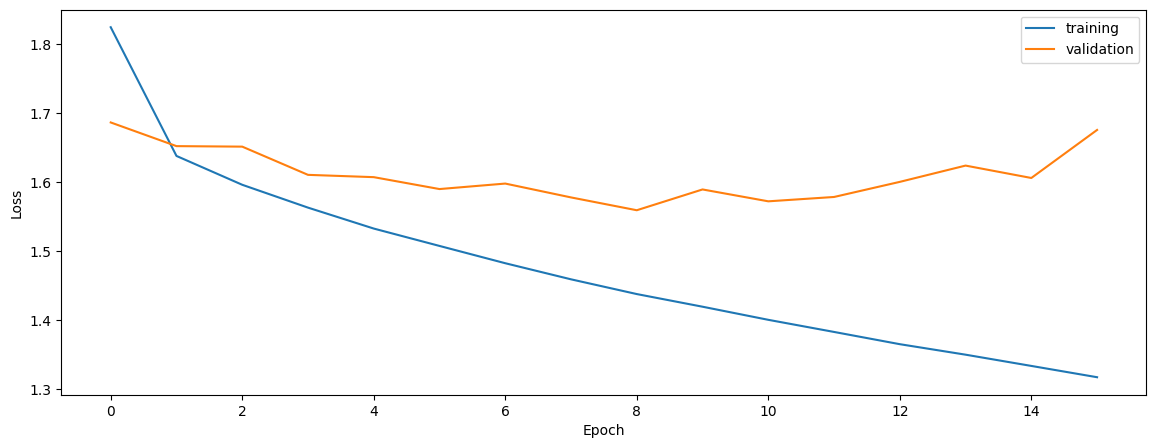

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.4447390565845381
0.38571078936521025


0.3020399933429775


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.4565242721463268
0.4333418931731985
0.3504368578593965


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.4592653257265307
0.442085308056872
0.3555129922611074


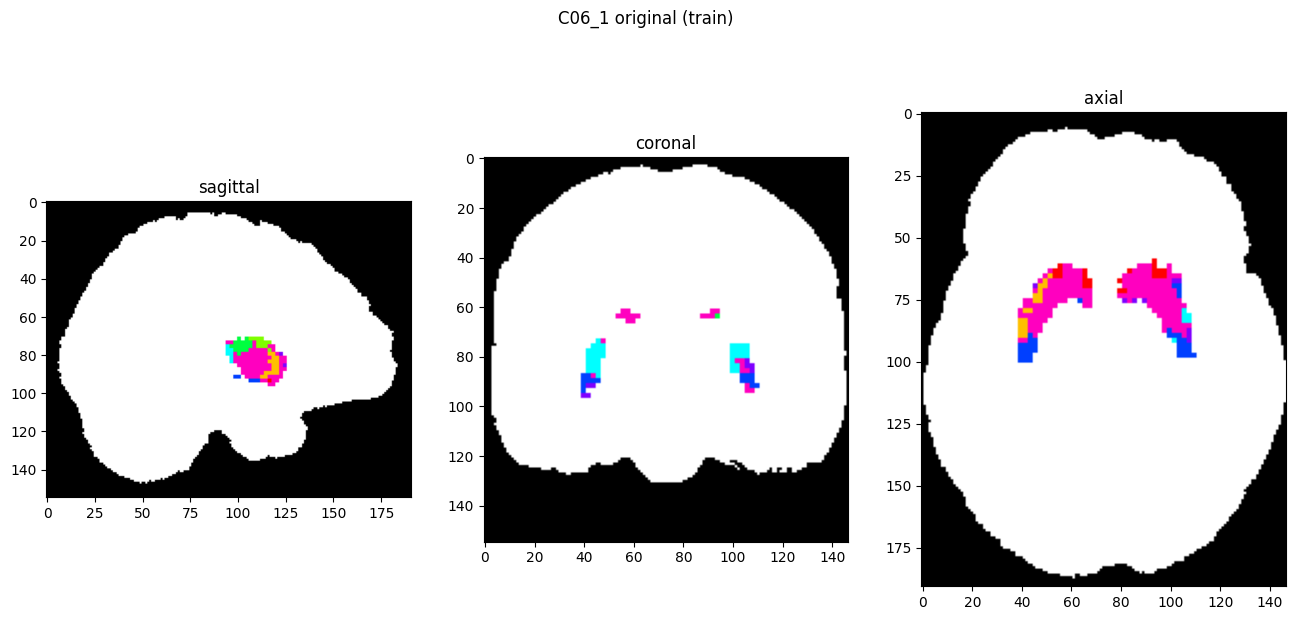

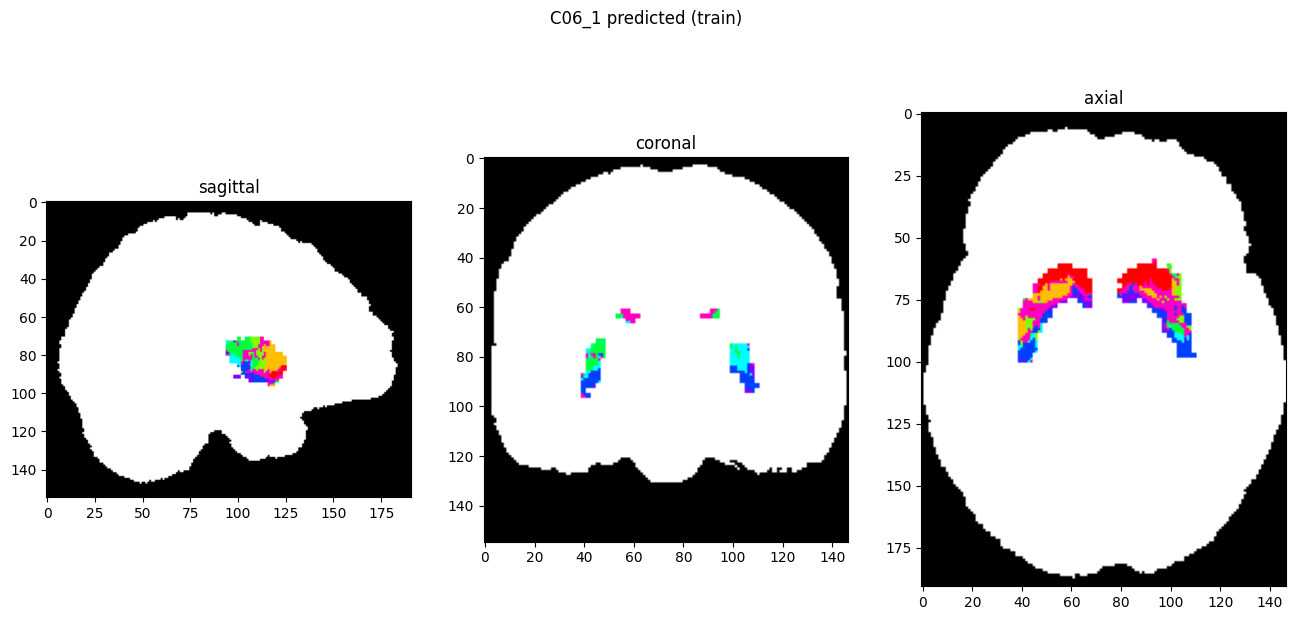

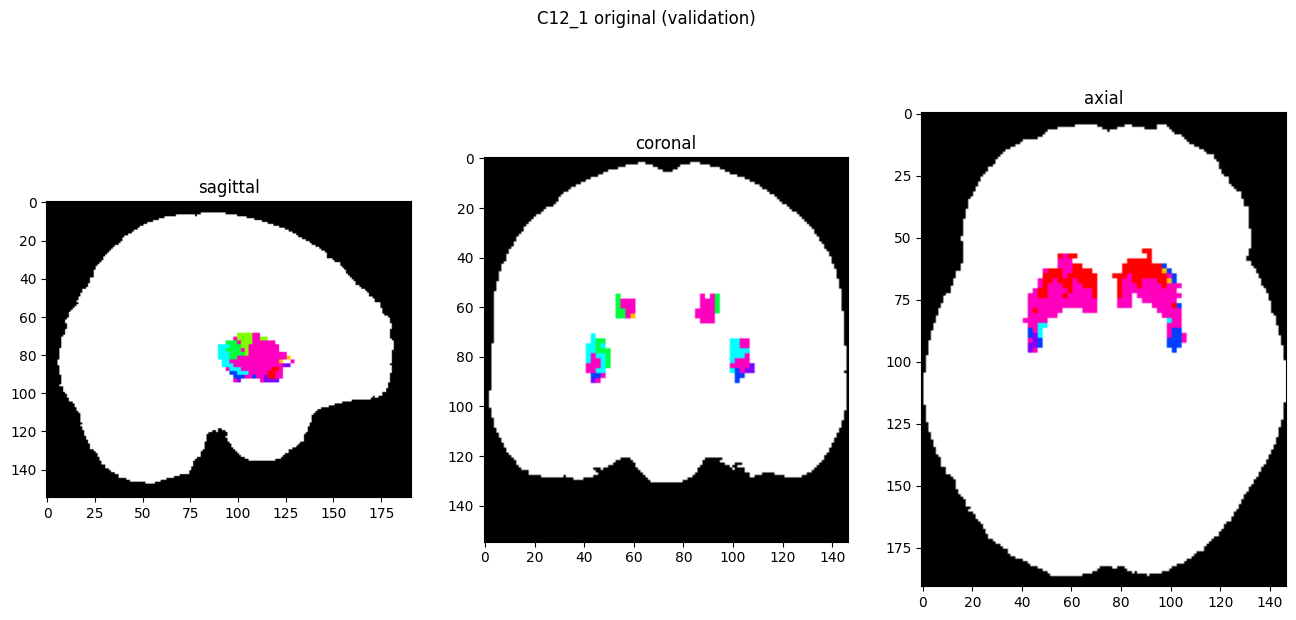

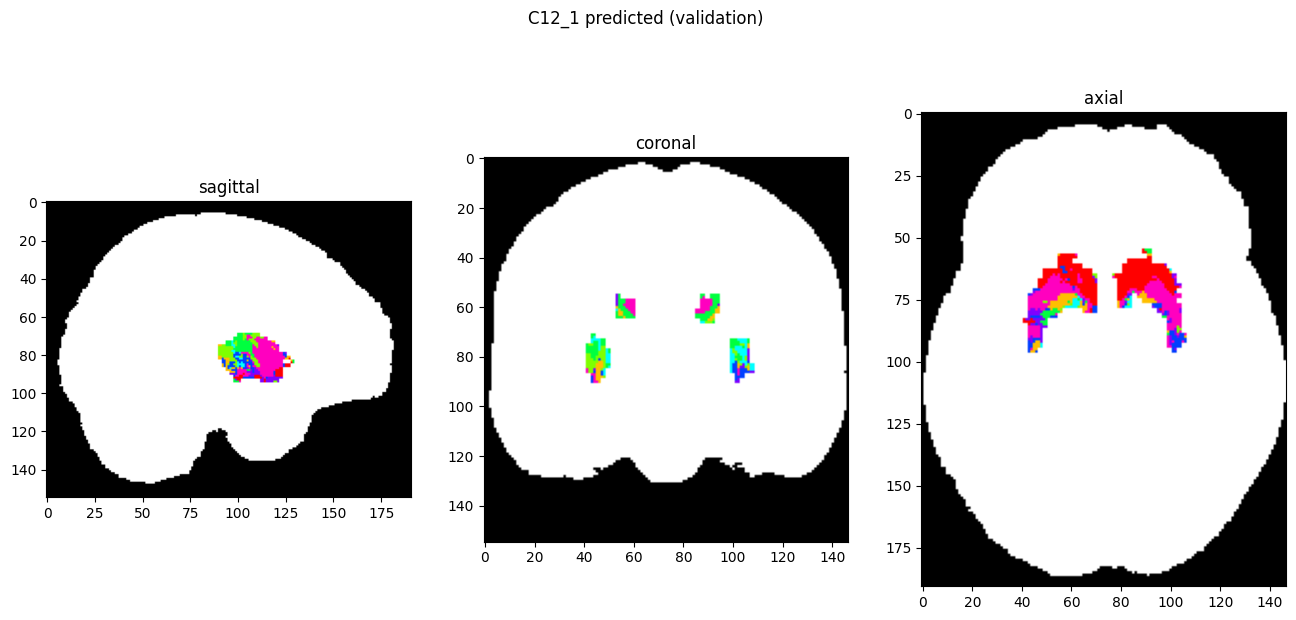

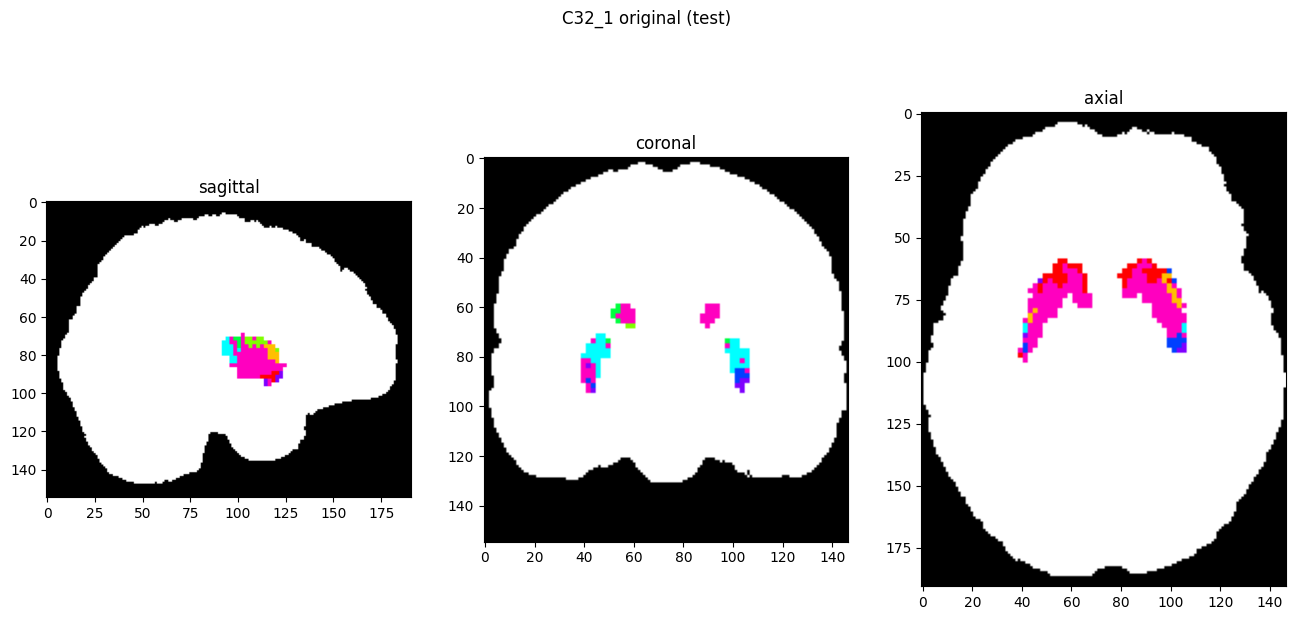

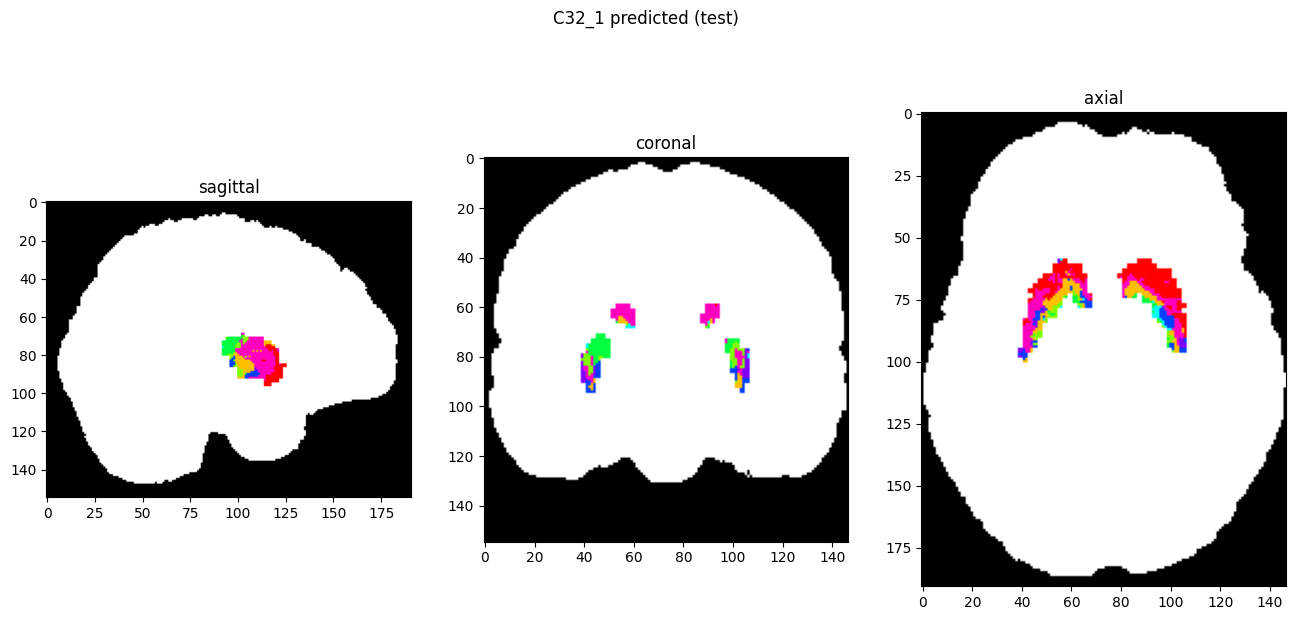

In [10]:
showResults(model, gen, threshold=0)